**генеративно-состязательные модели (GAN)** 

Евгений Борисов borisov.e@solarl.ru

In [1]:
# пара нейросетей генератор (создаёт "подделку") и дискриминатор (распознаёт подделку)

# одна эпоха обучения состоит из следующих шагов

# 1. генератор создаёт пакет "подделок" из случайного шума

# 2. дискриминатор имеет пакет "настоящих" образцов 
#    и обучается распознавать фальшивки на наборе фальшивые/настоящие

# 3. собираем конвейер генератор-дискриминатор
#    фиксируем веса дискриминатора (т.е. дискриминатор в конвейере не обучаем)
#    и обучаем генератор "обманывать" дискриминатор

In [2]:
#  Gulli Antonio, Pal Sujit. Deep Learning with Keras -- Packt Publishing, 2017

In [3]:
import numpy as np
import IPython


In [4]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape

from tensorflow.keras.optimizers import SGD

from tensorflow.keras.datasets import mnist

from tensorflow.keras import backend as K

from tensorflow.keras.utils import plot_model

In [35]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
tf.__version__, tf.keras.__version__

('1.13.1', '2.2.4-tf')

---

In [6]:
# !rm -r result_old
# !mv result result_old
# !mkdir result

---

In [7]:
(X_train, _),(_, _) = mnist.load_data()

X_train.shape

(60000, 28, 28)

In [8]:
img_rows, img_cols = X_train.shape[1], X_train.shape[2]
img_rows, img_cols

(28, 28)

In [9]:
X_train = (X_train - 127.5) / 127.5

In [10]:
# X_train = X_train[:,np.newaxis,:,:].astype('float32')
X_train = X_train[:,:,:,np.newaxis].astype('float32')
X_train.shape

(60000, 28, 28, 1)

---

In [11]:
generator = Sequential(name='generator')
generator.add(Dense(1024, input_shape=(100, ), activation='tanh'))
generator.add(Dense(128 * 7 * 7))
generator.add(BatchNormalization())
generator.add(Activation('tanh'))
generator.add(Reshape((7, 7, 128), input_shape=(7 * 7 * 128,)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64,(5,5),padding='same',activation='tanh',data_format='channels_last'))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1,(5,5),padding='same',activation='tanh',data_format='channels_last'))

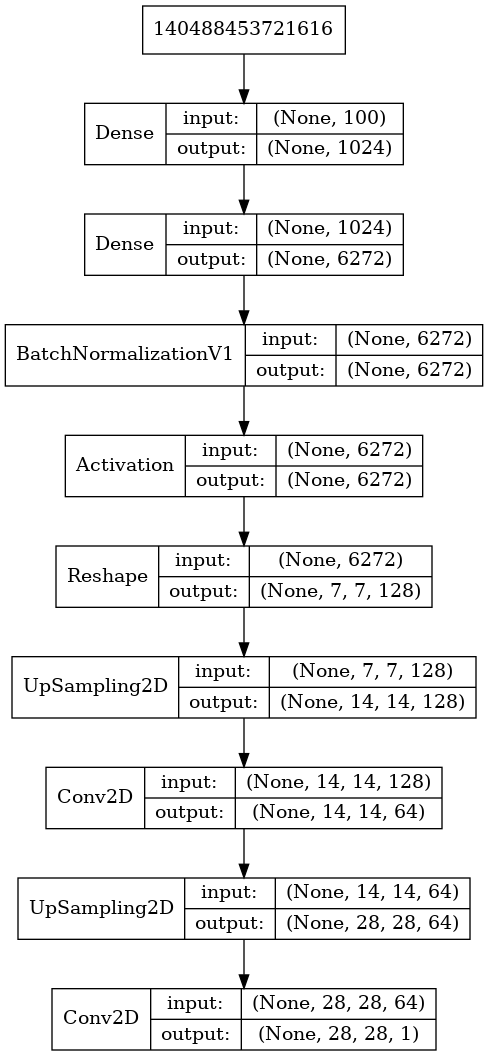

In [12]:
plot_model(generator,to_file='result/model-generator.png', show_layer_names=False, show_shapes=True )
IPython.display.Image('result/model-generator.png')

----

In [13]:
discriminator = Sequential(name='discriminator')
discriminator.add(Conv2D(64, (5, 5),
                padding='same',
                input_shape=(28, 28, 1),
                activation='tanh',
                data_format='channels_last'
   ))
discriminator.add(MaxPooling2D(pool_size=(2, 2)))
discriminator.add(Conv2D(128,(5,5),activation='tanh',data_format='channels_last'))
discriminator.add(MaxPooling2D(pool_size=(2, 2)))
discriminator.add(Flatten())
discriminator.add(Dense(1024, activation='tanh'))
discriminator.add(Dense(1, activation='sigmoid'))

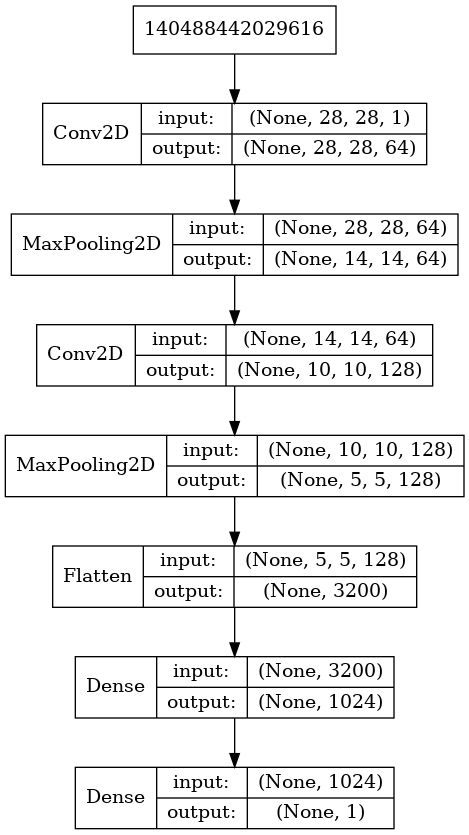

In [14]:
plot_model(discriminator,to_file='result/model-discriminator.png',show_layer_names=False, show_shapes=True )
IPython.display.Image('result/model-discriminator.png')

---

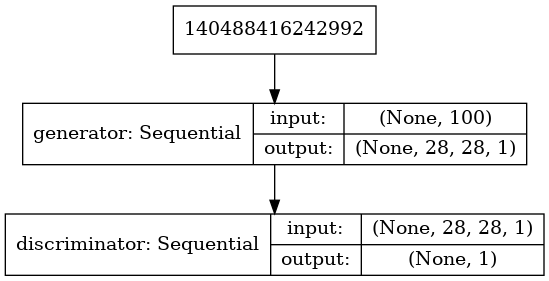

In [15]:
discriminator_on_generator = Sequential()
discriminator_on_generator.add(generator)
discriminator.trainable = False
discriminator_on_generator.add(discriminator)

plot_model( discriminator_on_generator, 
            to_file='result/model-discriminator_on_generator.png', 
            show_shapes=True, 
            show_layer_names=True )

IPython.display.Image('result/model-discriminator_on_generator.png')

---

In [16]:
generator.compile(loss='binary_crossentropy', optimizer="SGD")

discriminator_on_generator.compile(
    loss='binary_crossentropy', 
    optimizer=SGD(lr=0.0005, momentum=0.9, nesterov=True)
  )

discriminator.trainable = True
discriminator.compile(
    loss='binary_crossentropy', 
    optimizer=SGD(lr=0.0005, momentum=0.9, nesterov=True)
  )


---

In [17]:
import math 
from PIL import Image

def save_images(generated_images,e,b):
    generated_images = generated_images.reshape(generated_images.shape[0], 
                                                generated_images.shape[3], 
                                                generated_images.shape[1],
                                                generated_images.shape[2])
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num) / width))
    shape = generated_images.shape[2:]
    image = np.zeros((height * shape[0], width * shape[1]),dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index / width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = img[0,:,:]
        
    image = image * 127.5 + 127.5
    Image.fromarray( image.astype(np.uint8)).save('result/%02d_%d.png'%(e,b) )
                    
#     return image

---

In [18]:
BATCH_SIZE=100
N_EPOCH = 50
N_EX = X_train.shape[0]
N_BATCH = int( np.floor(N_EX/BATCH_SIZE) )

N_EX, N_BATCH

(60000, 600)

In [19]:
def chunks(X, batch_size=BATCH_SIZE): 
    for i in range(0, len(X), batch_size): 
        yield X[i:i+batch_size]

In [20]:
%%time

for e in range(N_EPOCH):
    print('epoch: ', e+1,'/',N_EPOCH)
    
    for b,Xb in enumerate(chunks(X_train)):
        print('\tbatch %d/%d, loss '%(b+1,N_BATCH))

        # генератор создаёт пакет "подделок" из случайного шума
        noise = np.random.uniform(-1, 1, (BATCH_SIZE,100))
        Xg = generator.predict(noise, verbose=0)
        
        # рисуем результат после каждого 200-го батча
        if b % 200 == 0: save_images(Xg,e,b)
        
        # собираем учебный набор для дискриминатора
        # из "фальшивых" и "настоящик" картинок
        X = np.concatenate((Xb, Xg))
        y = [1] * Xb.shape[0] + [0] * Xg.shape[0]

        # обучаем дискриминатор выявлять "фальшивые"
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(X, y)
        print('\t\t%f : discriminator'%(d_loss))
        
        # обучаем генератор "обманывать" дискриминатор
        noise = np.random.uniform(-1,1,(BATCH_SIZE,100))
        discriminator.trainable = False
        g_loss = discriminator_on_generator.train_on_batch( noise, [1]*BATCH_SIZE)
        
        print('\t\t%f : generator'%(g_loss))


epoch:  1 / 50
	batch 1/600, loss 
		0.688503 : discriminator
		0.696370 : generator
	batch 2/600, loss 
		0.675573 : discriminator
		0.689725 : generator
	batch 3/600, loss 
		0.655695 : discriminator
		0.683037 : generator
	batch 4/600, loss 
		0.641660 : discriminator
		0.672617 : generator
	batch 5/600, loss 
		0.627627 : discriminator
		0.666386 : generator
	batch 6/600, loss 
		0.612723 : discriminator
		0.659333 : generator
	batch 7/600, loss 
		0.591101 : discriminator
		0.651343 : generator
	batch 8/600, loss 
		0.568547 : discriminator
		0.641566 : generator
	batch 9/600, loss 
		0.552568 : discriminator
		0.630880 : generator
	batch 10/600, loss 
		0.536901 : discriminator
		0.627690 : generator
	batch 11/600, loss 
		0.518823 : discriminator
		0.618848 : generator
	batch 12/600, loss 
		0.504308 : discriminator
		0.615754 : generator
	batch 13/600, loss 
		0.494244 : discriminator
		0.609674 : generator
	batch 14/600, loss 
		0.487698 : discriminator
		0.603607 : generator


		0.257509 : discriminator
		0.872937 : generator
	batch 117/600, loss 
		0.239138 : discriminator
		0.856402 : generator
	batch 118/600, loss 
		0.241304 : discriminator
		0.869657 : generator
	batch 119/600, loss 
		0.249055 : discriminator
		0.827736 : generator
	batch 120/600, loss 
		0.246210 : discriminator
		0.812256 : generator
	batch 121/600, loss 
		0.252026 : discriminator
		0.810247 : generator
	batch 122/600, loss 
		0.271890 : discriminator
		0.839173 : generator
	batch 123/600, loss 
		0.243022 : discriminator
		0.806015 : generator
	batch 124/600, loss 
		0.280311 : discriminator
		0.795421 : generator
	batch 125/600, loss 
		0.270695 : discriminator
		0.798506 : generator
	batch 126/600, loss 
		0.287491 : discriminator
		0.793465 : generator
	batch 127/600, loss 
		0.281225 : discriminator
		0.775657 : generator
	batch 128/600, loss 
		0.326281 : discriminator
		0.766183 : generator
	batch 129/600, loss 
		0.319867 : discriminator
		0.785826 : generator
	batch 130/600

		0.295535 : discriminator
		1.092804 : generator
	batch 231/600, loss 
		0.271713 : discriminator
		1.122795 : generator
	batch 232/600, loss 
		0.306611 : discriminator
		1.182834 : generator
	batch 233/600, loss 
		0.316385 : discriminator
		1.125836 : generator
	batch 234/600, loss 
		0.342957 : discriminator
		1.017282 : generator
	batch 235/600, loss 
		0.353231 : discriminator
		1.076341 : generator
	batch 236/600, loss 
		0.409170 : discriminator
		1.057955 : generator
	batch 237/600, loss 
		0.450094 : discriminator
		0.926374 : generator
	batch 238/600, loss 
		0.444727 : discriminator
		1.030888 : generator
	batch 239/600, loss 
		0.426632 : discriminator
		0.958792 : generator
	batch 240/600, loss 
		0.416687 : discriminator
		0.907058 : generator
	batch 241/600, loss 
		0.414145 : discriminator
		0.914443 : generator
	batch 242/600, loss 
		0.401603 : discriminator
		1.031093 : generator
	batch 243/600, loss 
		0.481641 : discriminator
		1.012438 : generator
	batch 244/600

		0.458372 : discriminator
		1.043398 : generator
	batch 345/600, loss 
		0.491466 : discriminator
		1.075823 : generator
	batch 346/600, loss 
		0.466974 : discriminator
		1.062305 : generator
	batch 347/600, loss 
		0.480439 : discriminator
		1.079678 : generator
	batch 348/600, loss 
		0.522209 : discriminator
		1.046585 : generator
	batch 349/600, loss 
		0.494078 : discriminator
		1.071229 : generator
	batch 350/600, loss 
		0.467572 : discriminator
		1.022743 : generator
	batch 351/600, loss 
		0.467026 : discriminator
		1.056428 : generator
	batch 352/600, loss 
		0.475180 : discriminator
		1.068610 : generator
	batch 353/600, loss 
		0.506453 : discriminator
		1.056857 : generator
	batch 354/600, loss 
		0.483746 : discriminator
		1.027885 : generator
	batch 355/600, loss 
		0.493889 : discriminator
		1.027143 : generator
	batch 356/600, loss 
		0.484807 : discriminator
		0.998501 : generator
	batch 357/600, loss 
		0.480567 : discriminator
		1.008236 : generator
	batch 358/600

		0.466504 : discriminator
		1.082860 : generator
	batch 459/600, loss 
		0.465677 : discriminator
		1.110398 : generator
	batch 460/600, loss 
		0.508940 : discriminator
		1.113010 : generator
	batch 461/600, loss 
		0.483484 : discriminator
		1.074630 : generator
	batch 462/600, loss 
		0.473022 : discriminator
		1.067547 : generator
	batch 463/600, loss 
		0.459156 : discriminator
		1.127770 : generator
	batch 464/600, loss 
		0.490475 : discriminator
		1.083406 : generator
	batch 465/600, loss 
		0.507160 : discriminator
		1.109628 : generator
	batch 466/600, loss 
		0.505992 : discriminator
		1.080174 : generator
	batch 467/600, loss 
		0.488545 : discriminator
		1.096182 : generator
	batch 468/600, loss 
		0.507198 : discriminator
		1.083313 : generator
	batch 469/600, loss 
		0.468072 : discriminator
		1.129079 : generator
	batch 470/600, loss 
		0.518966 : discriminator
		1.113630 : generator
	batch 471/600, loss 
		0.505859 : discriminator
		1.037903 : generator
	batch 472/600

		0.474741 : discriminator
		1.184722 : generator
	batch 573/600, loss 
		0.469194 : discriminator
		1.261165 : generator
	batch 574/600, loss 
		0.473333 : discriminator
		1.257260 : generator
	batch 575/600, loss 
		0.462871 : discriminator
		1.227093 : generator
	batch 576/600, loss 
		0.473005 : discriminator
		1.245551 : generator
	batch 577/600, loss 
		0.416519 : discriminator
		1.176597 : generator
	batch 578/600, loss 
		0.458211 : discriminator
		1.121891 : generator
	batch 579/600, loss 
		0.456082 : discriminator
		1.146543 : generator
	batch 580/600, loss 
		0.524864 : discriminator
		1.078548 : generator
	batch 581/600, loss 
		0.431168 : discriminator
		1.120582 : generator
	batch 582/600, loss 
		0.512542 : discriminator
		1.126905 : generator
	batch 583/600, loss 
		0.452590 : discriminator
		1.205284 : generator
	batch 584/600, loss 
		0.486723 : discriminator
		1.221908 : generator
	batch 585/600, loss 
		0.462046 : discriminator
		1.244206 : generator
	batch 586/600

		0.454116 : discriminator
		1.247930 : generator
	batch 88/600, loss 
		0.443011 : discriminator
		1.210932 : generator
	batch 89/600, loss 
		0.484928 : discriminator
		1.171672 : generator
	batch 90/600, loss 
		0.450924 : discriminator
		1.223143 : generator
	batch 91/600, loss 
		0.431642 : discriminator
		1.183126 : generator
	batch 92/600, loss 
		0.434175 : discriminator
		1.232892 : generator
	batch 93/600, loss 
		0.446979 : discriminator
		1.193875 : generator
	batch 94/600, loss 
		0.483575 : discriminator
		1.119199 : generator
	batch 95/600, loss 
		0.483323 : discriminator
		1.060970 : generator
	batch 96/600, loss 
		0.470102 : discriminator
		1.165450 : generator
	batch 97/600, loss 
		0.519819 : discriminator
		1.057631 : generator
	batch 98/600, loss 
		0.407961 : discriminator
		1.200699 : generator
	batch 99/600, loss 
		0.440710 : discriminator
		1.242440 : generator
	batch 100/600, loss 
		0.419639 : discriminator
		1.301919 : generator
	batch 101/600, loss 
		0.

		0.515900 : discriminator
		1.050997 : generator
	batch 202/600, loss 
		0.483136 : discriminator
		1.010431 : generator
	batch 203/600, loss 
		0.504089 : discriminator
		0.980426 : generator
	batch 204/600, loss 
		0.448643 : discriminator
		1.046378 : generator
	batch 205/600, loss 
		0.437005 : discriminator
		1.319167 : generator
	batch 206/600, loss 
		0.415595 : discriminator
		1.277030 : generator
	batch 207/600, loss 
		0.437639 : discriminator
		1.322397 : generator
	batch 208/600, loss 
		0.416868 : discriminator
		1.315324 : generator
	batch 209/600, loss 
		0.495924 : discriminator
		1.195277 : generator
	batch 210/600, loss 
		0.490659 : discriminator
		1.044804 : generator
	batch 211/600, loss 
		0.433613 : discriminator
		1.046260 : generator
	batch 212/600, loss 
		0.427375 : discriminator
		1.190960 : generator
	batch 213/600, loss 
		0.388655 : discriminator
		1.267469 : generator
	batch 214/600, loss 
		0.424849 : discriminator
		1.280749 : generator
	batch 215/600

		0.386231 : discriminator
		1.284762 : generator
	batch 316/600, loss 
		0.386149 : discriminator
		1.271125 : generator
	batch 317/600, loss 
		0.414845 : discriminator
		1.238320 : generator
	batch 318/600, loss 
		0.437444 : discriminator
		1.147094 : generator
	batch 319/600, loss 
		0.391224 : discriminator
		1.339234 : generator
	batch 320/600, loss 
		0.418689 : discriminator
		1.289595 : generator
	batch 321/600, loss 
		0.408084 : discriminator
		1.365000 : generator
	batch 322/600, loss 
		0.457292 : discriminator
		1.380795 : generator
	batch 323/600, loss 
		0.400877 : discriminator
		1.250801 : generator
	batch 324/600, loss 
		0.549359 : discriminator
		1.230994 : generator
	batch 325/600, loss 
		0.518739 : discriminator
		1.088007 : generator
	batch 326/600, loss 
		0.481021 : discriminator
		1.172127 : generator
	batch 327/600, loss 
		0.389149 : discriminator
		1.278922 : generator
	batch 328/600, loss 
		0.382517 : discriminator
		1.222185 : generator
	batch 329/600

		0.328120 : discriminator
		1.450051 : generator
	batch 430/600, loss 
		0.353444 : discriminator
		1.408314 : generator
	batch 431/600, loss 
		0.357918 : discriminator
		1.336409 : generator
	batch 432/600, loss 
		0.351113 : discriminator
		1.418067 : generator
	batch 433/600, loss 
		0.341423 : discriminator
		1.395217 : generator
	batch 434/600, loss 
		0.341306 : discriminator
		1.405536 : generator
	batch 435/600, loss 
		0.331014 : discriminator
		1.328698 : generator
	batch 436/600, loss 
		0.333765 : discriminator
		1.318597 : generator
	batch 437/600, loss 
		0.383882 : discriminator
		1.281841 : generator
	batch 438/600, loss 
		0.365842 : discriminator
		1.339868 : generator
	batch 439/600, loss 
		0.362960 : discriminator
		1.400789 : generator
	batch 440/600, loss 
		0.337148 : discriminator
		1.342632 : generator
	batch 441/600, loss 
		0.363711 : discriminator
		1.334192 : generator
	batch 442/600, loss 
		0.381802 : discriminator
		1.278774 : generator
	batch 443/600

		0.349295 : discriminator
		1.331722 : generator
	batch 544/600, loss 
		0.392725 : discriminator
		1.221439 : generator
	batch 545/600, loss 
		0.408119 : discriminator
		1.322932 : generator
	batch 546/600, loss 
		0.376769 : discriminator
		1.398614 : generator
	batch 547/600, loss 
		0.377422 : discriminator
		1.364789 : generator
	batch 548/600, loss 
		0.372112 : discriminator
		1.308011 : generator
	batch 549/600, loss 
		0.440838 : discriminator
		1.279276 : generator
	batch 550/600, loss 
		0.436782 : discriminator
		1.351109 : generator
	batch 551/600, loss 
		0.387197 : discriminator
		1.267281 : generator
	batch 552/600, loss 
		0.370426 : discriminator
		1.336565 : generator
	batch 553/600, loss 
		0.411470 : discriminator
		1.374625 : generator
	batch 554/600, loss 
		0.370203 : discriminator
		1.438406 : generator
	batch 555/600, loss 
		0.361385 : discriminator
		1.288360 : generator
	batch 556/600, loss 
		0.491397 : discriminator
		1.260944 : generator
	batch 557/600

		0.448965 : discriminator
		1.023494 : generator
	batch 59/600, loss 
		0.490967 : discriminator
		1.365134 : generator
	batch 60/600, loss 
		0.448777 : discriminator
		1.055737 : generator
	batch 61/600, loss 
		0.495314 : discriminator
		1.206823 : generator
	batch 62/600, loss 
		0.534918 : discriminator
		1.242107 : generator
	batch 63/600, loss 
		0.449515 : discriminator
		1.239109 : generator
	batch 64/600, loss 
		0.470444 : discriminator
		1.221523 : generator
	batch 65/600, loss 
		0.462137 : discriminator
		1.066520 : generator
	batch 66/600, loss 
		0.410383 : discriminator
		1.185740 : generator
	batch 67/600, loss 
		0.431238 : discriminator
		1.068308 : generator
	batch 68/600, loss 
		0.504866 : discriminator
		0.962794 : generator
	batch 69/600, loss 
		0.552966 : discriminator
		0.950350 : generator
	batch 70/600, loss 
		0.495927 : discriminator
		1.573900 : generator
	batch 71/600, loss 
		0.475955 : discriminator
		1.064464 : generator
	batch 72/600, loss 
		0.42

		1.326699 : generator
	batch 173/600, loss 
		0.430357 : discriminator
		1.341576 : generator
	batch 174/600, loss 
		0.426402 : discriminator
		1.351632 : generator
	batch 175/600, loss 
		0.434780 : discriminator
		1.249876 : generator
	batch 176/600, loss 
		0.470542 : discriminator
		1.071796 : generator
	batch 177/600, loss 
		0.500587 : discriminator
		1.110795 : generator
	batch 178/600, loss 
		0.450583 : discriminator
		1.423542 : generator
	batch 179/600, loss 
		0.529160 : discriminator
		0.969211 : generator
	batch 180/600, loss 
		0.458805 : discriminator
		1.487048 : generator
	batch 181/600, loss 
		0.430407 : discriminator
		1.131283 : generator
	batch 182/600, loss 
		0.441871 : discriminator
		1.353292 : generator
	batch 183/600, loss 
		0.488229 : discriminator
		1.095527 : generator
	batch 184/600, loss 
		0.471255 : discriminator
		0.990041 : generator
	batch 185/600, loss 
		0.437548 : discriminator
		1.093047 : generator
	batch 186/600, loss 
		0.431037 : discri

		1.030716 : generator
	batch 287/600, loss 
		0.456741 : discriminator
		1.073488 : generator
	batch 288/600, loss 
		0.437036 : discriminator
		1.479327 : generator
	batch 289/600, loss 
		0.472983 : discriminator
		1.104774 : generator
	batch 290/600, loss 
		0.478281 : discriminator
		1.245046 : generator
	batch 291/600, loss 
		0.471796 : discriminator
		1.081065 : generator
	batch 292/600, loss 
		0.430196 : discriminator
		1.216220 : generator
	batch 293/600, loss 
		0.446120 : discriminator
		1.095005 : generator
	batch 294/600, loss 
		0.482306 : discriminator
		1.291282 : generator
	batch 295/600, loss 
		0.420483 : discriminator
		1.346604 : generator
	batch 296/600, loss 
		0.373738 : discriminator
		1.294365 : generator
	batch 297/600, loss 
		0.404543 : discriminator
		1.341257 : generator
	batch 298/600, loss 
		0.420392 : discriminator
		1.013583 : generator
	batch 299/600, loss 
		0.392738 : discriminator
		1.381556 : generator
	batch 300/600, loss 
		0.402099 : discri

		1.944214 : generator
	batch 401/600, loss 
		0.472155 : discriminator
		0.762248 : generator
	batch 402/600, loss 
		0.444980 : discriminator
		2.006183 : generator
	batch 403/600, loss 
		0.345294 : discriminator
		1.040086 : generator
	batch 404/600, loss 
		0.343634 : discriminator
		1.884767 : generator
	batch 405/600, loss 
		0.464843 : discriminator
		0.962950 : generator
	batch 406/600, loss 
		0.490696 : discriminator
		1.617275 : generator
	batch 407/600, loss 
		0.357127 : discriminator
		1.132903 : generator
	batch 408/600, loss 
		0.333672 : discriminator
		1.835011 : generator
	batch 409/600, loss 
		0.398098 : discriminator
		0.937469 : generator
	batch 410/600, loss 
		0.395121 : discriminator
		1.502173 : generator
	batch 411/600, loss 
		0.354292 : discriminator
		1.407431 : generator
	batch 412/600, loss 
		0.339833 : discriminator
		1.289915 : generator
	batch 413/600, loss 
		0.363590 : discriminator
		1.590461 : generator
	batch 414/600, loss 
		0.396849 : discri

		1.429596 : generator
	batch 515/600, loss 
		0.323134 : discriminator
		1.951109 : generator
	batch 516/600, loss 
		0.325852 : discriminator
		1.343108 : generator
	batch 517/600, loss 
		0.338493 : discriminator
		2.068013 : generator
	batch 518/600, loss 
		0.404913 : discriminator
		0.717239 : generator
	batch 519/600, loss 
		0.431899 : discriminator
		2.568472 : generator
	batch 520/600, loss 
		0.473973 : discriminator
		0.794132 : generator
	batch 521/600, loss 
		0.418441 : discriminator
		2.226898 : generator
	batch 522/600, loss 
		0.403088 : discriminator
		0.790906 : generator
	batch 523/600, loss 
		0.398480 : discriminator
		2.171782 : generator
	batch 524/600, loss 
		0.349400 : discriminator
		1.154773 : generator
	batch 525/600, loss 
		0.374353 : discriminator
		1.756702 : generator
	batch 526/600, loss 
		0.277247 : discriminator
		1.705726 : generator
	batch 527/600, loss 
		0.292279 : discriminator
		1.580269 : generator
	batch 528/600, loss 
		0.292503 : discri

		0.430563 : discriminator
		1.568506 : generator
	batch 30/600, loss 
		0.277959 : discriminator
		1.660048 : generator
	batch 31/600, loss 
		0.252520 : discriminator
		1.851448 : generator
	batch 32/600, loss 
		0.283625 : discriminator
		1.428880 : generator
	batch 33/600, loss 
		0.278330 : discriminator
		1.695201 : generator
	batch 34/600, loss 
		0.319059 : discriminator
		1.412113 : generator
	batch 35/600, loss 
		0.278962 : discriminator
		2.000832 : generator
	batch 36/600, loss 
		0.327546 : discriminator
		1.347623 : generator
	batch 37/600, loss 
		0.380452 : discriminator
		1.692052 : generator
	batch 38/600, loss 
		0.272029 : discriminator
		1.822577 : generator
	batch 39/600, loss 
		0.277280 : discriminator
		1.625204 : generator
	batch 40/600, loss 
		0.302780 : discriminator
		1.627283 : generator
	batch 41/600, loss 
		0.339218 : discriminator
		1.466175 : generator
	batch 42/600, loss 
		0.350805 : discriminator
		1.457167 : generator
	batch 43/600, loss 
		0.30

		0.340656 : discriminator
		2.056422 : generator
	batch 145/600, loss 
		0.272065 : discriminator
		1.513602 : generator
	batch 146/600, loss 
		0.266920 : discriminator
		1.907644 : generator
	batch 147/600, loss 
		0.294649 : discriminator
		1.360656 : generator
	batch 148/600, loss 
		0.302847 : discriminator
		2.148271 : generator
	batch 149/600, loss 
		0.323186 : discriminator
		1.114650 : generator
	batch 150/600, loss 
		0.320885 : discriminator
		2.260799 : generator
	batch 151/600, loss 
		0.285992 : discriminator
		1.593922 : generator
	batch 152/600, loss 
		0.240167 : discriminator
		1.971920 : generator
	batch 153/600, loss 
		0.211825 : discriminator
		1.869128 : generator
	batch 154/600, loss 
		0.235345 : discriminator
		1.675094 : generator
	batch 155/600, loss 
		0.233674 : discriminator
		2.197941 : generator
	batch 156/600, loss 
		0.240718 : discriminator
		1.610188 : generator
	batch 157/600, loss 
		0.254601 : discriminator
		2.491490 : generator
	batch 158/600

		0.250355 : discriminator
		2.330246 : generator
	batch 259/600, loss 
		0.258947 : discriminator
		1.111697 : generator
	batch 260/600, loss 
		0.299096 : discriminator
		2.912410 : generator
	batch 261/600, loss 
		0.332463 : discriminator
		1.085669 : generator
	batch 262/600, loss 
		0.285168 : discriminator
		2.777433 : generator
	batch 263/600, loss 
		0.289708 : discriminator
		1.097045 : generator
	batch 264/600, loss 
		0.263112 : discriminator
		2.614203 : generator
	batch 265/600, loss 
		0.308634 : discriminator
		0.943780 : generator
	batch 266/600, loss 
		0.347860 : discriminator
		3.303492 : generator
	batch 267/600, loss 
		0.427064 : discriminator
		0.793207 : generator
	batch 268/600, loss 
		0.448750 : discriminator
		3.134531 : generator
	batch 269/600, loss 
		0.505346 : discriminator
		0.662888 : generator
	batch 270/600, loss 
		0.514286 : discriminator
		4.321053 : generator
	batch 271/600, loss 
		0.574165 : discriminator
		0.944043 : generator
	batch 272/600

		0.370813 : discriminator
		1.447702 : generator
	batch 373/600, loss 
		0.291597 : discriminator
		2.130445 : generator
	batch 374/600, loss 
		0.289837 : discriminator
		1.767368 : generator
	batch 375/600, loss 
		0.246851 : discriminator
		1.977686 : generator
	batch 376/600, loss 
		0.225673 : discriminator
		1.897657 : generator
	batch 377/600, loss 
		0.211505 : discriminator
		1.837656 : generator
	batch 378/600, loss 
		0.266149 : discriminator
		1.883074 : generator
	batch 379/600, loss 
		0.224897 : discriminator
		1.996508 : generator
	batch 380/600, loss 
		0.224676 : discriminator
		2.707100 : generator
	batch 381/600, loss 
		0.164114 : discriminator
		2.362537 : generator
	batch 382/600, loss 
		0.234377 : discriminator
		1.681677 : generator
	batch 383/600, loss 
		0.243174 : discriminator
		2.810627 : generator
	batch 384/600, loss 
		0.235475 : discriminator
		1.827828 : generator
	batch 385/600, loss 
		0.214599 : discriminator
		2.916352 : generator
	batch 386/600

		0.298082 : discriminator
		2.454495 : generator
	batch 487/600, loss 
		0.305046 : discriminator
		1.883802 : generator
	batch 488/600, loss 
		0.275048 : discriminator
		2.156795 : generator
	batch 489/600, loss 
		0.247859 : discriminator
		1.719506 : generator
	batch 490/600, loss 
		0.330021 : discriminator
		2.255610 : generator
	batch 491/600, loss 
		0.272671 : discriminator
		1.505684 : generator
	batch 492/600, loss 
		0.369162 : discriminator
		1.873210 : generator
	batch 493/600, loss 
		0.240892 : discriminator
		2.364824 : generator
	batch 494/600, loss 
		0.240406 : discriminator
		2.180506 : generator
	batch 495/600, loss 
		0.232545 : discriminator
		2.007614 : generator
	batch 496/600, loss 
		0.259010 : discriminator
		2.725053 : generator
	batch 497/600, loss 
		0.185145 : discriminator
		2.329350 : generator
	batch 498/600, loss 
		0.186997 : discriminator
		2.575819 : generator
	batch 499/600, loss 
		0.169533 : discriminator
		2.917941 : generator
	batch 500/600

		0.274984 : discriminator
		1.554509 : generator
epoch:  5 / 50
	batch 1/600, loss 
		0.268024 : discriminator
		3.305673 : generator
	batch 2/600, loss 
		0.310738 : discriminator
		1.225668 : generator
	batch 3/600, loss 
		0.299318 : discriminator
		3.257150 : generator
	batch 4/600, loss 
		0.257851 : discriminator
		1.848875 : generator
	batch 5/600, loss 
		0.231376 : discriminator
		2.485577 : generator
	batch 6/600, loss 
		0.179917 : discriminator
		2.414219 : generator
	batch 7/600, loss 
		0.196799 : discriminator
		2.516622 : generator
	batch 8/600, loss 
		0.238564 : discriminator
		1.823787 : generator
	batch 9/600, loss 
		0.191797 : discriminator
		2.619315 : generator
	batch 10/600, loss 
		0.193951 : discriminator
		2.645745 : generator
	batch 11/600, loss 
		0.170675 : discriminator
		2.219004 : generator
	batch 12/600, loss 
		0.291921 : discriminator
		2.673599 : generator
	batch 13/600, loss 
		0.778101 : discriminator
		1.371482 : generator
	batch 14/600, loss 


		2.579842 : generator
	batch 116/600, loss 
		0.159802 : discriminator
		2.271917 : generator
	batch 117/600, loss 
		0.215382 : discriminator
		2.021742 : generator
	batch 118/600, loss 
		0.224932 : discriminator
		2.665131 : generator
	batch 119/600, loss 
		0.213461 : discriminator
		1.989313 : generator
	batch 120/600, loss 
		0.250238 : discriminator
		2.669148 : generator
	batch 121/600, loss 
		0.276000 : discriminator
		1.802707 : generator
	batch 122/600, loss 
		0.316355 : discriminator
		3.761303 : generator
	batch 123/600, loss 
		0.274961 : discriminator
		1.843321 : generator
	batch 124/600, loss 
		0.202911 : discriminator
		2.249668 : generator
	batch 125/600, loss 
		0.186878 : discriminator
		2.874635 : generator
	batch 126/600, loss 
		0.159645 : discriminator
		2.096598 : generator
	batch 127/600, loss 
		0.166469 : discriminator
		2.681178 : generator
	batch 128/600, loss 
		0.178120 : discriminator
		2.144069 : generator
	batch 129/600, loss 
		0.183337 : discri

		2.559410 : generator
	batch 230/600, loss 
		0.189190 : discriminator
		2.427149 : generator
	batch 231/600, loss 
		0.208121 : discriminator
		2.023346 : generator
	batch 232/600, loss 
		0.191674 : discriminator
		2.516437 : generator
	batch 233/600, loss 
		0.203308 : discriminator
		2.390813 : generator
	batch 234/600, loss 
		0.201503 : discriminator
		2.207371 : generator
	batch 235/600, loss 
		0.182727 : discriminator
		2.765619 : generator
	batch 236/600, loss 
		0.145678 : discriminator
		2.523486 : generator
	batch 237/600, loss 
		0.132060 : discriminator
		2.661133 : generator
	batch 238/600, loss 
		0.121640 : discriminator
		2.763742 : generator
	batch 239/600, loss 
		0.114281 : discriminator
		2.588038 : generator
	batch 240/600, loss 
		0.126507 : discriminator
		2.722389 : generator
	batch 241/600, loss 
		0.187288 : discriminator
		1.965314 : generator
	batch 242/600, loss 
		0.195312 : discriminator
		2.482372 : generator
	batch 243/600, loss 
		0.187770 : discri

		3.337308 : generator
	batch 344/600, loss 
		0.301694 : discriminator
		1.584105 : generator
	batch 345/600, loss 
		0.256228 : discriminator
		3.201686 : generator
	batch 346/600, loss 
		0.158913 : discriminator
		2.664499 : generator
	batch 347/600, loss 
		0.193092 : discriminator
		1.963439 : generator
	batch 348/600, loss 
		0.228416 : discriminator
		3.056163 : generator
	batch 349/600, loss 
		0.317681 : discriminator
		1.460847 : generator
	batch 350/600, loss 
		0.238649 : discriminator
		3.598594 : generator
	batch 351/600, loss 
		0.204977 : discriminator
		2.354430 : generator
	batch 352/600, loss 
		0.156552 : discriminator
		2.766690 : generator
	batch 353/600, loss 
		0.118083 : discriminator
		2.913473 : generator
	batch 354/600, loss 
		0.179222 : discriminator
		2.169323 : generator
	batch 355/600, loss 
		0.180224 : discriminator
		2.915288 : generator
	batch 356/600, loss 
		0.192545 : discriminator
		1.961796 : generator
	batch 357/600, loss 
		0.149546 : discri

		2.126033 : generator
	batch 458/600, loss 
		0.200412 : discriminator
		2.234909 : generator
	batch 459/600, loss 
		0.226816 : discriminator
		2.860439 : generator
	batch 460/600, loss 
		0.210329 : discriminator
		1.864502 : generator
	batch 461/600, loss 
		0.296433 : discriminator
		2.450825 : generator
	batch 462/600, loss 
		0.194407 : discriminator
		3.046951 : generator
	batch 463/600, loss 
		0.197426 : discriminator
		2.739913 : generator
	batch 464/600, loss 
		0.180486 : discriminator
		2.696179 : generator
	batch 465/600, loss 
		0.203418 : discriminator
		2.178326 : generator
	batch 466/600, loss 
		0.182114 : discriminator
		2.943086 : generator
	batch 467/600, loss 
		0.212099 : discriminator
		1.749419 : generator
	batch 468/600, loss 
		0.274028 : discriminator
		3.434402 : generator
	batch 469/600, loss 
		0.185512 : discriminator
		2.327902 : generator
	batch 470/600, loss 
		0.196073 : discriminator
		2.645456 : generator
	batch 471/600, loss 
		0.213516 : discri

		2.635428 : generator
	batch 572/600, loss 
		0.175299 : discriminator
		2.303943 : generator
	batch 573/600, loss 
		0.204915 : discriminator
		3.041465 : generator
	batch 574/600, loss 
		0.162281 : discriminator
		2.418945 : generator
	batch 575/600, loss 
		0.172006 : discriminator
		2.229542 : generator
	batch 576/600, loss 
		0.233970 : discriminator
		3.457246 : generator
	batch 577/600, loss 
		0.194449 : discriminator
		2.235898 : generator
	batch 578/600, loss 
		0.198366 : discriminator
		2.824675 : generator
	batch 579/600, loss 
		0.169472 : discriminator
		3.239938 : generator
	batch 580/600, loss 
		0.254355 : discriminator
		1.639467 : generator
	batch 581/600, loss 
		0.221960 : discriminator
		3.208539 : generator
	batch 582/600, loss 
		0.150629 : discriminator
		2.251958 : generator
	batch 583/600, loss 
		0.176456 : discriminator
		3.108340 : generator
	batch 584/600, loss 
		0.254615 : discriminator
		2.237442 : generator
	batch 585/600, loss 
		0.172001 : discri

		3.013079 : generator
	batch 87/600, loss 
		0.439485 : discriminator
		1.374183 : generator
	batch 88/600, loss 
		0.399017 : discriminator
		3.707518 : generator
	batch 89/600, loss 
		0.372454 : discriminator
		1.390140 : generator
	batch 90/600, loss 
		0.298578 : discriminator
		2.889046 : generator
	batch 91/600, loss 
		0.304368 : discriminator
		1.487934 : generator
	batch 92/600, loss 
		0.286865 : discriminator
		2.367491 : generator
	batch 93/600, loss 
		0.356559 : discriminator
		0.952292 : generator
	batch 94/600, loss 
		0.429435 : discriminator
		4.495766 : generator
	batch 95/600, loss 
		0.334399 : discriminator
		2.357303 : generator
	batch 96/600, loss 
		0.268020 : discriminator
		1.514122 : generator
	batch 97/600, loss 
		0.290582 : discriminator
		3.157601 : generator
	batch 98/600, loss 
		0.253959 : discriminator
		2.200814 : generator
	batch 99/600, loss 
		0.190500 : discriminator
		3.193766 : generator
	batch 100/600, loss 
		0.218871 : discriminator
		2.2

		2.577237 : generator
	batch 201/600, loss 
		0.266016 : discriminator
		1.635193 : generator
	batch 202/600, loss 
		0.270619 : discriminator
		2.955031 : generator
	batch 203/600, loss 
		0.379367 : discriminator
		0.795490 : generator
	batch 204/600, loss 
		0.489361 : discriminator
		4.090892 : generator
	batch 205/600, loss 
		0.562303 : discriminator
		1.034920 : generator
	batch 206/600, loss 
		0.382238 : discriminator
		2.865726 : generator
	batch 207/600, loss 
		0.370069 : discriminator
		1.220787 : generator
	batch 208/600, loss 
		0.437087 : discriminator
		3.750060 : generator
	batch 209/600, loss 
		0.469658 : discriminator
		1.414048 : generator
	batch 210/600, loss 
		0.383568 : discriminator
		2.595901 : generator
	batch 211/600, loss 
		0.256995 : discriminator
		1.840617 : generator
	batch 212/600, loss 
		0.234470 : discriminator
		2.518828 : generator
	batch 213/600, loss 
		0.199834 : discriminator
		2.602781 : generator
	batch 214/600, loss 
		0.252144 : discri

		0.497873 : generator
	batch 315/600, loss 
		0.709878 : discriminator
		5.243555 : generator
	batch 316/600, loss 
		0.731539 : discriminator
		0.619977 : generator
	batch 317/600, loss 
		0.572586 : discriminator
		4.673610 : generator
	batch 318/600, loss 
		0.511098 : discriminator
		1.042492 : generator
	batch 319/600, loss 
		0.402545 : discriminator
		3.445156 : generator
	batch 320/600, loss 
		0.429650 : discriminator
		1.074273 : generator
	batch 321/600, loss 
		0.414047 : discriminator
		2.921597 : generator
	batch 322/600, loss 
		0.293075 : discriminator
		1.888738 : generator
	batch 323/600, loss 
		0.273714 : discriminator
		2.568981 : generator
	batch 324/600, loss 
		0.354446 : discriminator
		1.295489 : generator
	batch 325/600, loss 
		0.326181 : discriminator
		2.648640 : generator
	batch 326/600, loss 
		0.257903 : discriminator
		1.431739 : generator
	batch 327/600, loss 
		0.238949 : discriminator
		2.823451 : generator
	batch 328/600, loss 
		0.281337 : discri

		1.407968 : generator
	batch 429/600, loss 
		0.344635 : discriminator
		2.519156 : generator
	batch 430/600, loss 
		0.243590 : discriminator
		1.762748 : generator
	batch 431/600, loss 
		0.271469 : discriminator
		1.858472 : generator
	batch 432/600, loss 
		0.268139 : discriminator
		2.181662 : generator
	batch 433/600, loss 
		0.247652 : discriminator
		2.305136 : generator
	batch 434/600, loss 
		0.241559 : discriminator
		2.467623 : generator
	batch 435/600, loss 
		0.209901 : discriminator
		2.147888 : generator
	batch 436/600, loss 
		0.195904 : discriminator
		2.603807 : generator
	batch 437/600, loss 
		0.341585 : discriminator
		1.649367 : generator
	batch 438/600, loss 
		0.350805 : discriminator
		2.191396 : generator
	batch 439/600, loss 
		0.264123 : discriminator
		2.462461 : generator
	batch 440/600, loss 
		0.218762 : discriminator
		2.602823 : generator
	batch 441/600, loss 
		0.183499 : discriminator
		2.199721 : generator
	batch 442/600, loss 
		0.214245 : discri

		1.955078 : generator
	batch 543/600, loss 
		0.216497 : discriminator
		2.597031 : generator
	batch 544/600, loss 
		0.296353 : discriminator
		1.821890 : generator
	batch 545/600, loss 
		0.268571 : discriminator
		2.310911 : generator
	batch 546/600, loss 
		0.279467 : discriminator
		2.187572 : generator
	batch 547/600, loss 
		0.290241 : discriminator
		1.956217 : generator
	batch 548/600, loss 
		0.413411 : discriminator
		1.798325 : generator
	batch 549/600, loss 
		0.316679 : discriminator
		2.502061 : generator
	batch 550/600, loss 
		0.232396 : discriminator
		2.272487 : generator
	batch 551/600, loss 
		0.268266 : discriminator
		1.668160 : generator
	batch 552/600, loss 
		0.301338 : discriminator
		2.544555 : generator
	batch 553/600, loss 
		0.248973 : discriminator
		2.087095 : generator
	batch 554/600, loss 
		0.323485 : discriminator
		2.212043 : generator
	batch 555/600, loss 
		0.257062 : discriminator
		2.266813 : generator
	batch 556/600, loss 
		0.392748 : discri

		0.295374 : discriminator
		1.673967 : generator
	batch 58/600, loss 
		0.343517 : discriminator
		1.388158 : generator
	batch 59/600, loss 
		0.404689 : discriminator
		2.295053 : generator
	batch 60/600, loss 
		0.367658 : discriminator
		1.809082 : generator
	batch 61/600, loss 
		0.351087 : discriminator
		1.948415 : generator
	batch 62/600, loss 
		0.373376 : discriminator
		1.953052 : generator
	batch 63/600, loss 
		0.387173 : discriminator
		1.206911 : generator
	batch 64/600, loss 
		0.405851 : discriminator
		2.271279 : generator
	batch 65/600, loss 
		0.333854 : discriminator
		1.885177 : generator
	batch 66/600, loss 
		0.264381 : discriminator
		2.305812 : generator
	batch 67/600, loss 
		0.312115 : discriminator
		1.685693 : generator
	batch 68/600, loss 
		0.302382 : discriminator
		1.606969 : generator
	batch 69/600, loss 
		0.327531 : discriminator
		1.675409 : generator
	batch 70/600, loss 
		0.333638 : discriminator
		2.046432 : generator
	batch 71/600, loss 
		0.23

		1.078147 : generator
	batch 172/600, loss 
		0.445615 : discriminator
		3.155013 : generator
	batch 173/600, loss 
		0.390933 : discriminator
		1.470901 : generator
	batch 174/600, loss 
		0.356888 : discriminator
		2.468219 : generator
	batch 175/600, loss 
		0.345100 : discriminator
		1.322246 : generator
	batch 176/600, loss 
		0.396706 : discriminator
		2.655068 : generator
	batch 177/600, loss 
		0.359872 : discriminator
		1.683167 : generator
	batch 178/600, loss 
		0.375744 : discriminator
		2.187778 : generator
	batch 179/600, loss 
		0.326149 : discriminator
		1.794475 : generator
	batch 180/600, loss 
		0.409837 : discriminator
		1.721953 : generator
	batch 181/600, loss 
		0.352223 : discriminator
		2.968119 : generator
	batch 182/600, loss 
		0.505052 : discriminator
		0.786278 : generator
	batch 183/600, loss 
		0.591486 : discriminator
		3.577311 : generator
	batch 184/600, loss 
		0.521755 : discriminator
		0.659949 : generator
	batch 185/600, loss 
		0.580419 : discri

		2.361549 : generator
	batch 286/600, loss 
		0.270726 : discriminator
		2.153543 : generator
	batch 287/600, loss 
		0.419118 : discriminator
		2.037195 : generator
	batch 288/600, loss 
		0.349331 : discriminator
		2.361815 : generator
	batch 289/600, loss 
		0.302363 : discriminator
		2.081387 : generator
	batch 290/600, loss 
		0.304256 : discriminator
		2.458175 : generator
	batch 291/600, loss 
		0.317270 : discriminator
		1.741656 : generator
	batch 292/600, loss 
		0.302430 : discriminator
		2.236140 : generator
	batch 293/600, loss 
		0.465625 : discriminator
		1.577028 : generator
	batch 294/600, loss 
		0.563219 : discriminator
		1.966992 : generator
	batch 295/600, loss 
		0.471079 : discriminator
		1.736875 : generator
	batch 296/600, loss 
		0.330276 : discriminator
		1.884754 : generator
	batch 297/600, loss 
		0.330929 : discriminator
		1.404944 : generator
	batch 298/600, loss 
		0.450299 : discriminator
		2.029401 : generator
	batch 299/600, loss 
		0.443211 : discri

		2.410768 : generator
	batch 400/600, loss 
		0.476140 : discriminator
		1.497628 : generator
	batch 401/600, loss 
		0.467381 : discriminator
		2.113766 : generator
	batch 402/600, loss 
		0.324385 : discriminator
		1.855419 : generator
	batch 403/600, loss 
		0.218905 : discriminator
		2.266341 : generator
	batch 404/600, loss 
		0.202045 : discriminator
		2.263411 : generator
	batch 405/600, loss 
		0.288355 : discriminator
		2.230086 : generator
	batch 406/600, loss 
		0.295974 : discriminator
		1.885395 : generator
	batch 407/600, loss 
		0.235013 : discriminator
		2.801165 : generator
	batch 408/600, loss 
		0.162546 : discriminator
		2.912434 : generator
	batch 409/600, loss 
		0.168140 : discriminator
		2.730938 : generator
	batch 410/600, loss 
		0.190091 : discriminator
		2.709489 : generator
	batch 411/600, loss 
		0.200873 : discriminator
		3.133021 : generator
	batch 412/600, loss 
		0.251243 : discriminator
		2.484109 : generator
	batch 413/600, loss 
		0.197604 : discri

		1.136230 : generator
	batch 514/600, loss 
		0.498371 : discriminator
		2.038031 : generator
	batch 515/600, loss 
		0.348884 : discriminator
		1.588718 : generator
	batch 516/600, loss 
		0.318513 : discriminator
		1.470586 : generator
	batch 517/600, loss 
		0.351548 : discriminator
		1.888158 : generator
	batch 518/600, loss 
		0.315241 : discriminator
		1.675678 : generator
	batch 519/600, loss 
		0.299996 : discriminator
		1.883510 : generator
	batch 520/600, loss 
		0.433650 : discriminator
		1.582361 : generator
	batch 521/600, loss 
		0.338273 : discriminator
		2.012640 : generator
	batch 522/600, loss 
		0.283050 : discriminator
		2.285153 : generator
	batch 523/600, loss 
		0.373858 : discriminator
		1.575536 : generator
	batch 524/600, loss 
		0.344565 : discriminator
		2.624606 : generator
	batch 525/600, loss 
		0.653618 : discriminator
		0.866918 : generator
	batch 526/600, loss 
		0.640386 : discriminator
		4.441977 : generator
	batch 527/600, loss 
		0.890275 : discri

		0.282354 : discriminator
		1.926187 : generator
	batch 29/600, loss 
		0.422386 : discriminator
		1.672310 : generator
	batch 30/600, loss 
		0.302075 : discriminator
		2.395997 : generator
	batch 31/600, loss 
		0.182929 : discriminator
		2.769892 : generator
	batch 32/600, loss 
		0.251025 : discriminator
		2.386083 : generator
	batch 33/600, loss 
		0.282075 : discriminator
		2.063541 : generator
	batch 34/600, loss 
		0.349532 : discriminator
		2.173037 : generator
	batch 35/600, loss 
		0.339910 : discriminator
		3.052631 : generator
	batch 36/600, loss 
		0.350789 : discriminator
		1.895405 : generator
	batch 37/600, loss 
		0.421221 : discriminator
		1.955388 : generator
	batch 38/600, loss 
		0.290435 : discriminator
		2.196462 : generator
	batch 39/600, loss 
		0.294869 : discriminator
		2.186942 : generator
	batch 40/600, loss 
		0.334407 : discriminator
		1.930501 : generator
	batch 41/600, loss 
		0.376423 : discriminator
		1.920765 : generator
	batch 42/600, loss 
		0.40

		0.585350 : discriminator
		1.286288 : generator
	batch 144/600, loss 
		0.436890 : discriminator
		1.680146 : generator
	batch 145/600, loss 
		0.314335 : discriminator
		1.893809 : generator
	batch 146/600, loss 
		0.332924 : discriminator
		1.343544 : generator
	batch 147/600, loss 
		0.351500 : discriminator
		2.176455 : generator
	batch 148/600, loss 
		0.322945 : discriminator
		1.698915 : generator
	batch 149/600, loss 
		0.335645 : discriminator
		1.514480 : generator
	batch 150/600, loss 
		0.308359 : discriminator
		1.544744 : generator
	batch 151/600, loss 
		0.311989 : discriminator
		2.482991 : generator
	batch 152/600, loss 
		0.337040 : discriminator
		1.104545 : generator
	batch 153/600, loss 
		0.369457 : discriminator
		3.056156 : generator
	batch 154/600, loss 
		0.385686 : discriminator
		1.422162 : generator
	batch 155/600, loss 
		0.334061 : discriminator
		2.877873 : generator
	batch 156/600, loss 
		0.426541 : discriminator
		0.816154 : generator
	batch 157/600

		0.340345 : discriminator
		1.884003 : generator
	batch 258/600, loss 
		0.320249 : discriminator
		1.448359 : generator
	batch 259/600, loss 
		0.305010 : discriminator
		1.743509 : generator
	batch 260/600, loss 
		0.301039 : discriminator
		1.736910 : generator
	batch 261/600, loss 
		0.402207 : discriminator
		1.731165 : generator
	batch 262/600, loss 
		0.367763 : discriminator
		1.527844 : generator
	batch 263/600, loss 
		0.345352 : discriminator
		1.515736 : generator
	batch 264/600, loss 
		0.295127 : discriminator
		1.896266 : generator
	batch 265/600, loss 
		0.382038 : discriminator
		1.331751 : generator
	batch 266/600, loss 
		0.407519 : discriminator
		2.343071 : generator
	batch 267/600, loss 
		0.404372 : discriminator
		1.267471 : generator
	batch 268/600, loss 
		0.521475 : discriminator
		2.084842 : generator
	batch 269/600, loss 
		0.530060 : discriminator
		1.427348 : generator
	batch 270/600, loss 
		0.363133 : discriminator
		2.163208 : generator
	batch 271/600

		0.447722 : discriminator
		1.410896 : generator
	batch 372/600, loss 
		0.459056 : discriminator
		1.793771 : generator
	batch 373/600, loss 
		0.381443 : discriminator
		1.778376 : generator
	batch 374/600, loss 
		0.428749 : discriminator
		1.244857 : generator
	batch 375/600, loss 
		0.367195 : discriminator
		1.469126 : generator
	batch 376/600, loss 
		0.266511 : discriminator
		1.910750 : generator
	batch 377/600, loss 
		0.299173 : discriminator
		1.646552 : generator
	batch 378/600, loss 
		0.296683 : discriminator
		2.148421 : generator
	batch 379/600, loss 
		0.284257 : discriminator
		2.061638 : generator
	batch 380/600, loss 
		0.296540 : discriminator
		2.079901 : generator
	batch 381/600, loss 
		0.219044 : discriminator
		2.109289 : generator
	batch 382/600, loss 
		0.355694 : discriminator
		1.825004 : generator
	batch 383/600, loss 
		0.315704 : discriminator
		2.177133 : generator
	batch 384/600, loss 
		0.249211 : discriminator
		1.974677 : generator
	batch 385/600

		0.390162 : discriminator
		1.395644 : generator
	batch 486/600, loss 
		0.331822 : discriminator
		1.499877 : generator
	batch 487/600, loss 
		0.326970 : discriminator
		1.473735 : generator
	batch 488/600, loss 
		0.402622 : discriminator
		1.421677 : generator
	batch 489/600, loss 
		0.410658 : discriminator
		1.614335 : generator
	batch 490/600, loss 
		0.430669 : discriminator
		1.814679 : generator
	batch 491/600, loss 
		0.346639 : discriminator
		1.893077 : generator
	batch 492/600, loss 
		0.572447 : discriminator
		1.221684 : generator
	batch 493/600, loss 
		0.446046 : discriminator
		2.274309 : generator
	batch 494/600, loss 
		0.488893 : discriminator
		1.012859 : generator
	batch 495/600, loss 
		0.442675 : discriminator
		2.199794 : generator
	batch 496/600, loss 
		0.357037 : discriminator
		1.600454 : generator
	batch 497/600, loss 
		0.350214 : discriminator
		1.892771 : generator
	batch 498/600, loss 
		0.316799 : discriminator
		1.776606 : generator
	batch 499/600

		0.461177 : discriminator
		2.155517 : generator
	batch 600/600, loss 
		0.624816 : discriminator
		0.947322 : generator
epoch:  9 / 50
	batch 1/600, loss 
		0.651290 : discriminator
		1.626751 : generator
	batch 2/600, loss 
		0.526313 : discriminator
		1.544852 : generator
	batch 3/600, loss 
		0.471387 : discriminator
		1.448593 : generator
	batch 4/600, loss 
		0.355602 : discriminator
		1.711465 : generator
	batch 5/600, loss 
		0.323865 : discriminator
		1.784967 : generator
	batch 6/600, loss 
		0.239783 : discriminator
		2.605082 : generator
	batch 7/600, loss 
		0.260658 : discriminator
		2.408646 : generator
	batch 8/600, loss 
		0.312838 : discriminator
		2.538430 : generator
	batch 9/600, loss 
		0.300104 : discriminator
		2.394783 : generator
	batch 10/600, loss 
		0.283509 : discriminator
		2.551324 : generator
	batch 11/600, loss 
		0.292077 : discriminator
		2.852944 : generator
	batch 12/600, loss 
		0.358783 : discriminator
		2.577406 : generator
	batch 13/600, loss 

		1.758597 : generator
	batch 115/600, loss 
		0.296119 : discriminator
		1.698436 : generator
	batch 116/600, loss 
		0.319307 : discriminator
		1.331590 : generator
	batch 117/600, loss 
		0.417318 : discriminator
		1.587718 : generator
	batch 118/600, loss 
		0.427861 : discriminator
		1.538003 : generator
	batch 119/600, loss 
		0.437513 : discriminator
		2.150384 : generator
	batch 120/600, loss 
		0.455261 : discriminator
		1.130203 : generator
	batch 121/600, loss 
		0.431521 : discriminator
		1.770724 : generator
	batch 122/600, loss 
		0.402949 : discriminator
		1.544392 : generator
	batch 123/600, loss 
		0.374936 : discriminator
		1.997249 : generator
	batch 124/600, loss 
		0.429585 : discriminator
		1.197993 : generator
	batch 125/600, loss 
		0.392871 : discriminator
		2.578356 : generator
	batch 126/600, loss 
		0.430605 : discriminator
		1.239267 : generator
	batch 127/600, loss 
		0.377796 : discriminator
		2.448735 : generator
	batch 128/600, loss 
		0.497275 : discri

		1.234899 : generator
	batch 229/600, loss 
		0.410016 : discriminator
		1.530783 : generator
	batch 230/600, loss 
		0.368708 : discriminator
		1.690965 : generator
	batch 231/600, loss 
		0.397823 : discriminator
		1.355578 : generator
	batch 232/600, loss 
		0.355140 : discriminator
		1.519868 : generator
	batch 233/600, loss 
		0.361279 : discriminator
		1.305257 : generator
	batch 234/600, loss 
		0.397227 : discriminator
		1.583893 : generator
	batch 235/600, loss 
		0.324925 : discriminator
		1.807075 : generator
	batch 236/600, loss 
		0.301677 : discriminator
		1.762123 : generator
	batch 237/600, loss 
		0.274908 : discriminator
		1.901403 : generator
	batch 238/600, loss 
		0.276058 : discriminator
		1.812979 : generator
	batch 239/600, loss 
		0.349583 : discriminator
		1.125753 : generator
	batch 240/600, loss 
		0.386798 : discriminator
		2.343132 : generator
	batch 241/600, loss 
		0.457118 : discriminator
		1.119781 : generator
	batch 242/600, loss 
		0.409410 : discri

		1.890302 : generator
	batch 343/600, loss 
		0.307801 : discriminator
		1.635382 : generator
	batch 344/600, loss 
		0.368918 : discriminator
		1.900723 : generator
	batch 345/600, loss 
		0.355392 : discriminator
		1.683938 : generator
	batch 346/600, loss 
		0.382059 : discriminator
		2.216164 : generator
	batch 347/600, loss 
		0.428948 : discriminator
		1.020974 : generator
	batch 348/600, loss 
		0.458094 : discriminator
		2.903967 : generator
	batch 349/600, loss 
		0.476902 : discriminator
		1.487034 : generator
	batch 350/600, loss 
		0.362928 : discriminator
		2.087003 : generator
	batch 351/600, loss 
		0.369780 : discriminator
		2.230713 : generator
	batch 352/600, loss 
		0.398758 : discriminator
		1.759514 : generator
	batch 353/600, loss 
		0.285061 : discriminator
		1.673233 : generator
	batch 354/600, loss 
		0.370029 : discriminator
		1.562858 : generator
	batch 355/600, loss 
		0.341740 : discriminator
		1.590613 : generator
	batch 356/600, loss 
		0.296508 : discri

		1.811783 : generator
	batch 457/600, loss 
		0.324094 : discriminator
		1.499493 : generator
	batch 458/600, loss 
		0.521858 : discriminator
		1.835266 : generator
	batch 459/600, loss 
		0.365604 : discriminator
		1.463391 : generator
	batch 460/600, loss 
		0.369392 : discriminator
		1.571146 : generator
	batch 461/600, loss 
		0.369225 : discriminator
		1.707214 : generator
	batch 462/600, loss 
		0.336047 : discriminator
		2.010231 : generator
	batch 463/600, loss 
		0.295220 : discriminator
		1.701522 : generator
	batch 464/600, loss 
		0.358236 : discriminator
		1.682996 : generator
	batch 465/600, loss 
		0.365768 : discriminator
		1.555091 : generator
	batch 466/600, loss 
		0.368001 : discriminator
		2.094176 : generator
	batch 467/600, loss 
		0.370157 : discriminator
		1.398639 : generator
	batch 468/600, loss 
		0.356099 : discriminator
		2.454057 : generator
	batch 469/600, loss 
		0.385997 : discriminator
		1.502576 : generator
	batch 470/600, loss 
		0.365633 : discri

		1.696171 : generator
	batch 571/600, loss 
		0.355784 : discriminator
		2.292845 : generator
	batch 572/600, loss 
		0.299568 : discriminator
		1.599934 : generator
	batch 573/600, loss 
		0.306474 : discriminator
		2.191208 : generator
	batch 574/600, loss 
		0.415611 : discriminator
		1.147283 : generator
	batch 575/600, loss 
		0.422265 : discriminator
		3.296969 : generator
	batch 576/600, loss 
		0.532991 : discriminator
		0.916380 : generator
	batch 577/600, loss 
		0.387152 : discriminator
		2.513209 : generator
	batch 578/600, loss 
		0.382147 : discriminator
		0.952184 : generator
	batch 579/600, loss 
		0.462315 : discriminator
		3.594115 : generator
	batch 580/600, loss 
		0.645331 : discriminator
		0.906629 : generator
	batch 581/600, loss 
		0.525959 : discriminator
		2.784061 : generator
	batch 582/600, loss 
		0.394781 : discriminator
		1.045040 : generator
	batch 583/600, loss 
		0.430788 : discriminator
		2.942274 : generator
	batch 584/600, loss 
		0.414832 : discri

		2.123652 : generator
	batch 86/600, loss 
		0.450509 : discriminator
		1.812107 : generator
	batch 87/600, loss 
		0.488256 : discriminator
		1.952023 : generator
	batch 88/600, loss 
		0.542461 : discriminator
		1.210618 : generator
	batch 89/600, loss 
		0.439417 : discriminator
		1.302441 : generator
	batch 90/600, loss 
		0.355194 : discriminator
		1.793852 : generator
	batch 91/600, loss 
		0.328214 : discriminator
		1.759092 : generator
	batch 92/600, loss 
		0.302929 : discriminator
		1.743461 : generator
	batch 93/600, loss 
		0.259663 : discriminator
		2.164488 : generator
	batch 94/600, loss 
		0.366696 : discriminator
		2.279084 : generator
	batch 95/600, loss 
		0.315149 : discriminator
		2.659318 : generator
	batch 96/600, loss 
		0.307841 : discriminator
		2.521754 : generator
	batch 97/600, loss 
		0.298705 : discriminator
		2.338584 : generator
	batch 98/600, loss 
		0.285416 : discriminator
		2.489736 : generator
	batch 99/600, loss 
		0.214342 : discriminator
		2.66

		1.427598 : generator
	batch 200/600, loss 
		0.395524 : discriminator
		1.695703 : generator
	batch 201/600, loss 
		0.364841 : discriminator
		1.371742 : generator
	batch 202/600, loss 
		0.293963 : discriminator
		1.845181 : generator
	batch 203/600, loss 
		0.370930 : discriminator
		1.542535 : generator
	batch 204/600, loss 
		0.313421 : discriminator
		1.884252 : generator
	batch 205/600, loss 
		0.302994 : discriminator
		1.784819 : generator
	batch 206/600, loss 
		0.326451 : discriminator
		1.898243 : generator
	batch 207/600, loss 
		0.375090 : discriminator
		1.405346 : generator
	batch 208/600, loss 
		0.336444 : discriminator
		2.243714 : generator
	batch 209/600, loss 
		0.449433 : discriminator
		1.132010 : generator
	batch 210/600, loss 
		0.487101 : discriminator
		2.125718 : generator
	batch 211/600, loss 
		0.329953 : discriminator
		1.661717 : generator
	batch 212/600, loss 
		0.324479 : discriminator
		2.248978 : generator
	batch 213/600, loss 
		0.336178 : discri

		1.416721 : generator
	batch 314/600, loss 
		0.323528 : discriminator
		1.951676 : generator
	batch 315/600, loss 
		0.279266 : discriminator
		1.572032 : generator
	batch 316/600, loss 
		0.277625 : discriminator
		2.020357 : generator
	batch 317/600, loss 
		0.260175 : discriminator
		1.666228 : generator
	batch 318/600, loss 
		0.291839 : discriminator
		2.032661 : generator
	batch 319/600, loss 
		0.315253 : discriminator
		1.584787 : generator
	batch 320/600, loss 
		0.371331 : discriminator
		1.762687 : generator
	batch 321/600, loss 
		0.389736 : discriminator
		1.363325 : generator
	batch 322/600, loss 
		0.403156 : discriminator
		2.856807 : generator
	batch 323/600, loss 
		0.359517 : discriminator
		1.424357 : generator
	batch 324/600, loss 
		0.499334 : discriminator
		1.281946 : generator
	batch 325/600, loss 
		0.412148 : discriminator
		1.597909 : generator
	batch 326/600, loss 
		0.420513 : discriminator
		1.521650 : generator
	batch 327/600, loss 
		0.376482 : discri

		1.260122 : generator
	batch 428/600, loss 
		0.474058 : discriminator
		1.581352 : generator
	batch 429/600, loss 
		0.388255 : discriminator
		1.623562 : generator
	batch 430/600, loss 
		0.310914 : discriminator
		1.885889 : generator
	batch 431/600, loss 
		0.384573 : discriminator
		1.237171 : generator
	batch 432/600, loss 
		0.408117 : discriminator
		2.150902 : generator
	batch 433/600, loss 
		0.317064 : discriminator
		1.882042 : generator
	batch 434/600, loss 
		0.310508 : discriminator
		1.703646 : generator
	batch 435/600, loss 
		0.313714 : discriminator
		1.759001 : generator
	batch 436/600, loss 
		0.277844 : discriminator
		2.244344 : generator
	batch 437/600, loss 
		0.387033 : discriminator
		1.736141 : generator
	batch 438/600, loss 
		0.354411 : discriminator
		1.880409 : generator
	batch 439/600, loss 
		0.321895 : discriminator
		2.192070 : generator
	batch 440/600, loss 
		0.245188 : discriminator
		2.134481 : generator
	batch 441/600, loss 
		0.261607 : discri

		1.913903 : generator
	batch 542/600, loss 
		0.292454 : discriminator
		1.697174 : generator
	batch 543/600, loss 
		0.264643 : discriminator
		1.841792 : generator
	batch 544/600, loss 
		0.318719 : discriminator
		1.626433 : generator
	batch 545/600, loss 
		0.433181 : discriminator
		1.429848 : generator
	batch 546/600, loss 
		0.398284 : discriminator
		1.896350 : generator
	batch 547/600, loss 
		0.316624 : discriminator
		1.806590 : generator
	batch 548/600, loss 
		0.392020 : discriminator
		1.914677 : generator
	batch 549/600, loss 
		0.295126 : discriminator
		1.536241 : generator
	batch 550/600, loss 
		0.302330 : discriminator
		2.256984 : generator
	batch 551/600, loss 
		0.361764 : discriminator
		1.453607 : generator
	batch 552/600, loss 
		0.353910 : discriminator
		1.911458 : generator
	batch 553/600, loss 
		0.329181 : discriminator
		1.655389 : generator
	batch 554/600, loss 
		0.442754 : discriminator
		1.693995 : generator
	batch 555/600, loss 
		0.344257 : discri

		0.352426 : discriminator
		1.648883 : generator
	batch 57/600, loss 
		0.344445 : discriminator
		1.309173 : generator
	batch 58/600, loss 
		0.345395 : discriminator
		1.490740 : generator
	batch 59/600, loss 
		0.328334 : discriminator
		1.818556 : generator
	batch 60/600, loss 
		0.363047 : discriminator
		1.768250 : generator
	batch 61/600, loss 
		0.363201 : discriminator
		1.733271 : generator
	batch 62/600, loss 
		0.373881 : discriminator
		1.623052 : generator
	batch 63/600, loss 
		0.423312 : discriminator
		1.401148 : generator
	batch 64/600, loss 
		0.379059 : discriminator
		1.883341 : generator
	batch 65/600, loss 
		0.322684 : discriminator
		1.525729 : generator
	batch 66/600, loss 
		0.338531 : discriminator
		2.142673 : generator
	batch 67/600, loss 
		0.316785 : discriminator
		1.404817 : generator
	batch 68/600, loss 
		0.267617 : discriminator
		1.826882 : generator
	batch 69/600, loss 
		0.346334 : discriminator
		1.741755 : generator
	batch 70/600, loss 
		0.40

		0.427961 : discriminator
		1.942183 : generator
	batch 172/600, loss 
		0.368915 : discriminator
		1.603660 : generator
	batch 173/600, loss 
		0.363182 : discriminator
		1.854141 : generator
	batch 174/600, loss 
		0.320947 : discriminator
		1.989325 : generator
	batch 175/600, loss 
		0.334209 : discriminator
		1.505844 : generator
	batch 176/600, loss 
		0.333607 : discriminator
		1.995680 : generator
	batch 177/600, loss 
		0.320348 : discriminator
		1.508127 : generator
	batch 178/600, loss 
		0.381711 : discriminator
		1.670707 : generator
	batch 179/600, loss 
		0.332125 : discriminator
		1.976706 : generator
	batch 180/600, loss 
		0.383397 : discriminator
		1.430852 : generator
	batch 181/600, loss 
		0.326142 : discriminator
		2.420453 : generator
	batch 182/600, loss 
		0.429790 : discriminator
		1.070294 : generator
	batch 183/600, loss 
		0.541997 : discriminator
		2.722665 : generator
	batch 184/600, loss 
		0.483568 : discriminator
		0.882479 : generator
	batch 185/600

		0.352631 : discriminator
		1.481695 : generator
	batch 286/600, loss 
		0.354543 : discriminator
		1.384097 : generator
	batch 287/600, loss 
		0.431987 : discriminator
		1.232421 : generator
	batch 288/600, loss 
		0.369771 : discriminator
		1.824154 : generator
	batch 289/600, loss 
		0.361037 : discriminator
		1.215966 : generator
	batch 290/600, loss 
		0.362286 : discriminator
		1.987517 : generator
	batch 291/600, loss 
		0.325525 : discriminator
		1.717767 : generator
	batch 292/600, loss 
		0.239677 : discriminator
		1.893754 : generator
	batch 293/600, loss 
		0.413877 : discriminator
		1.683624 : generator
	batch 294/600, loss 
		0.516888 : discriminator
		1.531572 : generator
	batch 295/600, loss 
		0.409565 : discriminator
		1.490328 : generator
	batch 296/600, loss 
		0.337206 : discriminator
		1.599969 : generator
	batch 297/600, loss 
		0.290847 : discriminator
		1.952993 : generator
	batch 298/600, loss 
		0.300185 : discriminator
		1.862033 : generator
	batch 299/600

		0.622380 : discriminator
		2.077180 : generator
	batch 400/600, loss 
		0.452207 : discriminator
		1.363013 : generator
	batch 401/600, loss 
		0.388947 : discriminator
		1.628925 : generator
	batch 402/600, loss 
		0.367272 : discriminator
		1.687323 : generator
	batch 403/600, loss 
		0.273193 : discriminator
		2.042677 : generator
	batch 404/600, loss 
		0.298223 : discriminator
		2.246135 : generator
	batch 405/600, loss 
		0.426134 : discriminator
		1.925021 : generator
	batch 406/600, loss 
		0.380553 : discriminator
		1.715636 : generator
	batch 407/600, loss 
		0.308425 : discriminator
		2.252712 : generator
	batch 408/600, loss 
		0.221544 : discriminator
		2.078987 : generator
	batch 409/600, loss 
		0.263852 : discriminator
		1.818946 : generator
	batch 410/600, loss 
		0.260587 : discriminator
		1.881353 : generator
	batch 411/600, loss 
		0.277740 : discriminator
		2.208647 : generator
	batch 412/600, loss 
		0.326930 : discriminator
		2.367739 : generator
	batch 413/600

		0.364304 : discriminator
		1.663658 : generator
	batch 514/600, loss 
		0.399541 : discriminator
		1.953633 : generator
	batch 515/600, loss 
		0.481551 : discriminator
		1.419770 : generator
	batch 516/600, loss 
		0.454218 : discriminator
		1.587808 : generator
	batch 517/600, loss 
		0.352122 : discriminator
		1.797390 : generator
	batch 518/600, loss 
		0.398094 : discriminator
		1.160623 : generator
	batch 519/600, loss 
		0.425290 : discriminator
		1.898186 : generator
	batch 520/600, loss 
		0.438154 : discriminator
		1.598407 : generator
	batch 521/600, loss 
		0.281878 : discriminator
		1.841589 : generator
	batch 522/600, loss 
		0.287820 : discriminator
		2.396656 : generator
	batch 523/600, loss 
		0.261771 : discriminator
		2.372992 : generator
	batch 524/600, loss 
		0.204009 : discriminator
		2.248580 : generator
	batch 525/600, loss 
		0.443989 : discriminator
		2.111578 : generator
	batch 526/600, loss 
		0.290837 : discriminator
		2.450730 : generator
	batch 527/600

		1.842289 : generator
	batch 28/600, loss 
		0.415593 : discriminator
		1.427889 : generator
	batch 29/600, loss 
		0.532706 : discriminator
		1.634393 : generator
	batch 30/600, loss 
		0.408821 : discriminator
		2.640783 : generator
	batch 31/600, loss 
		0.259453 : discriminator
		2.521183 : generator
	batch 32/600, loss 
		0.260626 : discriminator
		2.245337 : generator
	batch 33/600, loss 
		0.302854 : discriminator
		1.952722 : generator
	batch 34/600, loss 
		0.381747 : discriminator
		1.911156 : generator
	batch 35/600, loss 
		0.327207 : discriminator
		2.306168 : generator
	batch 36/600, loss 
		0.338755 : discriminator
		1.932121 : generator
	batch 37/600, loss 
		0.450864 : discriminator
		1.803228 : generator
	batch 38/600, loss 
		0.347664 : discriminator
		1.806575 : generator
	batch 39/600, loss 
		0.311321 : discriminator
		1.816210 : generator
	batch 40/600, loss 
		0.373577 : discriminator
		1.806811 : generator
	batch 41/600, loss 
		0.399182 : discriminator
		1.78

		1.683177 : generator
	batch 143/600, loss 
		0.473366 : discriminator
		1.291490 : generator
	batch 144/600, loss 
		0.397691 : discriminator
		1.865478 : generator
	batch 145/600, loss 
		0.347469 : discriminator
		1.803177 : generator
	batch 146/600, loss 
		0.353665 : discriminator
		1.567598 : generator
	batch 147/600, loss 
		0.390301 : discriminator
		1.660368 : generator
	batch 148/600, loss 
		0.385768 : discriminator
		1.616123 : generator
	batch 149/600, loss 
		0.356591 : discriminator
		1.337490 : generator
	batch 150/600, loss 
		0.408318 : discriminator
		1.845216 : generator
	batch 151/600, loss 
		0.315091 : discriminator
		1.806467 : generator
	batch 152/600, loss 
		0.305335 : discriminator
		1.573805 : generator
	batch 153/600, loss 
		0.319625 : discriminator
		1.952813 : generator
	batch 154/600, loss 
		0.269974 : discriminator
		1.979436 : generator
	batch 155/600, loss 
		0.284123 : discriminator
		1.637436 : generator
	batch 156/600, loss 
		0.381353 : discri

		1.564290 : generator
	batch 257/600, loss 
		0.372834 : discriminator
		1.711996 : generator
	batch 258/600, loss 
		0.343646 : discriminator
		1.677935 : generator
	batch 259/600, loss 
		0.270826 : discriminator
		2.030696 : generator
	batch 260/600, loss 
		0.307402 : discriminator
		2.217263 : generator
	batch 261/600, loss 
		0.444248 : discriminator
		1.606414 : generator
	batch 262/600, loss 
		0.362249 : discriminator
		2.019104 : generator
	batch 263/600, loss 
		0.366809 : discriminator
		1.804043 : generator
	batch 264/600, loss 
		0.325569 : discriminator
		2.392292 : generator
	batch 265/600, loss 
		0.356076 : discriminator
		1.796655 : generator
	batch 266/600, loss 
		0.275579 : discriminator
		2.125046 : generator
	batch 267/600, loss 
		0.325327 : discriminator
		1.984079 : generator
	batch 268/600, loss 
		0.432716 : discriminator
		1.847024 : generator
	batch 269/600, loss 
		0.383790 : discriminator
		1.714983 : generator
	batch 270/600, loss 
		0.348794 : discri

		1.557906 : generator
	batch 371/600, loss 
		0.402466 : discriminator
		1.924944 : generator
	batch 372/600, loss 
		0.394215 : discriminator
		1.702642 : generator
	batch 373/600, loss 
		0.362201 : discriminator
		2.607719 : generator
	batch 374/600, loss 
		0.422784 : discriminator
		1.317503 : generator
	batch 375/600, loss 
		0.346213 : discriminator
		2.013330 : generator
	batch 376/600, loss 
		0.294128 : discriminator
		1.623696 : generator
	batch 377/600, loss 
		0.360686 : discriminator
		1.486106 : generator
	batch 378/600, loss 
		0.350907 : discriminator
		1.753926 : generator
	batch 379/600, loss 
		0.303394 : discriminator
		1.895567 : generator
	batch 380/600, loss 
		0.271207 : discriminator
		1.886465 : generator
	batch 381/600, loss 
		0.232301 : discriminator
		1.916291 : generator
	batch 382/600, loss 
		0.435207 : discriminator
		1.708338 : generator
	batch 383/600, loss 
		0.306170 : discriminator
		1.546067 : generator
	batch 384/600, loss 
		0.312370 : discri

		1.595629 : generator
	batch 485/600, loss 
		0.396155 : discriminator
		1.541991 : generator
	batch 486/600, loss 
		0.329244 : discriminator
		1.691588 : generator
	batch 487/600, loss 
		0.372190 : discriminator
		1.494364 : generator
	batch 488/600, loss 
		0.390171 : discriminator
		1.570020 : generator
	batch 489/600, loss 
		0.388136 : discriminator
		1.480763 : generator
	batch 490/600, loss 
		0.318347 : discriminator
		2.232692 : generator
	batch 491/600, loss 
		0.239968 : discriminator
		2.321647 : generator
	batch 492/600, loss 
		0.458993 : discriminator
		1.693139 : generator
	batch 493/600, loss 
		0.329951 : discriminator
		2.168006 : generator
	batch 494/600, loss 
		0.319431 : discriminator
		1.450466 : generator
	batch 495/600, loss 
		0.313293 : discriminator
		2.295642 : generator
	batch 496/600, loss 
		0.322975 : discriminator
		2.279072 : generator
	batch 497/600, loss 
		0.392755 : discriminator
		1.945546 : generator
	batch 498/600, loss 
		0.314762 : discri

		1.874372 : generator
	batch 599/600, loss 
		0.422539 : discriminator
		1.860423 : generator
	batch 600/600, loss 
		0.373112 : discriminator
		1.560130 : generator
epoch:  13 / 50
	batch 1/600, loss 
		0.474487 : discriminator
		1.663310 : generator
	batch 2/600, loss 
		0.407288 : discriminator
		1.544550 : generator
	batch 3/600, loss 
		0.350042 : discriminator
		1.486581 : generator
	batch 4/600, loss 
		0.306729 : discriminator
		2.345340 : generator
	batch 5/600, loss 
		0.355770 : discriminator
		2.035429 : generator
	batch 6/600, loss 
		0.270898 : discriminator
		2.596396 : generator
	batch 7/600, loss 
		0.265939 : discriminator
		1.978137 : generator
	batch 8/600, loss 
		0.347760 : discriminator
		2.442809 : generator
	batch 9/600, loss 
		0.319075 : discriminator
		2.047801 : generator
	batch 10/600, loss 
		0.305570 : discriminator
		2.906710 : generator
	batch 11/600, loss 
		0.317644 : discriminator
		2.036457 : generator
	batch 12/600, loss 
		0.359034 : discriminat

		0.328550 : discriminator
		2.169553 : generator
	batch 115/600, loss 
		0.407586 : discriminator
		1.632111 : generator
	batch 116/600, loss 
		0.418927 : discriminator
		1.110564 : generator
	batch 117/600, loss 
		0.474220 : discriminator
		1.865706 : generator
	batch 118/600, loss 
		0.441207 : discriminator
		1.624168 : generator
	batch 119/600, loss 
		0.414988 : discriminator
		1.750273 : generator
	batch 120/600, loss 
		0.396773 : discriminator
		1.676061 : generator
	batch 121/600, loss 
		0.404678 : discriminator
		1.621617 : generator
	batch 122/600, loss 
		0.486945 : discriminator
		1.641456 : generator
	batch 123/600, loss 
		0.410766 : discriminator
		1.971895 : generator
	batch 124/600, loss 
		0.473730 : discriminator
		1.300197 : generator
	batch 125/600, loss 
		0.422658 : discriminator
		1.900777 : generator
	batch 126/600, loss 
		0.328212 : discriminator
		2.130333 : generator
	batch 127/600, loss 
		0.310839 : discriminator
		1.966647 : generator
	batch 128/600

		0.435608 : discriminator
		1.765401 : generator
	batch 229/600, loss 
		0.376170 : discriminator
		1.661156 : generator
	batch 230/600, loss 
		0.346743 : discriminator
		2.151066 : generator
	batch 231/600, loss 
		0.436402 : discriminator
		1.398148 : generator
	batch 232/600, loss 
		0.295378 : discriminator
		1.772655 : generator
	batch 233/600, loss 
		0.312453 : discriminator
		1.755012 : generator
	batch 234/600, loss 
		0.319639 : discriminator
		1.789502 : generator
	batch 235/600, loss 
		0.260146 : discriminator
		1.640820 : generator
	batch 236/600, loss 
		0.223265 : discriminator
		2.220468 : generator
	batch 237/600, loss 
		0.170740 : discriminator
		2.432236 : generator
	batch 238/600, loss 
		0.217732 : discriminator
		2.508893 : generator
	batch 239/600, loss 
		0.260700 : discriminator
		2.151316 : generator
	batch 240/600, loss 
		0.315616 : discriminator
		2.301271 : generator
	batch 241/600, loss 
		0.437896 : discriminator
		1.733184 : generator
	batch 242/600

		0.214891 : discriminator
		2.212147 : generator
	batch 343/600, loss 
		0.208311 : discriminator
		1.986623 : generator
	batch 344/600, loss 
		0.326180 : discriminator
		1.662432 : generator
	batch 345/600, loss 
		0.345199 : discriminator
		2.345534 : generator
	batch 346/600, loss 
		0.357761 : discriminator
		1.654063 : generator
	batch 347/600, loss 
		0.385861 : discriminator
		1.618186 : generator
	batch 348/600, loss 
		0.421754 : discriminator
		2.038221 : generator
	batch 349/600, loss 
		0.446185 : discriminator
		1.311874 : generator
	batch 350/600, loss 
		0.406304 : discriminator
		2.269751 : generator
	batch 351/600, loss 
		0.341729 : discriminator
		2.169427 : generator
	batch 352/600, loss 
		0.302599 : discriminator
		2.165344 : generator
	batch 353/600, loss 
		0.319351 : discriminator
		2.510801 : generator
	batch 354/600, loss 
		0.375610 : discriminator
		1.439813 : generator
	batch 355/600, loss 
		0.354163 : discriminator
		2.153243 : generator
	batch 356/600

		0.440076 : discriminator
		2.368582 : generator
	batch 457/600, loss 
		0.525174 : discriminator
		3.368804 : generator
	batch 458/600, loss 
		0.421681 : discriminator
		2.089510 : generator
	batch 459/600, loss 
		0.415891 : discriminator
		3.622190 : generator
	batch 460/600, loss 
		0.634361 : discriminator
		0.822973 : generator
	batch 461/600, loss 
		0.663292 : discriminator
		3.090642 : generator
	batch 462/600, loss 
		0.519574 : discriminator
		2.277805 : generator
	batch 463/600, loss 
		0.338157 : discriminator
		2.507277 : generator
	batch 464/600, loss 
		0.344134 : discriminator
		2.257504 : generator
	batch 465/600, loss 
		0.383650 : discriminator
		1.516097 : generator
	batch 466/600, loss 
		0.350311 : discriminator
		2.262646 : generator
	batch 467/600, loss 
		0.355539 : discriminator
		1.809669 : generator
	batch 468/600, loss 
		0.314738 : discriminator
		1.846085 : generator
	batch 469/600, loss 
		0.302113 : discriminator
		2.063668 : generator
	batch 470/600

		0.628154 : discriminator
		0.845103 : generator
	batch 571/600, loss 
		0.600197 : discriminator
		4.939393 : generator
	batch 572/600, loss 
		0.686757 : discriminator
		1.005490 : generator
	batch 573/600, loss 
		0.468819 : discriminator
		4.319711 : generator
	batch 574/600, loss 
		0.608568 : discriminator
		1.098664 : generator
	batch 575/600, loss 
		0.543733 : discriminator
		4.509759 : generator
	batch 576/600, loss 
		0.470224 : discriminator
		1.758319 : generator
	batch 577/600, loss 
		0.432830 : discriminator
		2.339260 : generator
	batch 578/600, loss 
		0.408057 : discriminator
		1.413788 : generator
	batch 579/600, loss 
		0.435156 : discriminator
		2.760459 : generator
	batch 580/600, loss 
		0.582326 : discriminator
		1.440728 : generator
	batch 581/600, loss 
		0.454358 : discriminator
		1.617256 : generator
	batch 582/600, loss 
		0.431487 : discriminator
		1.319360 : generator
	batch 583/600, loss 
		0.325072 : discriminator
		2.479981 : generator
	batch 584/600

		0.324438 : discriminator
		2.595917 : generator
	batch 86/600, loss 
		0.344763 : discriminator
		2.242689 : generator
	batch 87/600, loss 
		0.384435 : discriminator
		2.940956 : generator
	batch 88/600, loss 
		0.435089 : discriminator
		2.167923 : generator
	batch 89/600, loss 
		0.550655 : discriminator
		1.648680 : generator
	batch 90/600, loss 
		0.586194 : discriminator
		1.352234 : generator
	batch 91/600, loss 
		0.635572 : discriminator
		1.413492 : generator
	batch 92/600, loss 
		0.728617 : discriminator
		1.245490 : generator
	batch 93/600, loss 
		0.560554 : discriminator
		1.541085 : generator
	batch 94/600, loss 
		0.379002 : discriminator
		1.998004 : generator
	batch 95/600, loss 
		0.364950 : discriminator
		2.190412 : generator
	batch 96/600, loss 
		0.341554 : discriminator
		2.265055 : generator
	batch 97/600, loss 
		0.260892 : discriminator
		2.907870 : generator
	batch 98/600, loss 
		0.279202 : discriminator
		3.011993 : generator
	batch 99/600, loss 
		0.19

		0.377597 : discriminator
		2.196276 : generator
	batch 200/600, loss 
		0.340007 : discriminator
		2.195807 : generator
	batch 201/600, loss 
		0.380519 : discriminator
		1.465684 : generator
	batch 202/600, loss 
		0.347293 : discriminator
		1.901049 : generator
	batch 203/600, loss 
		0.358931 : discriminator
		1.318624 : generator
	batch 204/600, loss 
		0.332102 : discriminator
		1.936507 : generator
	batch 205/600, loss 
		0.320258 : discriminator
		1.585888 : generator
	batch 206/600, loss 
		0.344110 : discriminator
		1.723748 : generator
	batch 207/600, loss 
		0.371136 : discriminator
		1.713381 : generator
	batch 208/600, loss 
		0.344767 : discriminator
		1.807395 : generator
	batch 209/600, loss 
		0.390686 : discriminator
		1.223727 : generator
	batch 210/600, loss 
		0.427163 : discriminator
		1.995575 : generator
	batch 211/600, loss 
		0.346080 : discriminator
		1.564178 : generator
	batch 212/600, loss 
		0.346802 : discriminator
		2.009251 : generator
	batch 213/600

		0.317480 : discriminator
		2.134933 : generator
	batch 314/600, loss 
		0.376639 : discriminator
		1.086613 : generator
	batch 315/600, loss 
		0.378333 : discriminator
		2.284235 : generator
	batch 316/600, loss 
		0.332113 : discriminator
		1.722799 : generator
	batch 317/600, loss 
		0.287249 : discriminator
		2.686720 : generator
	batch 318/600, loss 
		0.370457 : discriminator
		1.540898 : generator
	batch 319/600, loss 
		0.318165 : discriminator
		1.775633 : generator
	batch 320/600, loss 
		0.382117 : discriminator
		1.962998 : generator
	batch 321/600, loss 
		0.391551 : discriminator
		1.287482 : generator
	batch 322/600, loss 
		0.347685 : discriminator
		2.577877 : generator
	batch 323/600, loss 
		0.321011 : discriminator
		1.825995 : generator
	batch 324/600, loss 
		0.472396 : discriminator
		1.088972 : generator
	batch 325/600, loss 
		0.496928 : discriminator
		2.552411 : generator
	batch 326/600, loss 
		0.445800 : discriminator
		1.069156 : generator
	batch 327/600

		0.440595 : discriminator
		2.147661 : generator
	batch 428/600, loss 
		0.463178 : discriminator
		1.572209 : generator
	batch 429/600, loss 
		0.441144 : discriminator
		1.632950 : generator
	batch 430/600, loss 
		0.365286 : discriminator
		2.066811 : generator
	batch 431/600, loss 
		0.496869 : discriminator
		1.059572 : generator
	batch 432/600, loss 
		0.449299 : discriminator
		2.217907 : generator
	batch 433/600, loss 
		0.377853 : discriminator
		1.617307 : generator
	batch 434/600, loss 
		0.338188 : discriminator
		1.913615 : generator
	batch 435/600, loss 
		0.389810 : discriminator
		1.903834 : generator
	batch 436/600, loss 
		0.278698 : discriminator
		2.487025 : generator
	batch 437/600, loss 
		0.369640 : discriminator
		2.265125 : generator
	batch 438/600, loss 
		0.298364 : discriminator
		2.265159 : generator
	batch 439/600, loss 
		0.215703 : discriminator
		2.458690 : generator
	batch 440/600, loss 
		0.172087 : discriminator
		2.525221 : generator
	batch 441/600

		0.288046 : discriminator
		2.892623 : generator
	batch 542/600, loss 
		0.323902 : discriminator
		2.045120 : generator
	batch 543/600, loss 
		0.330908 : discriminator
		2.004878 : generator
	batch 544/600, loss 
		0.363696 : discriminator
		1.902276 : generator
	batch 545/600, loss 
		0.484356 : discriminator
		1.800078 : generator
	batch 546/600, loss 
		0.376494 : discriminator
		2.153198 : generator
	batch 547/600, loss 
		0.422906 : discriminator
		1.638595 : generator
	batch 548/600, loss 
		0.399976 : discriminator
		1.340181 : generator
	batch 549/600, loss 
		0.468469 : discriminator
		1.654079 : generator
	batch 550/600, loss 
		0.396227 : discriminator
		1.608550 : generator
	batch 551/600, loss 
		0.380766 : discriminator
		1.457344 : generator
	batch 552/600, loss 
		0.353779 : discriminator
		2.021784 : generator
	batch 553/600, loss 
		0.367832 : discriminator
		1.920425 : generator
	batch 554/600, loss 
		0.335605 : discriminator
		2.125115 : generator
	batch 555/600

		0.352124 : discriminator
		1.675352 : generator
	batch 57/600, loss 
		0.390233 : discriminator
		1.257052 : generator
	batch 58/600, loss 
		0.393323 : discriminator
		1.459291 : generator
	batch 59/600, loss 
		0.360874 : discriminator
		1.366398 : generator
	batch 60/600, loss 
		0.398246 : discriminator
		1.558288 : generator
	batch 61/600, loss 
		0.395430 : discriminator
		1.596206 : generator
	batch 62/600, loss 
		0.371986 : discriminator
		1.595146 : generator
	batch 63/600, loss 
		0.374516 : discriminator
		1.220203 : generator
	batch 64/600, loss 
		0.351629 : discriminator
		1.512021 : generator
	batch 65/600, loss 
		0.325701 : discriminator
		1.891503 : generator
	batch 66/600, loss 
		0.235518 : discriminator
		1.959094 : generator
	batch 67/600, loss 
		0.229680 : discriminator
		1.953212 : generator
	batch 68/600, loss 
		0.180170 : discriminator
		2.295903 : generator
	batch 69/600, loss 
		0.267519 : discriminator
		2.216046 : generator
	batch 70/600, loss 
		0.33

		0.394650 : discriminator
		1.941719 : generator
	batch 172/600, loss 
		0.320877 : discriminator
		1.948115 : generator
	batch 173/600, loss 
		0.344920 : discriminator
		1.829339 : generator
	batch 174/600, loss 
		0.290851 : discriminator
		1.904845 : generator
	batch 175/600, loss 
		0.298170 : discriminator
		1.684310 : generator
	batch 176/600, loss 
		0.360102 : discriminator
		1.888110 : generator
	batch 177/600, loss 
		0.363301 : discriminator
		1.974609 : generator
	batch 178/600, loss 
		0.342493 : discriminator
		1.446655 : generator
	batch 179/600, loss 
		0.337209 : discriminator
		2.221900 : generator
	batch 180/600, loss 
		0.347240 : discriminator
		1.345983 : generator
	batch 181/600, loss 
		0.339727 : discriminator
		2.251580 : generator
	batch 182/600, loss 
		0.400343 : discriminator
		1.325671 : generator
	batch 183/600, loss 
		0.450329 : discriminator
		1.863813 : generator
	batch 184/600, loss 
		0.368497 : discriminator
		1.462301 : generator
	batch 185/600

		0.490237 : discriminator
		2.101527 : generator
	batch 286/600, loss 
		0.520285 : discriminator
		1.921885 : generator
	batch 287/600, loss 
		0.487390 : discriminator
		1.462686 : generator
	batch 288/600, loss 
		0.411043 : discriminator
		2.118447 : generator
	batch 289/600, loss 
		0.411424 : discriminator
		1.775848 : generator
	batch 290/600, loss 
		0.374858 : discriminator
		2.110162 : generator
	batch 291/600, loss 
		0.329997 : discriminator
		1.907893 : generator
	batch 292/600, loss 
		0.349547 : discriminator
		2.089830 : generator
	batch 293/600, loss 
		0.436909 : discriminator
		1.292886 : generator
	batch 294/600, loss 
		0.490523 : discriminator
		2.542239 : generator
	batch 295/600, loss 
		0.495198 : discriminator
		0.954369 : generator
	batch 296/600, loss 
		0.450791 : discriminator
		2.743613 : generator
	batch 297/600, loss 
		0.363254 : discriminator
		1.643960 : generator
	batch 298/600, loss 
		0.332896 : discriminator
		1.815889 : generator
	batch 299/600

		0.829307 : discriminator
		2.098658 : generator
	batch 400/600, loss 
		0.675633 : discriminator
		1.643762 : generator
	batch 401/600, loss 
		0.775987 : discriminator
		1.645464 : generator
	batch 402/600, loss 
		0.643791 : discriminator
		1.472286 : generator
	batch 403/600, loss 
		0.475181 : discriminator
		1.431083 : generator
	batch 404/600, loss 
		0.392410 : discriminator
		2.017540 : generator
	batch 405/600, loss 
		0.380179 : discriminator
		2.054383 : generator
	batch 406/600, loss 
		0.341249 : discriminator
		2.124871 : generator
	batch 407/600, loss 
		0.288897 : discriminator
		2.762153 : generator
	batch 408/600, loss 
		0.145298 : discriminator
		3.469805 : generator
	batch 409/600, loss 
		0.174505 : discriminator
		3.552622 : generator
	batch 410/600, loss 
		0.161803 : discriminator
		3.745177 : generator
	batch 411/600, loss 
		0.218985 : discriminator
		3.818769 : generator
	batch 412/600, loss 
		0.231670 : discriminator
		3.846311 : generator
	batch 413/600

		0.474071 : discriminator
		1.968261 : generator
	batch 514/600, loss 
		0.400876 : discriminator
		2.295304 : generator
	batch 515/600, loss 
		0.351636 : discriminator
		2.072228 : generator
	batch 516/600, loss 
		0.406718 : discriminator
		2.221935 : generator
	batch 517/600, loss 
		0.273862 : discriminator
		2.179358 : generator
	batch 518/600, loss 
		0.355907 : discriminator
		1.515603 : generator
	batch 519/600, loss 
		0.310328 : discriminator
		1.775820 : generator
	batch 520/600, loss 
		0.330376 : discriminator
		1.823838 : generator
	batch 521/600, loss 
		0.320853 : discriminator
		1.624370 : generator
	batch 522/600, loss 
		0.334027 : discriminator
		2.695274 : generator
	batch 523/600, loss 
		0.326495 : discriminator
		1.611115 : generator
	batch 524/600, loss 
		0.304273 : discriminator
		1.886259 : generator
	batch 525/600, loss 
		0.384266 : discriminator
		1.928258 : generator
	batch 526/600, loss 
		0.308762 : discriminator
		1.929361 : generator
	batch 527/600

		2.241963 : generator
	batch 28/600, loss 
		0.401397 : discriminator
		1.320873 : generator
	batch 29/600, loss 
		0.528299 : discriminator
		1.811454 : generator
	batch 30/600, loss 
		0.367504 : discriminator
		2.003116 : generator
	batch 31/600, loss 
		0.271636 : discriminator
		2.235889 : generator
	batch 32/600, loss 
		0.329314 : discriminator
		1.527773 : generator
	batch 33/600, loss 
		0.343377 : discriminator
		1.705139 : generator
	batch 34/600, loss 
		0.380921 : discriminator
		1.194377 : generator
	batch 35/600, loss 
		0.380679 : discriminator
		1.952736 : generator
	batch 36/600, loss 
		0.382135 : discriminator
		1.341919 : generator
	batch 37/600, loss 
		0.459297 : discriminator
		1.710164 : generator
	batch 38/600, loss 
		0.379710 : discriminator
		1.559431 : generator
	batch 39/600, loss 
		0.361784 : discriminator
		1.914673 : generator
	batch 40/600, loss 
		0.323842 : discriminator
		1.785653 : generator
	batch 41/600, loss 
		0.332951 : discriminator
		1.59

		1.920788 : generator
	batch 143/600, loss 
		0.460135 : discriminator
		1.556406 : generator
	batch 144/600, loss 
		0.368194 : discriminator
		1.762285 : generator
	batch 145/600, loss 
		0.317939 : discriminator
		2.172450 : generator
	batch 146/600, loss 
		0.338194 : discriminator
		1.827852 : generator
	batch 147/600, loss 
		0.330013 : discriminator
		1.960861 : generator
	batch 148/600, loss 
		0.319362 : discriminator
		2.009818 : generator
	batch 149/600, loss 
		0.424331 : discriminator
		1.843557 : generator
	batch 150/600, loss 
		0.423401 : discriminator
		1.273440 : generator
	batch 151/600, loss 
		0.413217 : discriminator
		2.409380 : generator
	batch 152/600, loss 
		0.349974 : discriminator
		1.716182 : generator
	batch 153/600, loss 
		0.361761 : discriminator
		1.864109 : generator
	batch 154/600, loss 
		0.300879 : discriminator
		2.156230 : generator
	batch 155/600, loss 
		0.333533 : discriminator
		1.775306 : generator
	batch 156/600, loss 
		0.423821 : discri

		1.631611 : generator
	batch 257/600, loss 
		0.484922 : discriminator
		1.873755 : generator
	batch 258/600, loss 
		0.521689 : discriminator
		1.048997 : generator
	batch 259/600, loss 
		0.506230 : discriminator
		1.939644 : generator
	batch 260/600, loss 
		0.407892 : discriminator
		1.642612 : generator
	batch 261/600, loss 
		0.454949 : discriminator
		1.661885 : generator
	batch 262/600, loss 
		0.369723 : discriminator
		2.044870 : generator
	batch 263/600, loss 
		0.329124 : discriminator
		1.841580 : generator
	batch 264/600, loss 
		0.290594 : discriminator
		2.297509 : generator
	batch 265/600, loss 
		0.266153 : discriminator
		2.392144 : generator
	batch 266/600, loss 
		0.184307 : discriminator
		2.755770 : generator
	batch 267/600, loss 
		0.325402 : discriminator
		2.765456 : generator
	batch 268/600, loss 
		0.416189 : discriminator
		2.111795 : generator
	batch 269/600, loss 
		0.377901 : discriminator
		2.191412 : generator
	batch 270/600, loss 
		0.285009 : discri

		2.087890 : generator
	batch 371/600, loss 
		0.354443 : discriminator
		1.685609 : generator
	batch 372/600, loss 
		0.375727 : discriminator
		2.001713 : generator
	batch 373/600, loss 
		0.272772 : discriminator
		2.302019 : generator
	batch 374/600, loss 
		0.350531 : discriminator
		1.517346 : generator
	batch 375/600, loss 
		0.367343 : discriminator
		1.981463 : generator
	batch 376/600, loss 
		0.424626 : discriminator
		1.343796 : generator
	batch 377/600, loss 
		0.431691 : discriminator
		1.484356 : generator
	batch 378/600, loss 
		0.372318 : discriminator
		1.718140 : generator
	batch 379/600, loss 
		0.342453 : discriminator
		1.707813 : generator
	batch 380/600, loss 
		0.382620 : discriminator
		1.557020 : generator
	batch 381/600, loss 
		0.311166 : discriminator
		1.995607 : generator
	batch 382/600, loss 
		0.424963 : discriminator
		1.565631 : generator
	batch 383/600, loss 
		0.337775 : discriminator
		1.973166 : generator
	batch 384/600, loss 
		0.270210 : discri

		1.896276 : generator
	batch 485/600, loss 
		0.396366 : discriminator
		1.523986 : generator
	batch 486/600, loss 
		0.339423 : discriminator
		1.686637 : generator
	batch 487/600, loss 
		0.389987 : discriminator
		1.592331 : generator
	batch 488/600, loss 
		0.419325 : discriminator
		1.488166 : generator
	batch 489/600, loss 
		0.393359 : discriminator
		1.284290 : generator
	batch 490/600, loss 
		0.402748 : discriminator
		1.741373 : generator
	batch 491/600, loss 
		0.295850 : discriminator
		1.857088 : generator
	batch 492/600, loss 
		0.573504 : discriminator
		1.362659 : generator
	batch 493/600, loss 
		0.356131 : discriminator
		2.084499 : generator
	batch 494/600, loss 
		0.405258 : discriminator
		1.511581 : generator
	batch 495/600, loss 
		0.356364 : discriminator
		2.284806 : generator
	batch 496/600, loss 
		0.297229 : discriminator
		2.284590 : generator
	batch 497/600, loss 
		0.301917 : discriminator
		1.969019 : generator
	batch 498/600, loss 
		0.261236 : discri

		2.132140 : generator
	batch 599/600, loss 
		0.352901 : discriminator
		2.509757 : generator
	batch 600/600, loss 
		0.503646 : discriminator
		0.809584 : generator
epoch:  17 / 50
	batch 1/600, loss 
		0.537143 : discriminator
		2.012412 : generator
	batch 2/600, loss 
		0.512483 : discriminator
		1.637048 : generator
	batch 3/600, loss 
		0.463642 : discriminator
		1.390526 : generator
	batch 4/600, loss 
		0.395796 : discriminator
		2.123159 : generator
	batch 5/600, loss 
		0.435592 : discriminator
		1.569557 : generator
	batch 6/600, loss 
		0.347760 : discriminator
		2.727062 : generator
	batch 7/600, loss 
		0.313366 : discriminator
		2.076902 : generator
	batch 8/600, loss 
		0.325418 : discriminator
		2.302451 : generator
	batch 9/600, loss 
		0.248615 : discriminator
		2.479628 : generator
	batch 10/600, loss 
		0.282849 : discriminator
		2.795156 : generator
	batch 11/600, loss 
		0.265903 : discriminator
		2.692458 : generator
	batch 12/600, loss 
		0.322107 : discriminat

		0.457937 : discriminator
		3.595376 : generator
	batch 115/600, loss 
		0.458116 : discriminator
		1.937568 : generator
	batch 116/600, loss 
		0.368373 : discriminator
		1.504477 : generator
	batch 117/600, loss 
		0.467583 : discriminator
		2.229434 : generator
	batch 118/600, loss 
		0.405369 : discriminator
		1.933580 : generator
	batch 119/600, loss 
		0.343885 : discriminator
		1.891121 : generator
	batch 120/600, loss 
		0.370186 : discriminator
		1.941910 : generator
	batch 121/600, loss 
		0.358940 : discriminator
		1.865580 : generator
	batch 122/600, loss 
		0.533883 : discriminator
		1.299768 : generator
	batch 123/600, loss 
		0.444183 : discriminator
		2.177759 : generator
	batch 124/600, loss 
		0.557942 : discriminator
		1.345778 : generator
	batch 125/600, loss 
		0.483370 : discriminator
		1.865109 : generator
	batch 126/600, loss 
		0.406097 : discriminator
		1.647428 : generator
	batch 127/600, loss 
		0.408258 : discriminator
		1.944862 : generator
	batch 128/600

		0.456670 : discriminator
		1.274524 : generator
	batch 229/600, loss 
		0.405377 : discriminator
		1.670954 : generator
	batch 230/600, loss 
		0.358207 : discriminator
		1.996341 : generator
	batch 231/600, loss 
		0.403479 : discriminator
		1.506217 : generator
	batch 232/600, loss 
		0.358313 : discriminator
		1.644880 : generator
	batch 233/600, loss 
		0.392398 : discriminator
		1.322110 : generator
	batch 234/600, loss 
		0.383193 : discriminator
		1.430144 : generator
	batch 235/600, loss 
		0.356931 : discriminator
		1.649537 : generator
	batch 236/600, loss 
		0.324177 : discriminator
		1.713713 : generator
	batch 237/600, loss 
		0.250713 : discriminator
		1.822377 : generator
	batch 238/600, loss 
		0.279496 : discriminator
		1.700290 : generator
	batch 239/600, loss 
		0.342519 : discriminator
		1.293017 : generator
	batch 240/600, loss 
		0.342905 : discriminator
		1.775756 : generator
	batch 241/600, loss 
		0.376709 : discriminator
		1.489529 : generator
	batch 242/600

		0.281177 : discriminator
		2.296241 : generator
	batch 343/600, loss 
		0.305837 : discriminator
		1.767017 : generator
	batch 344/600, loss 
		0.386885 : discriminator
		1.636524 : generator
	batch 345/600, loss 
		0.384695 : discriminator
		1.882923 : generator
	batch 346/600, loss 
		0.398551 : discriminator
		1.658021 : generator
	batch 347/600, loss 
		0.373533 : discriminator
		1.507104 : generator
	batch 348/600, loss 
		0.426628 : discriminator
		2.037862 : generator
	batch 349/600, loss 
		0.421247 : discriminator
		1.666481 : generator
	batch 350/600, loss 
		0.355781 : discriminator
		2.001054 : generator
	batch 351/600, loss 
		0.312660 : discriminator
		2.462562 : generator
	batch 352/600, loss 
		0.286106 : discriminator
		2.355509 : generator
	batch 353/600, loss 
		0.303859 : discriminator
		1.705231 : generator
	batch 354/600, loss 
		0.356683 : discriminator
		2.153831 : generator
	batch 355/600, loss 
		0.374726 : discriminator
		1.660511 : generator
	batch 356/600

		0.317854 : discriminator
		1.741052 : generator
	batch 457/600, loss 
		0.305200 : discriminator
		1.898374 : generator
	batch 458/600, loss 
		0.409285 : discriminator
		1.179484 : generator
	batch 459/600, loss 
		0.400141 : discriminator
		2.630166 : generator
	batch 460/600, loss 
		0.484475 : discriminator
		0.967247 : generator
	batch 461/600, loss 
		0.473514 : discriminator
		2.689315 : generator
	batch 462/600, loss 
		0.370114 : discriminator
		1.493256 : generator
	batch 463/600, loss 
		0.333880 : discriminator
		2.139807 : generator
	batch 464/600, loss 
		0.309708 : discriminator
		1.663965 : generator
	batch 465/600, loss 
		0.328747 : discriminator
		1.637494 : generator
	batch 466/600, loss 
		0.294798 : discriminator
		1.792429 : generator
	batch 467/600, loss 
		0.376332 : discriminator
		1.830351 : generator
	batch 468/600, loss 
		0.361089 : discriminator
		2.066530 : generator
	batch 469/600, loss 
		0.349387 : discriminator
		2.133637 : generator
	batch 470/600

		0.198262 : discriminator
		3.361923 : generator
	batch 571/600, loss 
		0.129649 : discriminator
		3.327567 : generator
	batch 572/600, loss 
		0.145988 : discriminator
		3.437995 : generator
	batch 573/600, loss 
		0.161120 : discriminator
		3.527335 : generator
	batch 574/600, loss 
		0.246478 : discriminator
		2.403016 : generator
	batch 575/600, loss 
		0.302320 : discriminator
		2.814282 : generator
	batch 576/600, loss 
		0.246095 : discriminator
		2.569243 : generator
	batch 577/600, loss 
		0.348196 : discriminator
		2.512139 : generator
	batch 578/600, loss 
		0.338098 : discriminator
		2.134043 : generator
	batch 579/600, loss 
		0.350911 : discriminator
		2.852080 : generator
	batch 580/600, loss 
		0.602303 : discriminator
		1.643185 : generator
	batch 581/600, loss 
		0.532594 : discriminator
		2.819970 : generator
	batch 582/600, loss 
		0.453710 : discriminator
		2.502460 : generator
	batch 583/600, loss 
		0.387854 : discriminator
		2.640388 : generator
	batch 584/600

		0.484070 : discriminator
		2.295836 : generator
	batch 86/600, loss 
		0.459313 : discriminator
		2.400535 : generator
	batch 87/600, loss 
		0.401536 : discriminator
		2.455275 : generator
	batch 88/600, loss 
		0.390799 : discriminator
		2.345565 : generator
	batch 89/600, loss 
		0.317600 : discriminator
		1.918272 : generator
	batch 90/600, loss 
		0.410341 : discriminator
		2.289017 : generator
	batch 91/600, loss 
		0.430192 : discriminator
		1.947999 : generator
	batch 92/600, loss 
		0.552653 : discriminator
		1.608475 : generator
	batch 93/600, loss 
		0.610281 : discriminator
		1.042932 : generator
	batch 94/600, loss 
		0.550639 : discriminator
		2.253858 : generator
	batch 95/600, loss 
		0.583042 : discriminator
		1.457104 : generator
	batch 96/600, loss 
		0.443044 : discriminator
		1.524127 : generator
	batch 97/600, loss 
		0.447546 : discriminator
		1.845207 : generator
	batch 98/600, loss 
		0.425165 : discriminator
		1.872154 : generator
	batch 99/600, loss 
		0.41

		0.379176 : discriminator
		1.631841 : generator
	batch 200/600, loss 
		0.316476 : discriminator
		2.102263 : generator
	batch 201/600, loss 
		0.378213 : discriminator
		1.479425 : generator
	batch 202/600, loss 
		0.326151 : discriminator
		1.593837 : generator
	batch 203/600, loss 
		0.360249 : discriminator
		1.518773 : generator
	batch 204/600, loss 
		0.341729 : discriminator
		1.691848 : generator
	batch 205/600, loss 
		0.321183 : discriminator
		1.676780 : generator
	batch 206/600, loss 
		0.320118 : discriminator
		1.707235 : generator
	batch 207/600, loss 
		0.354539 : discriminator
		1.455327 : generator
	batch 208/600, loss 
		0.335068 : discriminator
		1.822692 : generator
	batch 209/600, loss 
		0.417037 : discriminator
		1.463283 : generator
	batch 210/600, loss 
		0.442105 : discriminator
		2.132051 : generator
	batch 211/600, loss 
		0.315391 : discriminator
		1.407825 : generator
	batch 212/600, loss 
		0.325684 : discriminator
		2.112401 : generator
	batch 213/600

		0.271453 : discriminator
		2.002090 : generator
	batch 314/600, loss 
		0.390082 : discriminator
		1.679286 : generator
	batch 315/600, loss 
		0.371894 : discriminator
		2.356452 : generator
	batch 316/600, loss 
		0.317276 : discriminator
		1.709263 : generator
	batch 317/600, loss 
		0.262621 : discriminator
		2.142619 : generator
	batch 318/600, loss 
		0.369777 : discriminator
		1.527229 : generator
	batch 319/600, loss 
		0.428883 : discriminator
		1.650887 : generator
	batch 320/600, loss 
		0.465775 : discriminator
		1.755878 : generator
	batch 321/600, loss 
		0.474939 : discriminator
		1.487451 : generator
	batch 322/600, loss 
		0.401030 : discriminator
		2.307267 : generator
	batch 323/600, loss 
		0.315492 : discriminator
		1.647983 : generator
	batch 324/600, loss 
		0.526198 : discriminator
		0.954491 : generator
	batch 325/600, loss 
		0.511253 : discriminator
		2.060144 : generator
	batch 326/600, loss 
		0.415057 : discriminator
		1.592264 : generator
	batch 327/600

		0.540048 : discriminator
		1.867922 : generator
	batch 428/600, loss 
		0.513579 : discriminator
		2.406329 : generator
	batch 429/600, loss 
		0.628158 : discriminator
		1.715598 : generator
	batch 430/600, loss 
		0.381775 : discriminator
		2.639863 : generator
	batch 431/600, loss 
		0.599504 : discriminator
		0.852941 : generator
	batch 432/600, loss 
		0.616681 : discriminator
		3.700521 : generator
	batch 433/600, loss 
		0.491881 : discriminator
		2.289677 : generator
	batch 434/600, loss 
		0.421840 : discriminator
		2.378644 : generator
	batch 435/600, loss 
		0.480129 : discriminator
		2.162597 : generator
	batch 436/600, loss 
		0.321248 : discriminator
		2.578057 : generator
	batch 437/600, loss 
		0.370301 : discriminator
		2.310263 : generator
	batch 438/600, loss 
		0.400552 : discriminator
		1.849965 : generator
	batch 439/600, loss 
		0.330988 : discriminator
		2.235489 : generator
	batch 440/600, loss 
		0.289828 : discriminator
		1.522666 : generator
	batch 441/600

		0.464562 : discriminator
		2.871251 : generator
	batch 542/600, loss 
		0.604132 : discriminator
		2.208095 : generator
	batch 543/600, loss 
		0.458793 : discriminator
		2.840102 : generator
	batch 544/600, loss 
		0.790493 : discriminator
		1.019419 : generator
	batch 545/600, loss 
		0.710989 : discriminator
		3.028901 : generator
	batch 546/600, loss 
		0.540317 : discriminator
		1.888489 : generator
	batch 547/600, loss 
		0.493593 : discriminator
		3.734062 : generator
	batch 548/600, loss 
		0.435952 : discriminator
		2.184234 : generator
	batch 549/600, loss 
		0.437007 : discriminator
		2.982239 : generator
	batch 550/600, loss 
		0.331964 : discriminator
		3.038131 : generator
	batch 551/600, loss 
		0.379438 : discriminator
		2.830137 : generator
	batch 552/600, loss 
		0.408693 : discriminator
		2.658409 : generator
	batch 553/600, loss 
		0.530930 : discriminator
		2.035184 : generator
	batch 554/600, loss 
		0.444784 : discriminator
		1.613489 : generator
	batch 555/600

		0.331117 : discriminator
		1.964667 : generator
	batch 57/600, loss 
		0.359572 : discriminator
		1.518275 : generator
	batch 58/600, loss 
		0.368462 : discriminator
		1.843570 : generator
	batch 59/600, loss 
		0.359107 : discriminator
		1.941221 : generator
	batch 60/600, loss 
		0.321346 : discriminator
		1.547029 : generator
	batch 61/600, loss 
		0.340162 : discriminator
		1.828510 : generator
	batch 62/600, loss 
		0.322569 : discriminator
		1.845428 : generator
	batch 63/600, loss 
		0.341463 : discriminator
		1.625234 : generator
	batch 64/600, loss 
		0.365712 : discriminator
		1.572214 : generator
	batch 65/600, loss 
		0.384256 : discriminator
		1.502750 : generator
	batch 66/600, loss 
		0.353764 : discriminator
		1.817582 : generator
	batch 67/600, loss 
		0.415567 : discriminator
		1.077996 : generator
	batch 68/600, loss 
		0.483601 : discriminator
		1.967093 : generator
	batch 69/600, loss 
		0.433548 : discriminator
		1.185193 : generator
	batch 70/600, loss 
		0.42

		0.501571 : discriminator
		2.191096 : generator
	batch 172/600, loss 
		0.343359 : discriminator
		1.466562 : generator
	batch 173/600, loss 
		0.359196 : discriminator
		1.939180 : generator
	batch 174/600, loss 
		0.308812 : discriminator
		1.983746 : generator
	batch 175/600, loss 
		0.348438 : discriminator
		1.355767 : generator
	batch 176/600, loss 
		0.305241 : discriminator
		1.890930 : generator
	batch 177/600, loss 
		0.357260 : discriminator
		1.686798 : generator
	batch 178/600, loss 
		0.377020 : discriminator
		1.813408 : generator
	batch 179/600, loss 
		0.357399 : discriminator
		1.481066 : generator
	batch 180/600, loss 
		0.360708 : discriminator
		2.217170 : generator
	batch 181/600, loss 
		0.338931 : discriminator
		1.514359 : generator
	batch 182/600, loss 
		0.398934 : discriminator
		1.924294 : generator
	batch 183/600, loss 
		0.422579 : discriminator
		1.319152 : generator
	batch 184/600, loss 
		0.407385 : discriminator
		2.294356 : generator
	batch 185/600

		0.445767 : discriminator
		2.064936 : generator
	batch 286/600, loss 
		0.466791 : discriminator
		1.457928 : generator
	batch 287/600, loss 
		0.404734 : discriminator
		1.423893 : generator
	batch 288/600, loss 
		0.375319 : discriminator
		2.043930 : generator
	batch 289/600, loss 
		0.368823 : discriminator
		1.581641 : generator
	batch 290/600, loss 
		0.381177 : discriminator
		1.921747 : generator
	batch 291/600, loss 
		0.362353 : discriminator
		1.720587 : generator
	batch 292/600, loss 
		0.310116 : discriminator
		1.795363 : generator
	batch 293/600, loss 
		0.406082 : discriminator
		1.281912 : generator
	batch 294/600, loss 
		0.479525 : discriminator
		1.952921 : generator
	batch 295/600, loss 
		0.487107 : discriminator
		1.131326 : generator
	batch 296/600, loss 
		0.380615 : discriminator
		1.975624 : generator
	batch 297/600, loss 
		0.322826 : discriminator
		1.733906 : generator
	batch 298/600, loss 
		0.276294 : discriminator
		1.657581 : generator
	batch 299/600

		0.382536 : discriminator
		1.564136 : generator
	batch 400/600, loss 
		0.385530 : discriminator
		2.176113 : generator
	batch 401/600, loss 
		0.471352 : discriminator
		2.052563 : generator
	batch 402/600, loss 
		0.488404 : discriminator
		1.896703 : generator
	batch 403/600, loss 
		0.510994 : discriminator
		1.548849 : generator
	batch 404/600, loss 
		0.475899 : discriminator
		1.695885 : generator
	batch 405/600, loss 
		0.346160 : discriminator
		1.879387 : generator
	batch 406/600, loss 
		0.433095 : discriminator
		1.386934 : generator
	batch 407/600, loss 
		0.342450 : discriminator
		1.743133 : generator
	batch 408/600, loss 
		0.281926 : discriminator
		1.884247 : generator
	batch 409/600, loss 
		0.287231 : discriminator
		1.816360 : generator
	batch 410/600, loss 
		0.271490 : discriminator
		2.089224 : generator
	batch 411/600, loss 
		0.216715 : discriminator
		2.179828 : generator
	batch 412/600, loss 
		0.222265 : discriminator
		2.393142 : generator
	batch 413/600

		0.396010 : discriminator
		2.562369 : generator
	batch 514/600, loss 
		0.331095 : discriminator
		2.868367 : generator
	batch 515/600, loss 
		0.368173 : discriminator
		3.000150 : generator
	batch 516/600, loss 
		0.397308 : discriminator
		2.692357 : generator
	batch 517/600, loss 
		0.300743 : discriminator
		2.589889 : generator
	batch 518/600, loss 
		0.564084 : discriminator
		1.947086 : generator
	batch 519/600, loss 
		0.507440 : discriminator
		1.845500 : generator
	batch 520/600, loss 
		0.576371 : discriminator
		1.439348 : generator
	batch 521/600, loss 
		0.713507 : discriminator
		0.884092 : generator
	batch 522/600, loss 
		0.649966 : discriminator
		1.699807 : generator
	batch 523/600, loss 
		0.523180 : discriminator
		1.349200 : generator
	batch 524/600, loss 
		0.468506 : discriminator
		1.764816 : generator
	batch 525/600, loss 
		0.394367 : discriminator
		1.691491 : generator
	batch 526/600, loss 
		0.333517 : discriminator
		2.121432 : generator
	batch 527/600

		2.256547 : generator
	batch 28/600, loss 
		0.293664 : discriminator
		1.972730 : generator
	batch 29/600, loss 
		0.454690 : discriminator
		1.918667 : generator
	batch 30/600, loss 
		0.264632 : discriminator
		1.920845 : generator
	batch 31/600, loss 
		0.253994 : discriminator
		2.651959 : generator
	batch 32/600, loss 
		0.266721 : discriminator
		2.145931 : generator
	batch 33/600, loss 
		0.283904 : discriminator
		1.953708 : generator
	batch 34/600, loss 
		0.330556 : discriminator
		1.661538 : generator
	batch 35/600, loss 
		0.324954 : discriminator
		1.784940 : generator
	batch 36/600, loss 
		0.346810 : discriminator
		2.547095 : generator
	batch 37/600, loss 
		0.425738 : discriminator
		1.666603 : generator
	batch 38/600, loss 
		0.347419 : discriminator
		2.244670 : generator
	batch 39/600, loss 
		0.323260 : discriminator
		1.888745 : generator
	batch 40/600, loss 
		0.320308 : discriminator
		1.778785 : generator
	batch 41/600, loss 
		0.355012 : discriminator
		1.86

		1.797388 : generator
	batch 143/600, loss 
		0.407420 : discriminator
		1.734113 : generator
	batch 144/600, loss 
		0.341706 : discriminator
		1.590661 : generator
	batch 145/600, loss 
		0.336850 : discriminator
		1.674078 : generator
	batch 146/600, loss 
		0.395939 : discriminator
		1.408062 : generator
	batch 147/600, loss 
		0.340289 : discriminator
		2.120497 : generator
	batch 148/600, loss 
		0.331882 : discriminator
		1.343096 : generator
	batch 149/600, loss 
		0.386164 : discriminator
		1.625699 : generator
	batch 150/600, loss 
		0.377475 : discriminator
		1.458217 : generator
	batch 151/600, loss 
		0.329625 : discriminator
		1.959050 : generator
	batch 152/600, loss 
		0.328486 : discriminator
		1.304687 : generator
	batch 153/600, loss 
		0.324122 : discriminator
		1.720551 : generator
	batch 154/600, loss 
		0.298780 : discriminator
		1.911053 : generator
	batch 155/600, loss 
		0.289073 : discriminator
		1.642044 : generator
	batch 156/600, loss 
		0.364533 : discri

		1.704404 : generator
	batch 257/600, loss 
		0.401102 : discriminator
		2.297000 : generator
	batch 258/600, loss 
		0.475034 : discriminator
		1.732618 : generator
	batch 259/600, loss 
		0.363615 : discriminator
		1.677716 : generator
	batch 260/600, loss 
		0.382954 : discriminator
		2.209297 : generator
	batch 261/600, loss 
		0.453315 : discriminator
		1.459054 : generator
	batch 262/600, loss 
		0.381365 : discriminator
		1.695579 : generator
	batch 263/600, loss 
		0.371676 : discriminator
		1.686629 : generator
	batch 264/600, loss 
		0.348305 : discriminator
		1.744420 : generator
	batch 265/600, loss 
		0.521192 : discriminator
		1.126086 : generator
	batch 266/600, loss 
		0.479945 : discriminator
		2.050696 : generator
	batch 267/600, loss 
		0.388659 : discriminator
		1.636631 : generator
	batch 268/600, loss 
		0.375663 : discriminator
		1.610836 : generator
	batch 269/600, loss 
		0.412407 : discriminator
		1.529166 : generator
	batch 270/600, loss 
		0.366593 : discri

		1.336977 : generator
	batch 371/600, loss 
		0.343828 : discriminator
		1.582686 : generator
	batch 372/600, loss 
		0.414272 : discriminator
		1.778575 : generator
	batch 373/600, loss 
		0.329644 : discriminator
		1.591775 : generator
	batch 374/600, loss 
		0.368228 : discriminator
		1.460522 : generator
	batch 375/600, loss 
		0.294232 : discriminator
		1.859223 : generator
	batch 376/600, loss 
		0.270789 : discriminator
		1.881935 : generator
	batch 377/600, loss 
		0.283791 : discriminator
		1.653478 : generator
	batch 378/600, loss 
		0.321800 : discriminator
		1.849705 : generator
	batch 379/600, loss 
		0.295222 : discriminator
		1.968829 : generator
	batch 380/600, loss 
		0.258570 : discriminator
		2.096804 : generator
	batch 381/600, loss 
		0.198164 : discriminator
		2.279541 : generator
	batch 382/600, loss 
		0.354219 : discriminator
		1.489066 : generator
	batch 383/600, loss 
		0.296081 : discriminator
		2.276809 : generator
	batch 384/600, loss 
		0.298180 : discri

		2.105664 : generator
	batch 485/600, loss 
		0.374783 : discriminator
		1.551220 : generator
	batch 486/600, loss 
		0.330405 : discriminator
		1.991503 : generator
	batch 487/600, loss 
		0.317732 : discriminator
		1.528976 : generator
	batch 488/600, loss 
		0.362632 : discriminator
		1.654768 : generator
	batch 489/600, loss 
		0.345659 : discriminator
		1.466677 : generator
	batch 490/600, loss 
		0.539898 : discriminator
		1.388796 : generator
	batch 491/600, loss 
		0.422956 : discriminator
		1.625439 : generator
	batch 492/600, loss 
		0.664865 : discriminator
		1.226805 : generator
	batch 493/600, loss 
		0.428060 : discriminator
		1.340142 : generator
	batch 494/600, loss 
		0.508463 : discriminator
		1.353585 : generator
	batch 495/600, loss 
		0.356509 : discriminator
		1.718734 : generator
	batch 496/600, loss 
		0.332251 : discriminator
		1.442776 : generator
	batch 497/600, loss 
		0.349788 : discriminator
		1.776153 : generator
	batch 498/600, loss 
		0.313328 : discri

		3.270623 : generator
	batch 599/600, loss 
		0.412865 : discriminator
		2.208793 : generator
	batch 600/600, loss 
		0.304340 : discriminator
		2.036664 : generator
epoch:  21 / 50
	batch 1/600, loss 
		0.406956 : discriminator
		2.076121 : generator
	batch 2/600, loss 
		0.478675 : discriminator
		2.035144 : generator
	batch 3/600, loss 
		0.445318 : discriminator
		1.671739 : generator
	batch 4/600, loss 
		0.378832 : discriminator
		2.214031 : generator
	batch 5/600, loss 
		0.485649 : discriminator
		1.596883 : generator
	batch 6/600, loss 
		0.378544 : discriminator
		2.148962 : generator
	batch 7/600, loss 
		0.418073 : discriminator
		1.548737 : generator
	batch 8/600, loss 
		0.348303 : discriminator
		1.842040 : generator
	batch 9/600, loss 
		0.310033 : discriminator
		2.041677 : generator
	batch 10/600, loss 
		0.316826 : discriminator
		1.965758 : generator
	batch 11/600, loss 
		0.467234 : discriminator
		1.253440 : generator
	batch 12/600, loss 
		0.387158 : discriminat

		0.183833 : discriminator
		2.888634 : generator
	batch 115/600, loss 
		0.194294 : discriminator
		2.496405 : generator
	batch 116/600, loss 
		0.163960 : discriminator
		2.512097 : generator
	batch 117/600, loss 
		0.305817 : discriminator
		2.031243 : generator
	batch 118/600, loss 
		0.420047 : discriminator
		2.578922 : generator
	batch 119/600, loss 
		0.343243 : discriminator
		2.266664 : generator
	batch 120/600, loss 
		0.499586 : discriminator
		2.331614 : generator
	batch 121/600, loss 
		0.521685 : discriminator
		2.066700 : generator
	batch 122/600, loss 
		0.508337 : discriminator
		2.153402 : generator
	batch 123/600, loss 
		0.415373 : discriminator
		2.013486 : generator
	batch 124/600, loss 
		0.512996 : discriminator
		1.939911 : generator
	batch 125/600, loss 
		0.389780 : discriminator
		2.530488 : generator
	batch 126/600, loss 
		0.376459 : discriminator
		2.952863 : generator
	batch 127/600, loss 
		0.387810 : discriminator
		3.002192 : generator
	batch 128/600

		0.395281 : discriminator
		2.099242 : generator
	batch 229/600, loss 
		0.393127 : discriminator
		1.530625 : generator
	batch 230/600, loss 
		0.385542 : discriminator
		2.264136 : generator
	batch 231/600, loss 
		0.362204 : discriminator
		1.599891 : generator
	batch 232/600, loss 
		0.379524 : discriminator
		1.779511 : generator
	batch 233/600, loss 
		0.445222 : discriminator
		1.516322 : generator
	batch 234/600, loss 
		0.442319 : discriminator
		1.429647 : generator
	batch 235/600, loss 
		0.387490 : discriminator
		1.564662 : generator
	batch 236/600, loss 
		0.395356 : discriminator
		1.216753 : generator
	batch 237/600, loss 
		0.349010 : discriminator
		1.581800 : generator
	batch 238/600, loss 
		0.337249 : discriminator
		1.606091 : generator
	batch 239/600, loss 
		0.449864 : discriminator
		1.444599 : generator
	batch 240/600, loss 
		0.333719 : discriminator
		1.534827 : generator
	batch 241/600, loss 
		0.347034 : discriminator
		1.690186 : generator
	batch 242/600

		0.237751 : discriminator
		2.064156 : generator
	batch 343/600, loss 
		0.237402 : discriminator
		2.192708 : generator
	batch 344/600, loss 
		0.353967 : discriminator
		1.628219 : generator
	batch 345/600, loss 
		0.368869 : discriminator
		1.682325 : generator
	batch 346/600, loss 
		0.364732 : discriminator
		1.919112 : generator
	batch 347/600, loss 
		0.399125 : discriminator
		1.754660 : generator
	batch 348/600, loss 
		0.400099 : discriminator
		1.881852 : generator
	batch 349/600, loss 
		0.422348 : discriminator
		1.438762 : generator
	batch 350/600, loss 
		0.455313 : discriminator
		2.353886 : generator
	batch 351/600, loss 
		0.375214 : discriminator
		1.939967 : generator
	batch 352/600, loss 
		0.291876 : discriminator
		2.189199 : generator
	batch 353/600, loss 
		0.318282 : discriminator
		1.994609 : generator
	batch 354/600, loss 
		0.433109 : discriminator
		2.175265 : generator
	batch 355/600, loss 
		0.407597 : discriminator
		1.697175 : generator
	batch 356/600

		0.362511 : discriminator
		1.374339 : generator
	batch 457/600, loss 
		0.349652 : discriminator
		1.923917 : generator
	batch 458/600, loss 
		0.490769 : discriminator
		0.879699 : generator
	batch 459/600, loss 
		0.408954 : discriminator
		2.155211 : generator
	batch 460/600, loss 
		0.469029 : discriminator
		1.038931 : generator
	batch 461/600, loss 
		0.432016 : discriminator
		2.206238 : generator
	batch 462/600, loss 
		0.344196 : discriminator
		1.739422 : generator
	batch 463/600, loss 
		0.303826 : discriminator
		2.037957 : generator
	batch 464/600, loss 
		0.318809 : discriminator
		1.889976 : generator
	batch 465/600, loss 
		0.367833 : discriminator
		2.023227 : generator
	batch 466/600, loss 
		0.323419 : discriminator
		1.887449 : generator
	batch 467/600, loss 
		0.375491 : discriminator
		1.637597 : generator
	batch 468/600, loss 
		0.389426 : discriminator
		1.793668 : generator
	batch 469/600, loss 
		0.321220 : discriminator
		1.729057 : generator
	batch 470/600

		0.215417 : discriminator
		2.485563 : generator
	batch 571/600, loss 
		0.273594 : discriminator
		2.838752 : generator
	batch 572/600, loss 
		0.177227 : discriminator
		2.998262 : generator
	batch 573/600, loss 
		0.191396 : discriminator
		3.122724 : generator
	batch 574/600, loss 
		0.244464 : discriminator
		2.844095 : generator
	batch 575/600, loss 
		0.249506 : discriminator
		2.893391 : generator
	batch 576/600, loss 
		0.205530 : discriminator
		2.901972 : generator
	batch 577/600, loss 
		0.236521 : discriminator
		2.935022 : generator
	batch 578/600, loss 
		0.229429 : discriminator
		2.859980 : generator
	batch 579/600, loss 
		0.257350 : discriminator
		3.173944 : generator
	batch 580/600, loss 
		0.517593 : discriminator
		1.978065 : generator
	batch 581/600, loss 
		0.426104 : discriminator
		2.223576 : generator
	batch 582/600, loss 
		0.329743 : discriminator
		2.517473 : generator
	batch 583/600, loss 
		0.355847 : discriminator
		2.423338 : generator
	batch 584/600

		0.828596 : discriminator
		1.925599 : generator
	batch 86/600, loss 
		0.804359 : discriminator
		1.876064 : generator
	batch 87/600, loss 
		0.577174 : discriminator
		2.284817 : generator
	batch 88/600, loss 
		0.419343 : discriminator
		2.359153 : generator
	batch 89/600, loss 
		0.353945 : discriminator
		2.454924 : generator
	batch 90/600, loss 
		0.411501 : discriminator
		2.841583 : generator
	batch 91/600, loss 
		0.408674 : discriminator
		2.213472 : generator
	batch 92/600, loss 
		0.515611 : discriminator
		2.166459 : generator
	batch 93/600, loss 
		0.616161 : discriminator
		1.557215 : generator
	batch 94/600, loss 
		0.366347 : discriminator
		2.562874 : generator
	batch 95/600, loss 
		0.471805 : discriminator
		2.127482 : generator
	batch 96/600, loss 
		0.458875 : discriminator
		1.525817 : generator
	batch 97/600, loss 
		0.470680 : discriminator
		1.598909 : generator
	batch 98/600, loss 
		0.432622 : discriminator
		1.734805 : generator
	batch 99/600, loss 
		0.45

		0.372842 : discriminator
		1.602883 : generator
	batch 200/600, loss 
		0.325051 : discriminator
		2.002621 : generator
	batch 201/600, loss 
		0.404768 : discriminator
		1.379376 : generator
	batch 202/600, loss 
		0.394012 : discriminator
		1.419727 : generator
	batch 203/600, loss 
		0.429616 : discriminator
		1.165967 : generator
	batch 204/600, loss 
		0.417624 : discriminator
		1.681766 : generator
	batch 205/600, loss 
		0.358549 : discriminator
		1.552229 : generator
	batch 206/600, loss 
		0.367506 : discriminator
		1.395746 : generator
	batch 207/600, loss 
		0.349597 : discriminator
		1.463627 : generator
	batch 208/600, loss 
		0.350181 : discriminator
		1.783490 : generator
	batch 209/600, loss 
		0.393376 : discriminator
		1.334113 : generator
	batch 210/600, loss 
		0.393762 : discriminator
		1.443771 : generator
	batch 211/600, loss 
		0.330774 : discriminator
		2.115983 : generator
	batch 212/600, loss 
		0.266095 : discriminator
		2.133773 : generator
	batch 213/600

		0.262473 : discriminator
		2.042446 : generator
	batch 314/600, loss 
		0.384978 : discriminator
		1.591388 : generator
	batch 315/600, loss 
		0.362002 : discriminator
		2.111336 : generator
	batch 316/600, loss 
		0.319778 : discriminator
		2.022182 : generator
	batch 317/600, loss 
		0.250823 : discriminator
		2.226462 : generator
	batch 318/600, loss 
		0.382878 : discriminator
		1.804905 : generator
	batch 319/600, loss 
		0.432908 : discriminator
		1.787767 : generator
	batch 320/600, loss 
		0.404464 : discriminator
		1.486603 : generator
	batch 321/600, loss 
		0.462835 : discriminator
		1.771693 : generator
	batch 322/600, loss 
		0.385505 : discriminator
		1.873183 : generator
	batch 323/600, loss 
		0.352954 : discriminator
		1.899560 : generator
	batch 324/600, loss 
		0.562390 : discriminator
		1.110263 : generator
	batch 325/600, loss 
		0.557880 : discriminator
		2.445512 : generator
	batch 326/600, loss 
		0.402069 : discriminator
		1.732557 : generator
	batch 327/600

		0.419165 : discriminator
		1.347729 : generator
	batch 428/600, loss 
		0.438945 : discriminator
		1.391480 : generator
	batch 429/600, loss 
		0.375257 : discriminator
		1.543588 : generator
	batch 430/600, loss 
		0.336837 : discriminator
		1.904007 : generator
	batch 431/600, loss 
		0.413746 : discriminator
		0.936957 : generator
	batch 432/600, loss 
		0.400851 : discriminator
		1.999470 : generator
	batch 433/600, loss 
		0.338629 : discriminator
		1.361246 : generator
	batch 434/600, loss 
		0.308318 : discriminator
		1.492836 : generator
	batch 435/600, loss 
		0.351009 : discriminator
		1.580571 : generator
	batch 436/600, loss 
		0.300195 : discriminator
		1.942191 : generator
	batch 437/600, loss 
		0.338191 : discriminator
		1.566673 : generator
	batch 438/600, loss 
		0.365403 : discriminator
		1.502156 : generator
	batch 439/600, loss 
		0.304216 : discriminator
		1.964743 : generator
	batch 440/600, loss 
		0.308167 : discriminator
		1.690191 : generator
	batch 441/600

		0.347595 : discriminator
		2.000393 : generator
	batch 542/600, loss 
		0.359328 : discriminator
		2.017043 : generator
	batch 543/600, loss 
		0.340018 : discriminator
		2.782080 : generator
	batch 544/600, loss 
		0.410535 : discriminator
		2.049967 : generator
	batch 545/600, loss 
		0.492169 : discriminator
		2.636100 : generator
	batch 546/600, loss 
		0.343286 : discriminator
		2.235209 : generator
	batch 547/600, loss 
		0.414147 : discriminator
		1.968506 : generator
	batch 548/600, loss 
		0.381205 : discriminator
		2.218143 : generator
	batch 549/600, loss 
		0.407729 : discriminator
		1.996778 : generator
	batch 550/600, loss 
		0.398080 : discriminator
		2.541555 : generator
	batch 551/600, loss 
		0.368177 : discriminator
		1.928419 : generator
	batch 552/600, loss 
		0.403547 : discriminator
		2.256845 : generator
	batch 553/600, loss 
		0.480249 : discriminator
		1.295642 : generator
	batch 554/600, loss 
		0.484211 : discriminator
		2.113647 : generator
	batch 555/600

		0.354921 : discriminator
		1.387432 : generator
	batch 57/600, loss 
		0.384872 : discriminator
		1.217360 : generator
	batch 58/600, loss 
		0.387925 : discriminator
		1.648775 : generator
	batch 59/600, loss 
		0.386861 : discriminator
		1.549813 : generator
	batch 60/600, loss 
		0.396932 : discriminator
		1.274502 : generator
	batch 61/600, loss 
		0.376509 : discriminator
		1.595028 : generator
	batch 62/600, loss 
		0.334948 : discriminator
		1.611794 : generator
	batch 63/600, loss 
		0.375755 : discriminator
		1.405049 : generator
	batch 64/600, loss 
		0.388532 : discriminator
		1.778510 : generator
	batch 65/600, loss 
		0.320369 : discriminator
		1.460306 : generator
	batch 66/600, loss 
		0.303260 : discriminator
		1.805235 : generator
	batch 67/600, loss 
		0.323534 : discriminator
		1.570697 : generator
	batch 68/600, loss 
		0.285119 : discriminator
		1.884758 : generator
	batch 69/600, loss 
		0.319763 : discriminator
		1.802118 : generator
	batch 70/600, loss 
		0.34

		0.503072 : discriminator
		2.183950 : generator
	batch 172/600, loss 
		0.359931 : discriminator
		1.577155 : generator
	batch 173/600, loss 
		0.363028 : discriminator
		1.855888 : generator
	batch 174/600, loss 
		0.315908 : discriminator
		1.804327 : generator
	batch 175/600, loss 
		0.347780 : discriminator
		1.379403 : generator
	batch 176/600, loss 
		0.329497 : discriminator
		2.134045 : generator
	batch 177/600, loss 
		0.338456 : discriminator
		1.214652 : generator
	batch 178/600, loss 
		0.428277 : discriminator
		2.176110 : generator
	batch 179/600, loss 
		0.372180 : discriminator
		1.268070 : generator
	batch 180/600, loss 
		0.371995 : discriminator
		2.204051 : generator
	batch 181/600, loss 
		0.355929 : discriminator
		1.158176 : generator
	batch 182/600, loss 
		0.431929 : discriminator
		2.261443 : generator
	batch 183/600, loss 
		0.501568 : discriminator
		1.122112 : generator
	batch 184/600, loss 
		0.388458 : discriminator
		2.313298 : generator
	batch 185/600

		0.426755 : discriminator
		1.619380 : generator
	batch 286/600, loss 
		0.410969 : discriminator
		1.620347 : generator
	batch 287/600, loss 
		0.463338 : discriminator
		1.502163 : generator
	batch 288/600, loss 
		0.326118 : discriminator
		1.597354 : generator
	batch 289/600, loss 
		0.336184 : discriminator
		1.419871 : generator
	batch 290/600, loss 
		0.350913 : discriminator
		1.806786 : generator
	batch 291/600, loss 
		0.315171 : discriminator
		1.532846 : generator
	batch 292/600, loss 
		0.280970 : discriminator
		1.723723 : generator
	batch 293/600, loss 
		0.399754 : discriminator
		1.540088 : generator
	batch 294/600, loss 
		0.455136 : discriminator
		1.589305 : generator
	batch 295/600, loss 
		0.416442 : discriminator
		1.232061 : generator
	batch 296/600, loss 
		0.397978 : discriminator
		1.934424 : generator
	batch 297/600, loss 
		0.280011 : discriminator
		1.870864 : generator
	batch 298/600, loss 
		0.286764 : discriminator
		1.899416 : generator
	batch 299/600

		0.417889 : discriminator
		1.753705 : generator
	batch 400/600, loss 
		0.431510 : discriminator
		2.204684 : generator
	batch 401/600, loss 
		0.432417 : discriminator
		1.724532 : generator
	batch 402/600, loss 
		0.388737 : discriminator
		1.962778 : generator
	batch 403/600, loss 
		0.326569 : discriminator
		1.920235 : generator
	batch 404/600, loss 
		0.357955 : discriminator
		1.707359 : generator
	batch 405/600, loss 
		0.289690 : discriminator
		1.991363 : generator
	batch 406/600, loss 
		0.348764 : discriminator
		1.463672 : generator
	batch 407/600, loss 
		0.401414 : discriminator
		2.161343 : generator
	batch 408/600, loss 
		0.354179 : discriminator
		1.415078 : generator
	batch 409/600, loss 
		0.382227 : discriminator
		1.661355 : generator
	batch 410/600, loss 
		0.372718 : discriminator
		1.511149 : generator
	batch 411/600, loss 
		0.321451 : discriminator
		1.638421 : generator
	batch 412/600, loss 
		0.297753 : discriminator
		1.890084 : generator
	batch 413/600

		0.285409 : discriminator
		2.768829 : generator
	batch 514/600, loss 
		0.305766 : discriminator
		2.716653 : generator
	batch 515/600, loss 
		0.356741 : discriminator
		2.263459 : generator
	batch 516/600, loss 
		0.385112 : discriminator
		2.219174 : generator
	batch 517/600, loss 
		0.449908 : discriminator
		3.099703 : generator
	batch 518/600, loss 
		0.737744 : discriminator
		1.199548 : generator
	batch 519/600, loss 
		0.744927 : discriminator
		1.511871 : generator
	batch 520/600, loss 
		0.742283 : discriminator
		1.026329 : generator
	batch 521/600, loss 
		0.858368 : discriminator
		0.923796 : generator
	batch 522/600, loss 
		0.707645 : discriminator
		1.458263 : generator
	batch 523/600, loss 
		0.478262 : discriminator
		1.615708 : generator
	batch 524/600, loss 
		0.424167 : discriminator
		1.815578 : generator
	batch 525/600, loss 
		0.346741 : discriminator
		2.021497 : generator
	batch 526/600, loss 
		0.218769 : discriminator
		2.505812 : generator
	batch 527/600

		2.224420 : generator
	batch 28/600, loss 
		0.337199 : discriminator
		1.937055 : generator
	batch 29/600, loss 
		0.425789 : discriminator
		1.496545 : generator
	batch 30/600, loss 
		0.268593 : discriminator
		1.961534 : generator
	batch 31/600, loss 
		0.249146 : discriminator
		2.563948 : generator
	batch 32/600, loss 
		0.260839 : discriminator
		2.523074 : generator
	batch 33/600, loss 
		0.282673 : discriminator
		1.867872 : generator
	batch 34/600, loss 
		0.267900 : discriminator
		1.654611 : generator
	batch 35/600, loss 
		0.349491 : discriminator
		2.147554 : generator
	batch 36/600, loss 
		0.300851 : discriminator
		2.431762 : generator
	batch 37/600, loss 
		0.407257 : discriminator
		1.839602 : generator
	batch 38/600, loss 
		0.270104 : discriminator
		1.843963 : generator
	batch 39/600, loss 
		0.296531 : discriminator
		2.170805 : generator
	batch 40/600, loss 
		0.323274 : discriminator
		1.733636 : generator
	batch 41/600, loss 
		0.307048 : discriminator
		2.13

		1.923519 : generator
	batch 143/600, loss 
		0.393579 : discriminator
		1.626917 : generator
	batch 144/600, loss 
		0.347545 : discriminator
		1.914257 : generator
	batch 145/600, loss 
		0.354298 : discriminator
		1.732864 : generator
	batch 146/600, loss 
		0.401332 : discriminator
		1.213276 : generator
	batch 147/600, loss 
		0.396203 : discriminator
		2.200066 : generator
	batch 148/600, loss 
		0.369109 : discriminator
		1.371305 : generator
	batch 149/600, loss 
		0.380971 : discriminator
		1.528548 : generator
	batch 150/600, loss 
		0.462297 : discriminator
		1.829377 : generator
	batch 151/600, loss 
		0.399713 : discriminator
		1.862089 : generator
	batch 152/600, loss 
		0.401907 : discriminator
		1.310723 : generator
	batch 153/600, loss 
		0.402259 : discriminator
		1.867417 : generator
	batch 154/600, loss 
		0.353384 : discriminator
		1.558771 : generator
	batch 155/600, loss 
		0.323147 : discriminator
		1.662351 : generator
	batch 156/600, loss 
		0.418789 : discri

		2.387127 : generator
	batch 257/600, loss 
		0.438911 : discriminator
		1.605991 : generator
	batch 258/600, loss 
		0.529777 : discriminator
		2.299820 : generator
	batch 259/600, loss 
		0.398337 : discriminator
		2.408113 : generator
	batch 260/600, loss 
		0.435602 : discriminator
		2.576180 : generator
	batch 261/600, loss 
		0.436009 : discriminator
		1.625583 : generator
	batch 262/600, loss 
		0.601129 : discriminator
		2.786312 : generator
	batch 263/600, loss 
		0.483789 : discriminator
		1.864599 : generator
	batch 264/600, loss 
		0.437694 : discriminator
		2.960195 : generator
	batch 265/600, loss 
		0.583993 : discriminator
		1.420431 : generator
	batch 266/600, loss 
		0.466005 : discriminator
		2.227941 : generator
	batch 267/600, loss 
		0.358473 : discriminator
		2.187171 : generator
	batch 268/600, loss 
		0.376237 : discriminator
		1.925318 : generator
	batch 269/600, loss 
		0.399677 : discriminator
		2.028823 : generator
	batch 270/600, loss 
		0.330491 : discri

		2.181686 : generator
	batch 371/600, loss 
		0.375096 : discriminator
		1.619759 : generator
	batch 372/600, loss 
		0.405788 : discriminator
		1.960094 : generator
	batch 373/600, loss 
		0.308161 : discriminator
		1.918965 : generator
	batch 374/600, loss 
		0.384833 : discriminator
		1.458105 : generator
	batch 375/600, loss 
		0.466148 : discriminator
		1.737961 : generator
	batch 376/600, loss 
		0.451375 : discriminator
		1.213815 : generator
	batch 377/600, loss 
		0.468117 : discriminator
		1.363308 : generator
	batch 378/600, loss 
		0.425036 : discriminator
		1.791730 : generator
	batch 379/600, loss 
		0.336226 : discriminator
		1.760750 : generator
	batch 380/600, loss 
		0.321082 : discriminator
		1.827846 : generator
	batch 381/600, loss 
		0.252774 : discriminator
		1.924031 : generator
	batch 382/600, loss 
		0.425610 : discriminator
		1.575856 : generator
	batch 383/600, loss 
		0.292048 : discriminator
		2.042367 : generator
	batch 384/600, loss 
		0.228059 : discri

		1.545015 : generator
	batch 485/600, loss 
		0.368736 : discriminator
		1.378035 : generator
	batch 486/600, loss 
		0.393027 : discriminator
		1.647224 : generator
	batch 487/600, loss 
		0.356002 : discriminator
		1.353142 : generator
	batch 488/600, loss 
		0.431163 : discriminator
		1.738372 : generator
	batch 489/600, loss 
		0.410760 : discriminator
		1.566762 : generator
	batch 490/600, loss 
		0.371864 : discriminator
		1.523785 : generator
	batch 491/600, loss 
		0.308271 : discriminator
		1.651502 : generator
	batch 492/600, loss 
		0.509405 : discriminator
		1.205030 : generator
	batch 493/600, loss 
		0.362108 : discriminator
		1.801267 : generator
	batch 494/600, loss 
		0.375440 : discriminator
		1.341106 : generator
	batch 495/600, loss 
		0.322279 : discriminator
		1.929446 : generator
	batch 496/600, loss 
		0.318211 : discriminator
		2.037640 : generator
	batch 497/600, loss 
		0.309135 : discriminator
		1.516199 : generator
	batch 498/600, loss 
		0.314669 : discri

		2.897797 : generator
	batch 599/600, loss 
		0.319653 : discriminator
		2.322363 : generator
	batch 600/600, loss 
		0.253949 : discriminator
		2.245384 : generator
epoch:  25 / 50
	batch 1/600, loss 
		0.349202 : discriminator
		2.212342 : generator
	batch 2/600, loss 
		0.424034 : discriminator
		2.106215 : generator
	batch 3/600, loss 
		0.436485 : discriminator
		1.620400 : generator
	batch 4/600, loss 
		0.377153 : discriminator
		1.986957 : generator
	batch 5/600, loss 
		0.453535 : discriminator
		2.062413 : generator
	batch 6/600, loss 
		0.297429 : discriminator
		1.646081 : generator
	batch 7/600, loss 
		0.449547 : discriminator
		1.882005 : generator
	batch 8/600, loss 
		0.410893 : discriminator
		1.494579 : generator
	batch 9/600, loss 
		0.447761 : discriminator
		2.204771 : generator
	batch 10/600, loss 
		0.442096 : discriminator
		1.912177 : generator
	batch 11/600, loss 
		0.550745 : discriminator
		1.167112 : generator
	batch 12/600, loss 
		0.459302 : discriminat

		0.290680 : discriminator
		1.850527 : generator
	batch 115/600, loss 
		0.278416 : discriminator
		1.819588 : generator
	batch 116/600, loss 
		0.261524 : discriminator
		1.930624 : generator
	batch 117/600, loss 
		0.324909 : discriminator
		1.839665 : generator
	batch 118/600, loss 
		0.363103 : discriminator
		2.104016 : generator
	batch 119/600, loss 
		0.263261 : discriminator
		2.184467 : generator
	batch 120/600, loss 
		0.319416 : discriminator
		1.920533 : generator
	batch 121/600, loss 
		0.301083 : discriminator
		1.869250 : generator
	batch 122/600, loss 
		0.349442 : discriminator
		2.208269 : generator
	batch 123/600, loss 
		0.299268 : discriminator
		2.084197 : generator
	batch 124/600, loss 
		0.372335 : discriminator
		1.935392 : generator
	batch 125/600, loss 
		0.371956 : discriminator
		2.320946 : generator
	batch 126/600, loss 
		0.289604 : discriminator
		2.067537 : generator
	batch 127/600, loss 
		0.307392 : discriminator
		2.131410 : generator
	batch 128/600

		0.440001 : discriminator
		2.523037 : generator
	batch 229/600, loss 
		0.356003 : discriminator
		2.279181 : generator
	batch 230/600, loss 
		0.281087 : discriminator
		2.691394 : generator
	batch 231/600, loss 
		0.299782 : discriminator
		2.124927 : generator
	batch 232/600, loss 
		0.357284 : discriminator
		2.208315 : generator
	batch 233/600, loss 
		0.336218 : discriminator
		1.596674 : generator
	batch 234/600, loss 
		0.425857 : discriminator
		2.021796 : generator
	batch 235/600, loss 
		0.423416 : discriminator
		1.610930 : generator
	batch 236/600, loss 
		0.526414 : discriminator
		2.033027 : generator
	batch 237/600, loss 
		0.496744 : discriminator
		1.739957 : generator
	batch 238/600, loss 
		0.586529 : discriminator
		1.344305 : generator
	batch 239/600, loss 
		0.597034 : discriminator
		1.393490 : generator
	batch 240/600, loss 
		0.494269 : discriminator
		1.148201 : generator
	batch 241/600, loss 
		0.487754 : discriminator
		1.246067 : generator
	batch 242/600

		0.358097 : discriminator
		2.072310 : generator
	batch 343/600, loss 
		0.332816 : discriminator
		1.832785 : generator
	batch 344/600, loss 
		0.359008 : discriminator
		1.340703 : generator
	batch 345/600, loss 
		0.363919 : discriminator
		1.841299 : generator
	batch 346/600, loss 
		0.342799 : discriminator
		1.487813 : generator
	batch 347/600, loss 
		0.358333 : discriminator
		1.338831 : generator
	batch 348/600, loss 
		0.328785 : discriminator
		1.559495 : generator
	batch 349/600, loss 
		0.328304 : discriminator
		1.692248 : generator
	batch 350/600, loss 
		0.261539 : discriminator
		2.082755 : generator
	batch 351/600, loss 
		0.255499 : discriminator
		2.177807 : generator
	batch 352/600, loss 
		0.200095 : discriminator
		2.394598 : generator
	batch 353/600, loss 
		0.186658 : discriminator
		2.257109 : generator
	batch 354/600, loss 
		0.318832 : discriminator
		2.119514 : generator
	batch 355/600, loss 
		0.353956 : discriminator
		2.104544 : generator
	batch 356/600

		0.364482 : discriminator
		1.770383 : generator
	batch 457/600, loss 
		0.356566 : discriminator
		1.827103 : generator
	batch 458/600, loss 
		0.414882 : discriminator
		1.157904 : generator
	batch 459/600, loss 
		0.414273 : discriminator
		2.481149 : generator
	batch 460/600, loss 
		0.508006 : discriminator
		0.760709 : generator
	batch 461/600, loss 
		0.535501 : discriminator
		2.716538 : generator
	batch 462/600, loss 
		0.415632 : discriminator
		1.447097 : generator
	batch 463/600, loss 
		0.348126 : discriminator
		2.242806 : generator
	batch 464/600, loss 
		0.332198 : discriminator
		1.504193 : generator
	batch 465/600, loss 
		0.398956 : discriminator
		1.968125 : generator
	batch 466/600, loss 
		0.326973 : discriminator
		1.827341 : generator
	batch 467/600, loss 
		0.373716 : discriminator
		1.528776 : generator
	batch 468/600, loss 
		0.367232 : discriminator
		2.158064 : generator
	batch 469/600, loss 
		0.369226 : discriminator
		1.611141 : generator
	batch 470/600

		0.325827 : discriminator
		2.058489 : generator
	batch 571/600, loss 
		0.343117 : discriminator
		2.146582 : generator
	batch 572/600, loss 
		0.284596 : discriminator
		2.332141 : generator
	batch 573/600, loss 
		0.245761 : discriminator
		2.267443 : generator
	batch 574/600, loss 
		0.351219 : discriminator
		1.916917 : generator
	batch 575/600, loss 
		0.269840 : discriminator
		2.019410 : generator
	batch 576/600, loss 
		0.261916 : discriminator
		2.253089 : generator
	batch 577/600, loss 
		0.299656 : discriminator
		2.369257 : generator
	batch 578/600, loss 
		0.293111 : discriminator
		2.091415 : generator
	batch 579/600, loss 
		0.245872 : discriminator
		2.442690 : generator
	batch 580/600, loss 
		0.414753 : discriminator
		1.772781 : generator
	batch 581/600, loss 
		0.346297 : discriminator
		2.031029 : generator
	batch 582/600, loss 
		0.293403 : discriminator
		2.150654 : generator
	batch 583/600, loss 
		0.279656 : discriminator
		2.392318 : generator
	batch 584/600

		0.668263 : discriminator
		1.377037 : generator
	batch 86/600, loss 
		0.649022 : discriminator
		1.987294 : generator
	batch 87/600, loss 
		0.518385 : discriminator
		2.081268 : generator
	batch 88/600, loss 
		0.460531 : discriminator
		1.934153 : generator
	batch 89/600, loss 
		0.385210 : discriminator
		1.970749 : generator
	batch 90/600, loss 
		0.398105 : discriminator
		2.079182 : generator
	batch 91/600, loss 
		0.433429 : discriminator
		2.234602 : generator
	batch 92/600, loss 
		0.511544 : discriminator
		1.929476 : generator
	batch 93/600, loss 
		0.577207 : discriminator
		1.638837 : generator
	batch 94/600, loss 
		0.389145 : discriminator
		2.503161 : generator
	batch 95/600, loss 
		0.435088 : discriminator
		1.930032 : generator
	batch 96/600, loss 
		0.477886 : discriminator
		1.777138 : generator
	batch 97/600, loss 
		0.430248 : discriminator
		1.532999 : generator
	batch 98/600, loss 
		0.367532 : discriminator
		1.756756 : generator
	batch 99/600, loss 
		0.37

		0.381679 : discriminator
		1.681298 : generator
	batch 200/600, loss 
		0.297032 : discriminator
		1.578792 : generator
	batch 201/600, loss 
		0.410665 : discriminator
		1.373248 : generator
	batch 202/600, loss 
		0.418049 : discriminator
		1.597121 : generator
	batch 203/600, loss 
		0.388290 : discriminator
		1.098258 : generator
	batch 204/600, loss 
		0.406406 : discriminator
		1.544514 : generator
	batch 205/600, loss 
		0.344116 : discriminator
		1.620619 : generator
	batch 206/600, loss 
		0.386539 : discriminator
		1.664254 : generator
	batch 207/600, loss 
		0.373402 : discriminator
		1.547924 : generator
	batch 208/600, loss 
		0.342585 : discriminator
		1.638818 : generator
	batch 209/600, loss 
		0.374660 : discriminator
		1.184440 : generator
	batch 210/600, loss 
		0.396091 : discriminator
		1.659334 : generator
	batch 211/600, loss 
		0.271277 : discriminator
		1.882827 : generator
	batch 212/600, loss 
		0.272618 : discriminator
		2.261752 : generator
	batch 213/600

		0.288824 : discriminator
		2.374865 : generator
	batch 314/600, loss 
		0.410242 : discriminator
		1.599179 : generator
	batch 315/600, loss 
		0.433933 : discriminator
		2.386395 : generator
	batch 316/600, loss 
		0.332743 : discriminator
		1.822248 : generator
	batch 317/600, loss 
		0.279755 : discriminator
		2.450137 : generator
	batch 318/600, loss 
		0.370074 : discriminator
		1.739407 : generator
	batch 319/600, loss 
		0.432419 : discriminator
		1.511883 : generator
	batch 320/600, loss 
		0.464076 : discriminator
		2.089307 : generator
	batch 321/600, loss 
		0.479152 : discriminator
		1.428280 : generator
	batch 322/600, loss 
		0.420698 : discriminator
		2.409459 : generator
	batch 323/600, loss 
		0.390835 : discriminator
		1.407463 : generator
	batch 324/600, loss 
		0.540103 : discriminator
		1.419221 : generator
	batch 325/600, loss 
		0.509615 : discriminator
		1.576468 : generator
	batch 326/600, loss 
		0.375264 : discriminator
		2.296862 : generator
	batch 327/600

		0.391708 : discriminator
		1.681673 : generator
	batch 428/600, loss 
		0.483485 : discriminator
		1.446286 : generator
	batch 429/600, loss 
		0.368526 : discriminator
		1.630780 : generator
	batch 430/600, loss 
		0.358100 : discriminator
		1.819256 : generator
	batch 431/600, loss 
		0.437172 : discriminator
		1.099340 : generator
	batch 432/600, loss 
		0.479628 : discriminator
		2.111063 : generator
	batch 433/600, loss 
		0.399325 : discriminator
		1.449557 : generator
	batch 434/600, loss 
		0.422133 : discriminator
		1.311997 : generator
	batch 435/600, loss 
		0.433629 : discriminator
		1.416569 : generator
	batch 436/600, loss 
		0.328550 : discriminator
		1.620891 : generator
	batch 437/600, loss 
		0.345242 : discriminator
		1.644288 : generator
	batch 438/600, loss 
		0.355904 : discriminator
		1.454767 : generator
	batch 439/600, loss 
		0.300830 : discriminator
		1.818734 : generator
	batch 440/600, loss 
		0.310056 : discriminator
		1.990524 : generator
	batch 441/600

		0.335213 : discriminator
		2.612279 : generator
	batch 542/600, loss 
		0.312478 : discriminator
		2.405017 : generator
	batch 543/600, loss 
		0.284573 : discriminator
		2.477877 : generator
	batch 544/600, loss 
		0.534345 : discriminator
		1.722544 : generator
	batch 545/600, loss 
		0.649867 : discriminator
		1.473705 : generator
	batch 546/600, loss 
		0.533540 : discriminator
		2.214619 : generator
	batch 547/600, loss 
		0.542198 : discriminator
		0.978725 : generator
	batch 548/600, loss 
		0.641823 : discriminator
		2.563384 : generator
	batch 549/600, loss 
		0.450628 : discriminator
		1.753750 : generator
	batch 550/600, loss 
		0.428864 : discriminator
		3.019424 : generator
	batch 551/600, loss 
		0.470146 : discriminator
		2.262687 : generator
	batch 552/600, loss 
		0.454891 : discriminator
		2.281930 : generator
	batch 553/600, loss 
		0.486972 : discriminator
		2.054540 : generator
	batch 554/600, loss 
		0.453416 : discriminator
		2.078728 : generator
	batch 555/600

		0.341744 : discriminator
		1.498224 : generator
	batch 57/600, loss 
		0.373212 : discriminator
		1.586655 : generator
	batch 58/600, loss 
		0.399084 : discriminator
		1.497225 : generator
	batch 59/600, loss 
		0.388545 : discriminator
		1.692824 : generator
	batch 60/600, loss 
		0.364952 : discriminator
		1.216508 : generator
	batch 61/600, loss 
		0.394786 : discriminator
		1.769152 : generator
	batch 62/600, loss 
		0.352277 : discriminator
		1.689505 : generator
	batch 63/600, loss 
		0.373092 : discriminator
		1.222608 : generator
	batch 64/600, loss 
		0.407070 : discriminator
		1.426646 : generator
	batch 65/600, loss 
		0.389679 : discriminator
		1.336657 : generator
	batch 66/600, loss 
		0.403655 : discriminator
		1.834325 : generator
	batch 67/600, loss 
		0.454415 : discriminator
		1.065829 : generator
	batch 68/600, loss 
		0.371276 : discriminator
		1.740239 : generator
	batch 69/600, loss 
		0.372132 : discriminator
		1.672670 : generator
	batch 70/600, loss 
		0.41

		0.486344 : discriminator
		1.939616 : generator
	batch 172/600, loss 
		0.347976 : discriminator
		1.677893 : generator
	batch 173/600, loss 
		0.352271 : discriminator
		1.576155 : generator
	batch 174/600, loss 
		0.294746 : discriminator
		1.717786 : generator
	batch 175/600, loss 
		0.374817 : discriminator
		1.781008 : generator
	batch 176/600, loss 
		0.253831 : discriminator
		1.852229 : generator
	batch 177/600, loss 
		0.304858 : discriminator
		1.995186 : generator
	batch 178/600, loss 
		0.368138 : discriminator
		1.224471 : generator
	batch 179/600, loss 
		0.373177 : discriminator
		1.986172 : generator
	batch 180/600, loss 
		0.391691 : discriminator
		1.566535 : generator
	batch 181/600, loss 
		0.339862 : discriminator
		1.838362 : generator
	batch 182/600, loss 
		0.461491 : discriminator
		1.463946 : generator
	batch 183/600, loss 
		0.485356 : discriminator
		1.736605 : generator
	batch 184/600, loss 
		0.426660 : discriminator
		1.984536 : generator
	batch 185/600

		0.349964 : discriminator
		2.016862 : generator
	batch 286/600, loss 
		0.324911 : discriminator
		1.851629 : generator
	batch 287/600, loss 
		0.423174 : discriminator
		1.216721 : generator
	batch 288/600, loss 
		0.366884 : discriminator
		2.266748 : generator
	batch 289/600, loss 
		0.415084 : discriminator
		1.115725 : generator
	batch 290/600, loss 
		0.465369 : discriminator
		1.956290 : generator
	batch 291/600, loss 
		0.436081 : discriminator
		1.080330 : generator
	batch 292/600, loss 
		0.407064 : discriminator
		1.387901 : generator
	batch 293/600, loss 
		0.415239 : discriminator
		1.407587 : generator
	batch 294/600, loss 
		0.419333 : discriminator
		1.808041 : generator
	batch 295/600, loss 
		0.487553 : discriminator
		1.215021 : generator
	batch 296/600, loss 
		0.389983 : discriminator
		1.557066 : generator
	batch 297/600, loss 
		0.337262 : discriminator
		1.743729 : generator
	batch 298/600, loss 
		0.318474 : discriminator
		1.632572 : generator
	batch 299/600

		0.361606 : discriminator
		2.597592 : generator
	batch 400/600, loss 
		0.530223 : discriminator
		1.312623 : generator
	batch 401/600, loss 
		0.614765 : discriminator
		2.359907 : generator
	batch 402/600, loss 
		0.521618 : discriminator
		1.139703 : generator
	batch 403/600, loss 
		0.439490 : discriminator
		2.984578 : generator
	batch 404/600, loss 
		0.485324 : discriminator
		2.457258 : generator
	batch 405/600, loss 
		0.392481 : discriminator
		2.180293 : generator
	batch 406/600, loss 
		0.487128 : discriminator
		2.609794 : generator
	batch 407/600, loss 
		0.440959 : discriminator
		2.128477 : generator
	batch 408/600, loss 
		0.414935 : discriminator
		2.207498 : generator
	batch 409/600, loss 
		0.472219 : discriminator
		2.140585 : generator
	batch 410/600, loss 
		0.494241 : discriminator
		1.916213 : generator
	batch 411/600, loss 
		0.373604 : discriminator
		2.119295 : generator
	batch 412/600, loss 
		0.343747 : discriminator
		2.687420 : generator
	batch 413/600

		0.464391 : discriminator
		2.446419 : generator
	batch 514/600, loss 
		0.348709 : discriminator
		3.155774 : generator
	batch 515/600, loss 
		0.437192 : discriminator
		3.286757 : generator
	batch 516/600, loss 
		0.424435 : discriminator
		2.430544 : generator
	batch 517/600, loss 
		0.327202 : discriminator
		2.847684 : generator
	batch 518/600, loss 
		0.550312 : discriminator
		1.560641 : generator
	batch 519/600, loss 
		0.500329 : discriminator
		1.795815 : generator
	batch 520/600, loss 
		0.560448 : discriminator
		1.658628 : generator
	batch 521/600, loss 
		0.731802 : discriminator
		1.004970 : generator
	batch 522/600, loss 
		0.691128 : discriminator
		1.501033 : generator
	batch 523/600, loss 
		0.530701 : discriminator
		1.666834 : generator
	batch 524/600, loss 
		0.499449 : discriminator
		1.310001 : generator
	batch 525/600, loss 
		0.436729 : discriminator
		1.770491 : generator
	batch 526/600, loss 
		0.422580 : discriminator
		1.941694 : generator
	batch 527/600

		1.862766 : generator
	batch 28/600, loss 
		0.409504 : discriminator
		1.204960 : generator
	batch 29/600, loss 
		0.493309 : discriminator
		1.408461 : generator
	batch 30/600, loss 
		0.341250 : discriminator
		1.637457 : generator
	batch 31/600, loss 
		0.236546 : discriminator
		1.763879 : generator
	batch 32/600, loss 
		0.273170 : discriminator
		1.727613 : generator
	batch 33/600, loss 
		0.290784 : discriminator
		1.699523 : generator
	batch 34/600, loss 
		0.329743 : discriminator
		1.525006 : generator
	batch 35/600, loss 
		0.306622 : discriminator
		1.825128 : generator
	batch 36/600, loss 
		0.304678 : discriminator
		2.010976 : generator
	batch 37/600, loss 
		0.414883 : discriminator
		1.546465 : generator
	batch 38/600, loss 
		0.324712 : discriminator
		1.729346 : generator
	batch 39/600, loss 
		0.282790 : discriminator
		2.043718 : generator
	batch 40/600, loss 
		0.306710 : discriminator
		1.957583 : generator
	batch 41/600, loss 
		0.335944 : discriminator
		1.89

		2.098937 : generator
	batch 143/600, loss 
		0.450636 : discriminator
		1.388698 : generator
	batch 144/600, loss 
		0.383817 : discriminator
		1.858444 : generator
	batch 145/600, loss 
		0.311516 : discriminator
		1.809866 : generator
	batch 146/600, loss 
		0.357473 : discriminator
		1.684661 : generator
	batch 147/600, loss 
		0.312013 : discriminator
		1.740245 : generator
	batch 148/600, loss 
		0.324001 : discriminator
		2.082787 : generator
	batch 149/600, loss 
		0.383337 : discriminator
		1.665788 : generator
	batch 150/600, loss 
		0.399980 : discriminator
		1.380162 : generator
	batch 151/600, loss 
		0.315619 : discriminator
		1.983942 : generator
	batch 152/600, loss 
		0.340620 : discriminator
		1.434682 : generator
	batch 153/600, loss 
		0.355713 : discriminator
		1.870172 : generator
	batch 154/600, loss 
		0.311100 : discriminator
		1.882912 : generator
	batch 155/600, loss 
		0.327613 : discriminator
		1.935879 : generator
	batch 156/600, loss 
		0.393473 : discri

		2.292075 : generator
	batch 257/600, loss 
		0.261515 : discriminator
		2.877134 : generator
	batch 258/600, loss 
		0.321493 : discriminator
		2.614063 : generator
	batch 259/600, loss 
		0.189478 : discriminator
		2.807336 : generator
	batch 260/600, loss 
		0.237987 : discriminator
		2.518386 : generator
	batch 261/600, loss 
		0.374741 : discriminator
		1.793583 : generator
	batch 262/600, loss 
		0.324886 : discriminator
		1.788598 : generator
	batch 263/600, loss 
		0.326687 : discriminator
		2.023766 : generator
	batch 264/600, loss 
		0.248648 : discriminator
		2.082961 : generator
	batch 265/600, loss 
		0.373177 : discriminator
		2.167344 : generator
	batch 266/600, loss 
		0.341429 : discriminator
		2.326460 : generator
	batch 267/600, loss 
		0.400522 : discriminator
		2.064314 : generator
	batch 268/600, loss 
		0.529978 : discriminator
		1.473773 : generator
	batch 269/600, loss 
		0.487557 : discriminator
		2.005264 : generator
	batch 270/600, loss 
		0.416473 : discri

		2.214772 : generator
	batch 371/600, loss 
		0.383169 : discriminator
		1.905979 : generator
	batch 372/600, loss 
		0.401887 : discriminator
		1.976910 : generator
	batch 373/600, loss 
		0.313557 : discriminator
		2.107026 : generator
	batch 374/600, loss 
		0.330896 : discriminator
		1.700710 : generator
	batch 375/600, loss 
		0.333540 : discriminator
		1.951630 : generator
	batch 376/600, loss 
		0.373904 : discriminator
		1.368415 : generator
	batch 377/600, loss 
		0.466805 : discriminator
		1.831410 : generator
	batch 378/600, loss 
		0.337548 : discriminator
		1.592780 : generator
	batch 379/600, loss 
		0.365413 : discriminator
		1.808032 : generator
	batch 380/600, loss 
		0.388489 : discriminator
		1.341326 : generator
	batch 381/600, loss 
		0.352066 : discriminator
		1.857144 : generator
	batch 382/600, loss 
		0.419243 : discriminator
		1.435862 : generator
	batch 383/600, loss 
		0.387022 : discriminator
		1.596938 : generator
	batch 384/600, loss 
		0.360710 : discri

		1.376537 : generator
	batch 485/600, loss 
		0.421912 : discriminator
		1.564494 : generator
	batch 486/600, loss 
		0.405729 : discriminator
		1.580691 : generator
	batch 487/600, loss 
		0.400697 : discriminator
		1.405838 : generator
	batch 488/600, loss 
		0.412733 : discriminator
		1.179043 : generator
	batch 489/600, loss 
		0.399453 : discriminator
		1.326331 : generator
	batch 490/600, loss 
		0.329977 : discriminator
		1.784385 : generator
	batch 491/600, loss 
		0.284371 : discriminator
		1.859451 : generator
	batch 492/600, loss 
		0.461737 : discriminator
		1.261692 : generator
	batch 493/600, loss 
		0.324367 : discriminator
		2.087367 : generator
	batch 494/600, loss 
		0.321630 : discriminator
		1.869345 : generator
	batch 495/600, loss 
		0.249610 : discriminator
		2.023114 : generator
	batch 496/600, loss 
		0.255472 : discriminator
		2.253697 : generator
	batch 497/600, loss 
		0.237992 : discriminator
		2.223646 : generator
	batch 498/600, loss 
		0.220924 : discri

		2.253571 : generator
	batch 599/600, loss 
		0.485386 : discriminator
		1.965595 : generator
	batch 600/600, loss 
		0.282826 : discriminator
		3.303728 : generator
epoch:  29 / 50
	batch 1/600, loss 
		0.481035 : discriminator
		1.843099 : generator
	batch 2/600, loss 
		0.470022 : discriminator
		2.040993 : generator
	batch 3/600, loss 
		0.417260 : discriminator
		1.985914 : generator
	batch 4/600, loss 
		0.384311 : discriminator
		2.109810 : generator
	batch 5/600, loss 
		0.357791 : discriminator
		1.511330 : generator
	batch 6/600, loss 
		0.300845 : discriminator
		2.382054 : generator
	batch 7/600, loss 
		0.343585 : discriminator
		1.606031 : generator
	batch 8/600, loss 
		0.332646 : discriminator
		2.272369 : generator
	batch 9/600, loss 
		0.315038 : discriminator
		2.120869 : generator
	batch 10/600, loss 
		0.274653 : discriminator
		1.954628 : generator
	batch 11/600, loss 
		0.407028 : discriminator
		1.199574 : generator
	batch 12/600, loss 
		0.406345 : discriminat

		0.415186 : discriminator
		1.978811 : generator
	batch 115/600, loss 
		0.442297 : discriminator
		1.310164 : generator
	batch 116/600, loss 
		0.361850 : discriminator
		1.266341 : generator
	batch 117/600, loss 
		0.456748 : discriminator
		1.525432 : generator
	batch 118/600, loss 
		0.413298 : discriminator
		1.713162 : generator
	batch 119/600, loss 
		0.332378 : discriminator
		1.556976 : generator
	batch 120/600, loss 
		0.395263 : discriminator
		1.597207 : generator
	batch 121/600, loss 
		0.339346 : discriminator
		1.792878 : generator
	batch 122/600, loss 
		0.357634 : discriminator
		1.645591 : generator
	batch 123/600, loss 
		0.337629 : discriminator
		1.757317 : generator
	batch 124/600, loss 
		0.353470 : discriminator
		1.641435 : generator
	batch 125/600, loss 
		0.363219 : discriminator
		1.938300 : generator
	batch 126/600, loss 
		0.280040 : discriminator
		2.006562 : generator
	batch 127/600, loss 
		0.269268 : discriminator
		1.870272 : generator
	batch 128/600

		0.666758 : discriminator
		1.320758 : generator
	batch 229/600, loss 
		0.504632 : discriminator
		2.443453 : generator
	batch 230/600, loss 
		0.338716 : discriminator
		2.211138 : generator
	batch 231/600, loss 
		0.370645 : discriminator
		1.970235 : generator
	batch 232/600, loss 
		0.375020 : discriminator
		2.266955 : generator
	batch 233/600, loss 
		0.439305 : discriminator
		2.380988 : generator
	batch 234/600, loss 
		0.390250 : discriminator
		1.958690 : generator
	batch 235/600, loss 
		0.423980 : discriminator
		2.436596 : generator
	batch 236/600, loss 
		0.313851 : discriminator
		1.943089 : generator
	batch 237/600, loss 
		0.330499 : discriminator
		2.371945 : generator
	batch 238/600, loss 
		0.432291 : discriminator
		1.517674 : generator
	batch 239/600, loss 
		0.467090 : discriminator
		1.904649 : generator
	batch 240/600, loss 
		0.474077 : discriminator
		1.466875 : generator
	batch 241/600, loss 
		0.429866 : discriminator
		1.504826 : generator
	batch 242/600

		0.344930 : discriminator
		1.991197 : generator
	batch 343/600, loss 
		0.366563 : discriminator
		1.684446 : generator
	batch 344/600, loss 
		0.366906 : discriminator
		1.306996 : generator
	batch 345/600, loss 
		0.358705 : discriminator
		1.604722 : generator
	batch 346/600, loss 
		0.376814 : discriminator
		1.498094 : generator
	batch 347/600, loss 
		0.379382 : discriminator
		1.543993 : generator
	batch 348/600, loss 
		0.374072 : discriminator
		1.886442 : generator
	batch 349/600, loss 
		0.340273 : discriminator
		1.630974 : generator
	batch 350/600, loss 
		0.267045 : discriminator
		2.170571 : generator
	batch 351/600, loss 
		0.234599 : discriminator
		2.119601 : generator
	batch 352/600, loss 
		0.159495 : discriminator
		2.270236 : generator
	batch 353/600, loss 
		0.197788 : discriminator
		2.712335 : generator
	batch 354/600, loss 
		0.312291 : discriminator
		1.842570 : generator
	batch 355/600, loss 
		0.307141 : discriminator
		1.923324 : generator
	batch 356/600

		0.369295 : discriminator
		2.009229 : generator
	batch 457/600, loss 
		0.389661 : discriminator
		1.875620 : generator
	batch 458/600, loss 
		0.377593 : discriminator
		1.477818 : generator
	batch 459/600, loss 
		0.376064 : discriminator
		2.433811 : generator
	batch 460/600, loss 
		0.446837 : discriminator
		1.924836 : generator
	batch 461/600, loss 
		0.408375 : discriminator
		1.968158 : generator
	batch 462/600, loss 
		0.410466 : discriminator
		2.076521 : generator
	batch 463/600, loss 
		0.402206 : discriminator
		2.747014 : generator
	batch 464/600, loss 
		0.397824 : discriminator
		1.972386 : generator
	batch 465/600, loss 
		0.396336 : discriminator
		1.491422 : generator
	batch 466/600, loss 
		0.422384 : discriminator
		2.533741 : generator
	batch 467/600, loss 
		0.470915 : discriminator
		1.408044 : generator
	batch 468/600, loss 
		0.424700 : discriminator
		2.360954 : generator
	batch 469/600, loss 
		0.415607 : discriminator
		2.051879 : generator
	batch 470/600

		0.402114 : discriminator
		1.299574 : generator
	batch 571/600, loss 
		0.484864 : discriminator
		1.183644 : generator
	batch 572/600, loss 
		0.368312 : discriminator
		1.819923 : generator
	batch 573/600, loss 
		0.314385 : discriminator
		1.864041 : generator
	batch 574/600, loss 
		0.423401 : discriminator
		1.536193 : generator
	batch 575/600, loss 
		0.373764 : discriminator
		1.867554 : generator
	batch 576/600, loss 
		0.318352 : discriminator
		1.906973 : generator
	batch 577/600, loss 
		0.336503 : discriminator
		1.569349 : generator
	batch 578/600, loss 
		0.350489 : discriminator
		1.495057 : generator
	batch 579/600, loss 
		0.281637 : discriminator
		2.390131 : generator
	batch 580/600, loss 
		0.385070 : discriminator
		1.821525 : generator
	batch 581/600, loss 
		0.316641 : discriminator
		1.648133 : generator
	batch 582/600, loss 
		0.353676 : discriminator
		2.122597 : generator
	batch 583/600, loss 
		0.269447 : discriminator
		2.273366 : generator
	batch 584/600

		0.704742 : discriminator
		1.873733 : generator
	batch 86/600, loss 
		0.759268 : discriminator
		1.614825 : generator
	batch 87/600, loss 
		0.669076 : discriminator
		1.681787 : generator
	batch 88/600, loss 
		0.467075 : discriminator
		1.833023 : generator
	batch 89/600, loss 
		0.391158 : discriminator
		1.957364 : generator
	batch 90/600, loss 
		0.371425 : discriminator
		2.031388 : generator
	batch 91/600, loss 
		0.353013 : discriminator
		2.273247 : generator
	batch 92/600, loss 
		0.510611 : discriminator
		2.246756 : generator
	batch 93/600, loss 
		0.543481 : discriminator
		1.877053 : generator
	batch 94/600, loss 
		0.366026 : discriminator
		2.293670 : generator
	batch 95/600, loss 
		0.411769 : discriminator
		2.194493 : generator
	batch 96/600, loss 
		0.489032 : discriminator
		1.903439 : generator
	batch 97/600, loss 
		0.408822 : discriminator
		1.638515 : generator
	batch 98/600, loss 
		0.340564 : discriminator
		2.183008 : generator
	batch 99/600, loss 
		0.36

		0.377413 : discriminator
		1.659882 : generator
	batch 200/600, loss 
		0.318900 : discriminator
		2.304251 : generator
	batch 201/600, loss 
		0.419483 : discriminator
		1.657139 : generator
	batch 202/600, loss 
		0.419396 : discriminator
		1.906750 : generator
	batch 203/600, loss 
		0.398648 : discriminator
		1.434498 : generator
	batch 204/600, loss 
		0.453122 : discriminator
		2.144180 : generator
	batch 205/600, loss 
		0.358112 : discriminator
		1.534356 : generator
	batch 206/600, loss 
		0.372895 : discriminator
		1.655468 : generator
	batch 207/600, loss 
		0.427656 : discriminator
		1.663633 : generator
	batch 208/600, loss 
		0.382777 : discriminator
		1.161363 : generator
	batch 209/600, loss 
		0.411774 : discriminator
		1.483901 : generator
	batch 210/600, loss 
		0.389404 : discriminator
		1.687804 : generator
	batch 211/600, loss 
		0.383431 : discriminator
		1.385969 : generator
	batch 212/600, loss 
		0.340069 : discriminator
		2.034911 : generator
	batch 213/600

		0.241787 : discriminator
		2.163592 : generator
	batch 314/600, loss 
		0.337659 : discriminator
		1.581089 : generator
	batch 315/600, loss 
		0.380466 : discriminator
		2.177494 : generator
	batch 316/600, loss 
		0.303879 : discriminator
		2.053504 : generator
	batch 317/600, loss 
		0.226532 : discriminator
		2.362427 : generator
	batch 318/600, loss 
		0.408748 : discriminator
		1.480758 : generator
	batch 319/600, loss 
		0.476508 : discriminator
		1.469182 : generator
	batch 320/600, loss 
		0.513191 : discriminator
		2.110397 : generator
	batch 321/600, loss 
		0.592173 : discriminator
		1.306131 : generator
	batch 322/600, loss 
		0.447868 : discriminator
		2.596526 : generator
	batch 323/600, loss 
		0.377863 : discriminator
		1.736296 : generator
	batch 324/600, loss 
		0.584307 : discriminator
		2.069895 : generator
	batch 325/600, loss 
		0.482486 : discriminator
		1.583457 : generator
	batch 326/600, loss 
		0.459763 : discriminator
		3.113538 : generator
	batch 327/600

		0.411880 : discriminator
		1.649829 : generator
	batch 428/600, loss 
		0.413320 : discriminator
		1.871324 : generator
	batch 429/600, loss 
		0.329077 : discriminator
		1.965638 : generator
	batch 430/600, loss 
		0.273730 : discriminator
		2.046541 : generator
	batch 431/600, loss 
		0.387945 : discriminator
		1.524292 : generator
	batch 432/600, loss 
		0.324514 : discriminator
		2.094292 : generator
	batch 433/600, loss 
		0.316707 : discriminator
		2.076288 : generator
	batch 434/600, loss 
		0.402888 : discriminator
		1.219687 : generator
	batch 435/600, loss 
		0.411715 : discriminator
		1.877150 : generator
	batch 436/600, loss 
		0.343305 : discriminator
		1.461436 : generator
	batch 437/600, loss 
		0.339806 : discriminator
		1.874888 : generator
	batch 438/600, loss 
		0.422064 : discriminator
		1.371644 : generator
	batch 439/600, loss 
		0.356782 : discriminator
		1.761163 : generator
	batch 440/600, loss 
		0.394658 : discriminator
		1.568886 : generator
	batch 441/600

		0.274385 : discriminator
		1.872525 : generator
	batch 542/600, loss 
		0.248450 : discriminator
		1.762971 : generator
	batch 543/600, loss 
		0.228977 : discriminator
		2.207729 : generator
	batch 544/600, loss 
		0.324505 : discriminator
		1.758651 : generator
	batch 545/600, loss 
		0.394578 : discriminator
		1.535045 : generator
	batch 546/600, loss 
		0.347093 : discriminator
		1.779311 : generator
	batch 547/600, loss 
		0.401764 : discriminator
		1.603093 : generator
	batch 548/600, loss 
		0.486879 : discriminator
		1.518420 : generator
	batch 549/600, loss 
		0.397411 : discriminator
		1.929400 : generator
	batch 550/600, loss 
		0.331906 : discriminator
		1.771192 : generator
	batch 551/600, loss 
		0.375782 : discriminator
		2.254859 : generator
	batch 552/600, loss 
		0.397633 : discriminator
		1.292840 : generator
	batch 553/600, loss 
		0.431568 : discriminator
		2.281510 : generator
	batch 554/600, loss 
		0.445649 : discriminator
		1.656150 : generator
	batch 555/600

		0.331531 : discriminator
		1.570091 : generator
	batch 57/600, loss 
		0.386974 : discriminator
		2.681643 : generator
	batch 58/600, loss 
		0.496303 : discriminator
		1.050899 : generator
	batch 59/600, loss 
		0.435925 : discriminator
		2.408247 : generator
	batch 60/600, loss 
		0.377380 : discriminator
		1.215530 : generator
	batch 61/600, loss 
		0.376160 : discriminator
		2.269125 : generator
	batch 62/600, loss 
		0.346805 : discriminator
		1.861798 : generator
	batch 63/600, loss 
		0.345944 : discriminator
		1.330848 : generator
	batch 64/600, loss 
		0.414519 : discriminator
		1.782547 : generator
	batch 65/600, loss 
		0.430144 : discriminator
		1.219479 : generator
	batch 66/600, loss 
		0.416858 : discriminator
		1.796715 : generator
	batch 67/600, loss 
		0.446995 : discriminator
		1.114437 : generator
	batch 68/600, loss 
		0.425604 : discriminator
		1.694516 : generator
	batch 69/600, loss 
		0.396968 : discriminator
		1.522382 : generator
	batch 70/600, loss 
		0.41

		0.442681 : discriminator
		1.885311 : generator
	batch 172/600, loss 
		0.311055 : discriminator
		1.391070 : generator
	batch 173/600, loss 
		0.385129 : discriminator
		1.958003 : generator
	batch 174/600, loss 
		0.324447 : discriminator
		1.201250 : generator
	batch 175/600, loss 
		0.408949 : discriminator
		1.926752 : generator
	batch 176/600, loss 
		0.329917 : discriminator
		1.453128 : generator
	batch 177/600, loss 
		0.363016 : discriminator
		1.945204 : generator
	batch 178/600, loss 
		0.402573 : discriminator
		1.381234 : generator
	batch 179/600, loss 
		0.327249 : discriminator
		1.583228 : generator
	batch 180/600, loss 
		0.336020 : discriminator
		1.869750 : generator
	batch 181/600, loss 
		0.300500 : discriminator
		1.759507 : generator
	batch 182/600, loss 
		0.311446 : discriminator
		1.677219 : generator
	batch 183/600, loss 
		0.410960 : discriminator
		1.661787 : generator
	batch 184/600, loss 
		0.294406 : discriminator
		2.285993 : generator
	batch 185/600

		0.493974 : discriminator
		2.052810 : generator
	batch 286/600, loss 
		0.508161 : discriminator
		1.992041 : generator
	batch 287/600, loss 
		0.409192 : discriminator
		1.409145 : generator
	batch 288/600, loss 
		0.342668 : discriminator
		2.006852 : generator
	batch 289/600, loss 
		0.353649 : discriminator
		1.732597 : generator
	batch 290/600, loss 
		0.327011 : discriminator
		1.823444 : generator
	batch 291/600, loss 
		0.359340 : discriminator
		1.726891 : generator
	batch 292/600, loss 
		0.319337 : discriminator
		2.114499 : generator
	batch 293/600, loss 
		0.464567 : discriminator
		1.213713 : generator
	batch 294/600, loss 
		0.488016 : discriminator
		1.933230 : generator
	batch 295/600, loss 
		0.459926 : discriminator
		1.237244 : generator
	batch 296/600, loss 
		0.458226 : discriminator
		2.547856 : generator
	batch 297/600, loss 
		0.370928 : discriminator
		1.609657 : generator
	batch 298/600, loss 
		0.303340 : discriminator
		1.948321 : generator
	batch 299/600

		0.335908 : discriminator
		1.665458 : generator
	batch 400/600, loss 
		0.377845 : discriminator
		1.684932 : generator
	batch 401/600, loss 
		0.382795 : discriminator
		1.752520 : generator
	batch 402/600, loss 
		0.376195 : discriminator
		1.454883 : generator
	batch 403/600, loss 
		0.304017 : discriminator
		2.130941 : generator
	batch 404/600, loss 
		0.354377 : discriminator
		1.753226 : generator
	batch 405/600, loss 
		0.336451 : discriminator
		1.628992 : generator
	batch 406/600, loss 
		0.313425 : discriminator
		1.446314 : generator
	batch 407/600, loss 
		0.347096 : discriminator
		1.709460 : generator
	batch 408/600, loss 
		0.336999 : discriminator
		2.042245 : generator
	batch 409/600, loss 
		0.321670 : discriminator
		1.234783 : generator
	batch 410/600, loss 
		0.389271 : discriminator
		1.924330 : generator
	batch 411/600, loss 
		0.339871 : discriminator
		1.417613 : generator
	batch 412/600, loss 
		0.338125 : discriminator
		2.591003 : generator
	batch 413/600

		0.446063 : discriminator
		2.361540 : generator
	batch 514/600, loss 
		0.345350 : discriminator
		1.896364 : generator
	batch 515/600, loss 
		0.369173 : discriminator
		1.978513 : generator
	batch 516/600, loss 
		0.397562 : discriminator
		2.481748 : generator
	batch 517/600, loss 
		0.290276 : discriminator
		2.062301 : generator
	batch 518/600, loss 
		0.401057 : discriminator
		1.409239 : generator
	batch 519/600, loss 
		0.398310 : discriminator
		2.287942 : generator
	batch 520/600, loss 
		0.412286 : discriminator
		1.187971 : generator
	batch 521/600, loss 
		0.448797 : discriminator
		1.977029 : generator
	batch 522/600, loss 
		0.379583 : discriminator
		1.426815 : generator
	batch 523/600, loss 
		0.331081 : discriminator
		2.214668 : generator
	batch 524/600, loss 
		0.367852 : discriminator
		1.441518 : generator
	batch 525/600, loss 
		0.397481 : discriminator
		2.101257 : generator
	batch 526/600, loss 
		0.337029 : discriminator
		1.487797 : generator
	batch 527/600

		2.542121 : generator
	batch 28/600, loss 
		0.318474 : discriminator
		2.026080 : generator
	batch 29/600, loss 
		0.491824 : discriminator
		1.914796 : generator
	batch 30/600, loss 
		0.294381 : discriminator
		2.136596 : generator
	batch 31/600, loss 
		0.320548 : discriminator
		2.920264 : generator
	batch 32/600, loss 
		0.409016 : discriminator
		1.893892 : generator
	batch 33/600, loss 
		0.383271 : discriminator
		1.635349 : generator
	batch 34/600, loss 
		0.475609 : discriminator
		2.144286 : generator
	batch 35/600, loss 
		0.398533 : discriminator
		1.557845 : generator
	batch 36/600, loss 
		0.432277 : discriminator
		2.406428 : generator
	batch 37/600, loss 
		0.495198 : discriminator
		1.433108 : generator
	batch 38/600, loss 
		0.468289 : discriminator
		2.715690 : generator
	batch 39/600, loss 
		0.464169 : discriminator
		1.400648 : generator
	batch 40/600, loss 
		0.406405 : discriminator
		2.526327 : generator
	batch 41/600, loss 
		0.370854 : discriminator
		1.62

		2.017452 : generator
	batch 143/600, loss 
		0.436701 : discriminator
		1.350178 : generator
	batch 144/600, loss 
		0.392919 : discriminator
		2.299237 : generator
	batch 145/600, loss 
		0.358802 : discriminator
		1.527041 : generator
	batch 146/600, loss 
		0.310826 : discriminator
		1.776049 : generator
	batch 147/600, loss 
		0.305453 : discriminator
		1.691176 : generator
	batch 148/600, loss 
		0.309156 : discriminator
		1.781440 : generator
	batch 149/600, loss 
		0.383174 : discriminator
		1.748871 : generator
	batch 150/600, loss 
		0.394158 : discriminator
		1.544567 : generator
	batch 151/600, loss 
		0.288297 : discriminator
		1.885458 : generator
	batch 152/600, loss 
		0.317026 : discriminator
		1.415269 : generator
	batch 153/600, loss 
		0.369869 : discriminator
		2.014325 : generator
	batch 154/600, loss 
		0.317680 : discriminator
		1.636969 : generator
	batch 155/600, loss 
		0.278183 : discriminator
		2.001331 : generator
	batch 156/600, loss 
		0.393168 : discri

		2.274602 : generator
	batch 257/600, loss 
		0.366361 : discriminator
		1.501487 : generator
	batch 258/600, loss 
		0.406265 : discriminator
		1.819271 : generator
	batch 259/600, loss 
		0.325501 : discriminator
		2.319294 : generator
	batch 260/600, loss 
		0.372324 : discriminator
		2.157225 : generator
	batch 261/600, loss 
		0.425476 : discriminator
		1.298406 : generator
	batch 262/600, loss 
		0.431889 : discriminator
		2.105720 : generator
	batch 263/600, loss 
		0.400236 : discriminator
		1.350331 : generator
	batch 264/600, loss 
		0.409588 : discriminator
		2.999480 : generator
	batch 265/600, loss 
		0.570352 : discriminator
		0.767629 : generator
	batch 266/600, loss 
		0.571768 : discriminator
		2.826630 : generator
	batch 267/600, loss 
		0.410189 : discriminator
		1.309105 : generator
	batch 268/600, loss 
		0.441000 : discriminator
		2.037685 : generator
	batch 269/600, loss 
		0.375818 : discriminator
		1.296704 : generator
	batch 270/600, loss 
		0.363633 : discri

		1.761890 : generator
	batch 371/600, loss 
		0.462403 : discriminator
		2.060395 : generator
	batch 372/600, loss 
		0.409501 : discriminator
		1.771590 : generator
	batch 373/600, loss 
		0.336945 : discriminator
		1.826162 : generator
	batch 374/600, loss 
		0.342852 : discriminator
		1.284908 : generator
	batch 375/600, loss 
		0.345924 : discriminator
		1.561653 : generator
	batch 376/600, loss 
		0.360217 : discriminator
		1.529949 : generator
	batch 377/600, loss 
		0.413724 : discriminator
		1.458820 : generator
	batch 378/600, loss 
		0.380332 : discriminator
		1.568369 : generator
	batch 379/600, loss 
		0.340991 : discriminator
		1.582371 : generator
	batch 380/600, loss 
		0.310114 : discriminator
		2.063447 : generator
	batch 381/600, loss 
		0.263219 : discriminator
		2.371049 : generator
	batch 382/600, loss 
		0.416667 : discriminator
		1.477435 : generator
	batch 383/600, loss 
		0.369529 : discriminator
		2.198870 : generator
	batch 384/600, loss 
		0.285703 : discri

		1.788305 : generator
	batch 485/600, loss 
		0.363216 : discriminator
		1.741533 : generator
	batch 486/600, loss 
		0.342305 : discriminator
		1.623581 : generator
	batch 487/600, loss 
		0.353421 : discriminator
		1.447012 : generator
	batch 488/600, loss 
		0.338409 : discriminator
		1.591188 : generator
	batch 489/600, loss 
		0.366266 : discriminator
		1.547111 : generator
	batch 490/600, loss 
		0.291340 : discriminator
		1.825777 : generator
	batch 491/600, loss 
		0.309363 : discriminator
		1.926649 : generator
	batch 492/600, loss 
		0.506893 : discriminator
		1.135205 : generator
	batch 493/600, loss 
		0.360579 : discriminator
		1.904825 : generator
	batch 494/600, loss 
		0.401250 : discriminator
		1.347166 : generator
	batch 495/600, loss 
		0.347134 : discriminator
		2.110902 : generator
	batch 496/600, loss 
		0.318587 : discriminator
		1.784671 : generator
	batch 497/600, loss 
		0.346469 : discriminator
		1.570555 : generator
	batch 498/600, loss 
		0.308065 : discri

		1.700854 : generator
	batch 599/600, loss 
		0.328117 : discriminator
		2.086929 : generator
	batch 600/600, loss 
		0.352235 : discriminator
		1.506773 : generator
epoch:  33 / 50
	batch 1/600, loss 
		0.389689 : discriminator
		2.081815 : generator
	batch 2/600, loss 
		0.464752 : discriminator
		1.421209 : generator
	batch 3/600, loss 
		0.426869 : discriminator
		1.430576 : generator
	batch 4/600, loss 
		0.365804 : discriminator
		1.830570 : generator
	batch 5/600, loss 
		0.432449 : discriminator
		1.395578 : generator
	batch 6/600, loss 
		0.373304 : discriminator
		2.144345 : generator
	batch 7/600, loss 
		0.360698 : discriminator
		1.228249 : generator
	batch 8/600, loss 
		0.336074 : discriminator
		1.870486 : generator
	batch 9/600, loss 
		0.263356 : discriminator
		1.941147 : generator
	batch 10/600, loss 
		0.257808 : discriminator
		2.045577 : generator
	batch 11/600, loss 
		0.304218 : discriminator
		2.317370 : generator
	batch 12/600, loss 
		0.260267 : discriminat

		0.208962 : discriminator
		2.491282 : generator
	batch 115/600, loss 
		0.240819 : discriminator
		2.601363 : generator
	batch 116/600, loss 
		0.212598 : discriminator
		2.292590 : generator
	batch 117/600, loss 
		0.398151 : discriminator
		2.117123 : generator
	batch 118/600, loss 
		0.399351 : discriminator
		2.111794 : generator
	batch 119/600, loss 
		0.373573 : discriminator
		2.368714 : generator
	batch 120/600, loss 
		0.580295 : discriminator
		1.713885 : generator
	batch 121/600, loss 
		0.623434 : discriminator
		2.504042 : generator
	batch 122/600, loss 
		0.564068 : discriminator
		1.594741 : generator
	batch 123/600, loss 
		0.457891 : discriminator
		2.789220 : generator
	batch 124/600, loss 
		0.508304 : discriminator
		1.654175 : generator
	batch 125/600, loss 
		0.426204 : discriminator
		3.024341 : generator
	batch 126/600, loss 
		0.368980 : discriminator
		2.739613 : generator
	batch 127/600, loss 
		0.332700 : discriminator
		2.054706 : generator
	batch 128/600

		0.314366 : discriminator
		2.023088 : generator
	batch 229/600, loss 
		0.289283 : discriminator
		2.287114 : generator
	batch 230/600, loss 
		0.307373 : discriminator
		2.948884 : generator
	batch 231/600, loss 
		0.354491 : discriminator
		1.782931 : generator
	batch 232/600, loss 
		0.374606 : discriminator
		2.122879 : generator
	batch 233/600, loss 
		0.405230 : discriminator
		1.775819 : generator
	batch 234/600, loss 
		0.415016 : discriminator
		1.806331 : generator
	batch 235/600, loss 
		0.472680 : discriminator
		1.969633 : generator
	batch 236/600, loss 
		0.476102 : discriminator
		1.351791 : generator
	batch 237/600, loss 
		0.434385 : discriminator
		1.929814 : generator
	batch 238/600, loss 
		0.530255 : discriminator
		1.251715 : generator
	batch 239/600, loss 
		0.484631 : discriminator
		1.725795 : generator
	batch 240/600, loss 
		0.382459 : discriminator
		1.193646 : generator
	batch 241/600, loss 
		0.401391 : discriminator
		1.545242 : generator
	batch 242/600

		0.242870 : discriminator
		2.041058 : generator
	batch 343/600, loss 
		0.202480 : discriminator
		2.652313 : generator
	batch 344/600, loss 
		0.275011 : discriminator
		2.075942 : generator
	batch 345/600, loss 
		0.272192 : discriminator
		2.181160 : generator
	batch 346/600, loss 
		0.217765 : discriminator
		2.290131 : generator
	batch 347/600, loss 
		0.234945 : discriminator
		2.364062 : generator
	batch 348/600, loss 
		0.267723 : discriminator
		2.674234 : generator
	batch 349/600, loss 
		0.307708 : discriminator
		2.250375 : generator
	batch 350/600, loss 
		0.224895 : discriminator
		2.349936 : generator
	batch 351/600, loss 
		0.295570 : discriminator
		2.588742 : generator
	batch 352/600, loss 
		0.192230 : discriminator
		3.301674 : generator
	batch 353/600, loss 
		0.209456 : discriminator
		3.003182 : generator
	batch 354/600, loss 
		0.575224 : discriminator
		2.147218 : generator
	batch 355/600, loss 
		0.588524 : discriminator
		1.970434 : generator
	batch 356/600

		0.347007 : discriminator
		1.729814 : generator
	batch 457/600, loss 
		0.366693 : discriminator
		2.313002 : generator
	batch 458/600, loss 
		0.448920 : discriminator
		1.225305 : generator
	batch 459/600, loss 
		0.358316 : discriminator
		2.513028 : generator
	batch 460/600, loss 
		0.489326 : discriminator
		1.290644 : generator
	batch 461/600, loss 
		0.483423 : discriminator
		2.843297 : generator
	batch 462/600, loss 
		0.435078 : discriminator
		1.147757 : generator
	batch 463/600, loss 
		0.429280 : discriminator
		2.537265 : generator
	batch 464/600, loss 
		0.358358 : discriminator
		1.707391 : generator
	batch 465/600, loss 
		0.391350 : discriminator
		1.512695 : generator
	batch 466/600, loss 
		0.328644 : discriminator
		2.232654 : generator
	batch 467/600, loss 
		0.395265 : discriminator
		1.322664 : generator
	batch 468/600, loss 
		0.379186 : discriminator
		2.207574 : generator
	batch 469/600, loss 
		0.347065 : discriminator
		1.530631 : generator
	batch 470/600

		0.386205 : discriminator
		1.059014 : generator
	batch 571/600, loss 
		0.526343 : discriminator
		1.555396 : generator
	batch 572/600, loss 
		0.384453 : discriminator
		2.138087 : generator
	batch 573/600, loss 
		0.315742 : discriminator
		1.677538 : generator
	batch 574/600, loss 
		0.349183 : discriminator
		1.269702 : generator
	batch 575/600, loss 
		0.348188 : discriminator
		1.838464 : generator
	batch 576/600, loss 
		0.274013 : discriminator
		1.454032 : generator
	batch 577/600, loss 
		0.362535 : discriminator
		1.720230 : generator
	batch 578/600, loss 
		0.372814 : discriminator
		1.373715 : generator
	batch 579/600, loss 
		0.345536 : discriminator
		2.419597 : generator
	batch 580/600, loss 
		0.393861 : discriminator
		1.423775 : generator
	batch 581/600, loss 
		0.315041 : discriminator
		1.697380 : generator
	batch 582/600, loss 
		0.310671 : discriminator
		1.966300 : generator
	batch 583/600, loss 
		0.255142 : discriminator
		2.273597 : generator
	batch 584/600

		0.480435 : discriminator
		1.571819 : generator
	batch 86/600, loss 
		0.497791 : discriminator
		2.298815 : generator
	batch 87/600, loss 
		0.437873 : discriminator
		1.527830 : generator
	batch 88/600, loss 
		0.436915 : discriminator
		1.765237 : generator
	batch 89/600, loss 
		0.386557 : discriminator
		1.605573 : generator
	batch 90/600, loss 
		0.392155 : discriminator
		1.924257 : generator
	batch 91/600, loss 
		0.420255 : discriminator
		2.165928 : generator
	batch 92/600, loss 
		0.455566 : discriminator
		1.493424 : generator
	batch 93/600, loss 
		0.432253 : discriminator
		1.614320 : generator
	batch 94/600, loss 
		0.339328 : discriminator
		2.147976 : generator
	batch 95/600, loss 
		0.416520 : discriminator
		1.361469 : generator
	batch 96/600, loss 
		0.425439 : discriminator
		1.950761 : generator
	batch 97/600, loss 
		0.401620 : discriminator
		1.307047 : generator
	batch 98/600, loss 
		0.363940 : discriminator
		1.705717 : generator
	batch 99/600, loss 
		0.35

		0.366130 : discriminator
		1.337723 : generator
	batch 200/600, loss 
		0.364858 : discriminator
		1.976321 : generator
	batch 201/600, loss 
		0.389197 : discriminator
		1.189650 : generator
	batch 202/600, loss 
		0.362568 : discriminator
		1.742069 : generator
	batch 203/600, loss 
		0.387409 : discriminator
		1.143357 : generator
	batch 204/600, loss 
		0.383310 : discriminator
		1.992958 : generator
	batch 205/600, loss 
		0.350013 : discriminator
		1.478085 : generator
	batch 206/600, loss 
		0.356472 : discriminator
		1.839963 : generator
	batch 207/600, loss 
		0.372237 : discriminator
		1.396398 : generator
	batch 208/600, loss 
		0.368790 : discriminator
		1.843531 : generator
	batch 209/600, loss 
		0.401666 : discriminator
		1.562052 : generator
	batch 210/600, loss 
		0.362485 : discriminator
		1.969195 : generator
	batch 211/600, loss 
		0.347027 : discriminator
		1.713551 : generator
	batch 212/600, loss 
		0.288696 : discriminator
		2.102309 : generator
	batch 213/600

		0.277775 : discriminator
		2.126542 : generator
	batch 314/600, loss 
		0.395488 : discriminator
		1.542849 : generator
	batch 315/600, loss 
		0.419356 : discriminator
		2.805427 : generator
	batch 316/600, loss 
		0.349228 : discriminator
		1.569278 : generator
	batch 317/600, loss 
		0.312179 : discriminator
		3.082957 : generator
	batch 318/600, loss 
		0.432280 : discriminator
		1.229089 : generator
	batch 319/600, loss 
		0.492213 : discriminator
		2.333342 : generator
	batch 320/600, loss 
		0.494563 : discriminator
		1.322398 : generator
	batch 321/600, loss 
		0.490455 : discriminator
		2.248166 : generator
	batch 322/600, loss 
		0.407196 : discriminator
		1.945764 : generator
	batch 323/600, loss 
		0.317726 : discriminator
		2.411228 : generator
	batch 324/600, loss 
		0.430248 : discriminator
		1.248643 : generator
	batch 325/600, loss 
		0.422420 : discriminator
		2.694331 : generator
	batch 326/600, loss 
		0.418257 : discriminator
		1.295362 : generator
	batch 327/600

		0.383547 : discriminator
		1.438252 : generator
	batch 428/600, loss 
		0.423424 : discriminator
		1.847139 : generator
	batch 429/600, loss 
		0.359255 : discriminator
		1.918865 : generator
	batch 430/600, loss 
		0.302427 : discriminator
		1.744732 : generator
	batch 431/600, loss 
		0.435098 : discriminator
		1.420241 : generator
	batch 432/600, loss 
		0.352467 : discriminator
		1.652240 : generator
	batch 433/600, loss 
		0.340621 : discriminator
		1.481665 : generator
	batch 434/600, loss 
		0.431369 : discriminator
		1.138979 : generator
	batch 435/600, loss 
		0.410887 : discriminator
		1.735906 : generator
	batch 436/600, loss 
		0.348707 : discriminator
		1.581329 : generator
	batch 437/600, loss 
		0.340281 : discriminator
		1.899899 : generator
	batch 438/600, loss 
		0.353650 : discriminator
		1.323566 : generator
	batch 439/600, loss 
		0.301236 : discriminator
		1.962675 : generator
	batch 440/600, loss 
		0.320678 : discriminator
		1.617818 : generator
	batch 441/600

		0.271197 : discriminator
		2.147972 : generator
	batch 542/600, loss 
		0.259888 : discriminator
		2.281463 : generator
	batch 543/600, loss 
		0.240851 : discriminator
		2.355825 : generator
	batch 544/600, loss 
		0.353360 : discriminator
		1.694808 : generator
	batch 545/600, loss 
		0.449039 : discriminator
		1.706592 : generator
	batch 546/600, loss 
		0.465228 : discriminator
		2.664636 : generator
	batch 547/600, loss 
		0.504688 : discriminator
		1.096013 : generator
	batch 548/600, loss 
		0.569600 : discriminator
		2.235678 : generator
	batch 549/600, loss 
		0.427711 : discriminator
		1.971431 : generator
	batch 550/600, loss 
		0.334509 : discriminator
		1.995662 : generator
	batch 551/600, loss 
		0.343320 : discriminator
		2.377750 : generator
	batch 552/600, loss 
		0.426703 : discriminator
		2.168912 : generator
	batch 553/600, loss 
		0.435891 : discriminator
		2.110439 : generator
	batch 554/600, loss 
		0.422866 : discriminator
		1.817618 : generator
	batch 555/600

		0.334653 : discriminator
		1.454335 : generator
	batch 57/600, loss 
		0.326007 : discriminator
		1.662143 : generator
	batch 58/600, loss 
		0.387877 : discriminator
		1.242281 : generator
	batch 59/600, loss 
		0.348230 : discriminator
		1.912214 : generator
	batch 60/600, loss 
		0.367197 : discriminator
		1.195941 : generator
	batch 61/600, loss 
		0.391033 : discriminator
		2.180340 : generator
	batch 62/600, loss 
		0.375709 : discriminator
		1.431958 : generator
	batch 63/600, loss 
		0.366558 : discriminator
		1.536720 : generator
	batch 64/600, loss 
		0.385186 : discriminator
		1.507410 : generator
	batch 65/600, loss 
		0.383226 : discriminator
		1.546917 : generator
	batch 66/600, loss 
		0.317168 : discriminator
		1.727646 : generator
	batch 67/600, loss 
		0.368285 : discriminator
		1.480098 : generator
	batch 68/600, loss 
		0.265870 : discriminator
		1.597347 : generator
	batch 69/600, loss 
		0.333064 : discriminator
		1.849486 : generator
	batch 70/600, loss 
		0.38

		0.465317 : discriminator
		2.066657 : generator
	batch 172/600, loss 
		0.331038 : discriminator
		1.828773 : generator
	batch 173/600, loss 
		0.319533 : discriminator
		1.841638 : generator
	batch 174/600, loss 
		0.275013 : discriminator
		1.766938 : generator
	batch 175/600, loss 
		0.328980 : discriminator
		1.853130 : generator
	batch 176/600, loss 
		0.259252 : discriminator
		1.926492 : generator
	batch 177/600, loss 
		0.320244 : discriminator
		2.131102 : generator
	batch 178/600, loss 
		0.364610 : discriminator
		1.280821 : generator
	batch 179/600, loss 
		0.395453 : discriminator
		2.401141 : generator
	batch 180/600, loss 
		0.374870 : discriminator
		1.412282 : generator
	batch 181/600, loss 
		0.359558 : discriminator
		2.299176 : generator
	batch 182/600, loss 
		0.375691 : discriminator
		1.312734 : generator
	batch 183/600, loss 
		0.488980 : discriminator
		2.650408 : generator
	batch 184/600, loss 
		0.385922 : discriminator
		1.374113 : generator
	batch 185/600

		0.363190 : discriminator
		2.070194 : generator
	batch 286/600, loss 
		0.338919 : discriminator
		1.926202 : generator
	batch 287/600, loss 
		0.339842 : discriminator
		1.376148 : generator
	batch 288/600, loss 
		0.327067 : discriminator
		2.549241 : generator
	batch 289/600, loss 
		0.396795 : discriminator
		1.226104 : generator
	batch 290/600, loss 
		0.350669 : discriminator
		2.230688 : generator
	batch 291/600, loss 
		0.353753 : discriminator
		1.132785 : generator
	batch 292/600, loss 
		0.378840 : discriminator
		2.081682 : generator
	batch 293/600, loss 
		0.403201 : discriminator
		0.961257 : generator
	batch 294/600, loss 
		0.430711 : discriminator
		2.355933 : generator
	batch 295/600, loss 
		0.514099 : discriminator
		1.046706 : generator
	batch 296/600, loss 
		0.475978 : discriminator
		2.091703 : generator
	batch 297/600, loss 
		0.349277 : discriminator
		1.494248 : generator
	batch 298/600, loss 
		0.310887 : discriminator
		1.869575 : generator
	batch 299/600

		0.230356 : discriminator
		2.577786 : generator
	batch 400/600, loss 
		0.285426 : discriminator
		1.765412 : generator
	batch 401/600, loss 
		0.297567 : discriminator
		1.850739 : generator
	batch 402/600, loss 
		0.319013 : discriminator
		1.888934 : generator
	batch 403/600, loss 
		0.215313 : discriminator
		2.271047 : generator
	batch 404/600, loss 
		0.313217 : discriminator
		2.136997 : generator
	batch 405/600, loss 
		0.340357 : discriminator
		2.135830 : generator
	batch 406/600, loss 
		0.337906 : discriminator
		1.962675 : generator
	batch 407/600, loss 
		0.293537 : discriminator
		1.968423 : generator
	batch 408/600, loss 
		0.306736 : discriminator
		2.353339 : generator
	batch 409/600, loss 
		0.397896 : discriminator
		2.179408 : generator
	batch 410/600, loss 
		0.419259 : discriminator
		2.237122 : generator
	batch 411/600, loss 
		0.325375 : discriminator
		1.774489 : generator
	batch 412/600, loss 
		0.335509 : discriminator
		2.358035 : generator
	batch 413/600

		0.515647 : discriminator
		1.665562 : generator
	batch 514/600, loss 
		0.481728 : discriminator
		2.976744 : generator
	batch 515/600, loss 
		0.473566 : discriminator
		1.943596 : generator
	batch 516/600, loss 
		0.395292 : discriminator
		1.900161 : generator
	batch 517/600, loss 
		0.326184 : discriminator
		2.758677 : generator
	batch 518/600, loss 
		0.417770 : discriminator
		1.633775 : generator
	batch 519/600, loss 
		0.465991 : discriminator
		2.905394 : generator
	batch 520/600, loss 
		0.455718 : discriminator
		1.109151 : generator
	batch 521/600, loss 
		0.481519 : discriminator
		2.383567 : generator
	batch 522/600, loss 
		0.342635 : discriminator
		1.842649 : generator
	batch 523/600, loss 
		0.294537 : discriminator
		1.846450 : generator
	batch 524/600, loss 
		0.297958 : discriminator
		1.873461 : generator
	batch 525/600, loss 
		0.365236 : discriminator
		1.980611 : generator
	batch 526/600, loss 
		0.329547 : discriminator
		1.856860 : generator
	batch 527/600

		2.076780 : generator
	batch 28/600, loss 
		0.399660 : discriminator
		1.241504 : generator
	batch 29/600, loss 
		0.414871 : discriminator
		1.462251 : generator
	batch 30/600, loss 
		0.339039 : discriminator
		1.949736 : generator
	batch 31/600, loss 
		0.271980 : discriminator
		1.989972 : generator
	batch 32/600, loss 
		0.305080 : discriminator
		1.607503 : generator
	batch 33/600, loss 
		0.311976 : discriminator
		1.593814 : generator
	batch 34/600, loss 
		0.364312 : discriminator
		1.703313 : generator
	batch 35/600, loss 
		0.337174 : discriminator
		1.868629 : generator
	batch 36/600, loss 
		0.337509 : discriminator
		1.779703 : generator
	batch 37/600, loss 
		0.432134 : discriminator
		1.351701 : generator
	batch 38/600, loss 
		0.373507 : discriminator
		1.865051 : generator
	batch 39/600, loss 
		0.331246 : discriminator
		1.542966 : generator
	batch 40/600, loss 
		0.322545 : discriminator
		1.941790 : generator
	batch 41/600, loss 
		0.339740 : discriminator
		1.78

		2.321847 : generator
	batch 143/600, loss 
		0.417290 : discriminator
		1.365391 : generator
	batch 144/600, loss 
		0.369508 : discriminator
		2.117470 : generator
	batch 145/600, loss 
		0.285133 : discriminator
		1.905765 : generator
	batch 146/600, loss 
		0.303420 : discriminator
		1.825126 : generator
	batch 147/600, loss 
		0.291079 : discriminator
		1.896501 : generator
	batch 148/600, loss 
		0.265290 : discriminator
		1.675809 : generator
	batch 149/600, loss 
		0.328473 : discriminator
		1.713227 : generator
	batch 150/600, loss 
		0.376686 : discriminator
		1.677598 : generator
	batch 151/600, loss 
		0.330416 : discriminator
		2.280766 : generator
	batch 152/600, loss 
		0.322159 : discriminator
		1.506586 : generator
	batch 153/600, loss 
		0.347326 : discriminator
		1.797159 : generator
	batch 154/600, loss 
		0.303426 : discriminator
		2.001652 : generator
	batch 155/600, loss 
		0.294385 : discriminator
		1.861541 : generator
	batch 156/600, loss 
		0.350502 : discri

		1.805941 : generator
	batch 257/600, loss 
		0.302956 : discriminator
		1.305642 : generator
	batch 258/600, loss 
		0.386784 : discriminator
		1.938240 : generator
	batch 259/600, loss 
		0.313001 : discriminator
		1.776532 : generator
	batch 260/600, loss 
		0.296066 : discriminator
		1.787467 : generator
	batch 261/600, loss 
		0.369995 : discriminator
		1.329355 : generator
	batch 262/600, loss 
		0.354447 : discriminator
		1.765649 : generator
	batch 263/600, loss 
		0.339675 : discriminator
		1.516297 : generator
	batch 264/600, loss 
		0.314486 : discriminator
		1.833524 : generator
	batch 265/600, loss 
		0.386269 : discriminator
		1.086948 : generator
	batch 266/600, loss 
		0.408430 : discriminator
		2.314959 : generator
	batch 267/600, loss 
		0.321124 : discriminator
		1.729153 : generator
	batch 268/600, loss 
		0.399377 : discriminator
		1.348355 : generator
	batch 269/600, loss 
		0.314147 : discriminator
		1.987579 : generator
	batch 270/600, loss 
		0.339305 : discri

		2.127972 : generator
	batch 371/600, loss 
		0.304020 : discriminator
		2.106001 : generator
	batch 372/600, loss 
		0.348002 : discriminator
		2.423928 : generator
	batch 373/600, loss 
		0.237604 : discriminator
		2.000381 : generator
	batch 374/600, loss 
		0.266198 : discriminator
		1.856723 : generator
	batch 375/600, loss 
		0.267535 : discriminator
		1.878871 : generator
	batch 376/600, loss 
		0.376921 : discriminator
		2.076500 : generator
	batch 377/600, loss 
		0.445528 : discriminator
		1.157005 : generator
	batch 378/600, loss 
		0.433499 : discriminator
		2.563578 : generator
	batch 379/600, loss 
		0.371218 : discriminator
		1.441669 : generator
	batch 380/600, loss 
		0.349322 : discriminator
		1.691737 : generator
	batch 381/600, loss 
		0.376397 : discriminator
		1.554139 : generator
	batch 382/600, loss 
		0.379132 : discriminator
		1.280500 : generator
	batch 383/600, loss 
		0.379883 : discriminator
		1.471617 : generator
	batch 384/600, loss 
		0.359457 : discri

		1.414082 : generator
	batch 485/600, loss 
		0.344756 : discriminator
		1.538912 : generator
	batch 486/600, loss 
		0.346346 : discriminator
		1.493837 : generator
	batch 487/600, loss 
		0.359576 : discriminator
		1.590143 : generator
	batch 488/600, loss 
		0.358028 : discriminator
		1.352166 : generator
	batch 489/600, loss 
		0.403676 : discriminator
		1.841946 : generator
	batch 490/600, loss 
		0.336200 : discriminator
		1.688956 : generator
	batch 491/600, loss 
		0.280206 : discriminator
		1.793086 : generator
	batch 492/600, loss 
		0.503920 : discriminator
		1.042749 : generator
	batch 493/600, loss 
		0.351291 : discriminator
		2.040357 : generator
	batch 494/600, loss 
		0.357516 : discriminator
		1.499988 : generator
	batch 495/600, loss 
		0.247718 : discriminator
		1.828864 : generator
	batch 496/600, loss 
		0.277080 : discriminator
		2.175599 : generator
	batch 497/600, loss 
		0.266882 : discriminator
		2.050132 : generator
	batch 498/600, loss 
		0.239477 : discri

		2.740548 : generator
	batch 599/600, loss 
		0.433713 : discriminator
		1.672839 : generator
	batch 600/600, loss 
		0.282625 : discriminator
		3.096539 : generator
epoch:  37 / 50
	batch 1/600, loss 
		0.428479 : discriminator
		1.711357 : generator
	batch 2/600, loss 
		0.380245 : discriminator
		2.197798 : generator
	batch 3/600, loss 
		0.363117 : discriminator
		2.071187 : generator
	batch 4/600, loss 
		0.305343 : discriminator
		1.810773 : generator
	batch 5/600, loss 
		0.312836 : discriminator
		1.855927 : generator
	batch 6/600, loss 
		0.270366 : discriminator
		2.511322 : generator
	batch 7/600, loss 
		0.348313 : discriminator
		1.658710 : generator
	batch 8/600, loss 
		0.322345 : discriminator
		2.049351 : generator
	batch 9/600, loss 
		0.339588 : discriminator
		2.198932 : generator
	batch 10/600, loss 
		0.279128 : discriminator
		1.892963 : generator
	batch 11/600, loss 
		0.438911 : discriminator
		1.555081 : generator
	batch 12/600, loss 
		0.357111 : discriminat

		0.302368 : discriminator
		2.123384 : generator
	batch 115/600, loss 
		0.346504 : discriminator
		1.783664 : generator
	batch 116/600, loss 
		0.300590 : discriminator
		1.754810 : generator
	batch 117/600, loss 
		0.407776 : discriminator
		1.721620 : generator
	batch 118/600, loss 
		0.355802 : discriminator
		1.880570 : generator
	batch 119/600, loss 
		0.301450 : discriminator
		2.072501 : generator
	batch 120/600, loss 
		0.377343 : discriminator
		1.656751 : generator
	batch 121/600, loss 
		0.371164 : discriminator
		2.229555 : generator
	batch 122/600, loss 
		0.331860 : discriminator
		2.012699 : generator
	batch 123/600, loss 
		0.268991 : discriminator
		1.933331 : generator
	batch 124/600, loss 
		0.354045 : discriminator
		1.873032 : generator
	batch 125/600, loss 
		0.265321 : discriminator
		2.125095 : generator
	batch 126/600, loss 
		0.262683 : discriminator
		2.438634 : generator
	batch 127/600, loss 
		0.273644 : discriminator
		2.319196 : generator
	batch 128/600

		0.440355 : discriminator
		1.814291 : generator
	batch 229/600, loss 
		0.396987 : discriminator
		2.608751 : generator
	batch 230/600, loss 
		0.292576 : discriminator
		2.227486 : generator
	batch 231/600, loss 
		0.365744 : discriminator
		1.934841 : generator
	batch 232/600, loss 
		0.342117 : discriminator
		1.771754 : generator
	batch 233/600, loss 
		0.425693 : discriminator
		2.292343 : generator
	batch 234/600, loss 
		0.440928 : discriminator
		1.789897 : generator
	batch 235/600, loss 
		0.417624 : discriminator
		1.842804 : generator
	batch 236/600, loss 
		0.352002 : discriminator
		1.873128 : generator
	batch 237/600, loss 
		0.281810 : discriminator
		2.199667 : generator
	batch 238/600, loss 
		0.339920 : discriminator
		1.392630 : generator
	batch 239/600, loss 
		0.438683 : discriminator
		1.658028 : generator
	batch 240/600, loss 
		0.416088 : discriminator
		1.451636 : generator
	batch 241/600, loss 
		0.389527 : discriminator
		1.541775 : generator
	batch 242/600

		0.228219 : discriminator
		2.322101 : generator
	batch 343/600, loss 
		0.186086 : discriminator
		2.440179 : generator
	batch 344/600, loss 
		0.253078 : discriminator
		2.058288 : generator
	batch 345/600, loss 
		0.265238 : discriminator
		2.134016 : generator
	batch 346/600, loss 
		0.253670 : discriminator
		2.240500 : generator
	batch 347/600, loss 
		0.238614 : discriminator
		2.416585 : generator
	batch 348/600, loss 
		0.259734 : discriminator
		2.468280 : generator
	batch 349/600, loss 
		0.266223 : discriminator
		2.249547 : generator
	batch 350/600, loss 
		0.214216 : discriminator
		2.624730 : generator
	batch 351/600, loss 
		0.233638 : discriminator
		2.603172 : generator
	batch 352/600, loss 
		0.153335 : discriminator
		3.168698 : generator
	batch 353/600, loss 
		0.175643 : discriminator
		3.207389 : generator
	batch 354/600, loss 
		0.429727 : discriminator
		1.789216 : generator
	batch 355/600, loss 
		0.434577 : discriminator
		2.157528 : generator
	batch 356/600

		0.363465 : discriminator
		1.899365 : generator
	batch 457/600, loss 
		0.519889 : discriminator
		2.902617 : generator
	batch 458/600, loss 
		0.688255 : discriminator
		0.778548 : generator
	batch 459/600, loss 
		0.774009 : discriminator
		4.564673 : generator
	batch 460/600, loss 
		0.795205 : discriminator
		1.059108 : generator
	batch 461/600, loss 
		0.577972 : discriminator
		3.617647 : generator
	batch 462/600, loss 
		0.542167 : discriminator
		1.661949 : generator
	batch 463/600, loss 
		0.462312 : discriminator
		2.985776 : generator
	batch 464/600, loss 
		0.363563 : discriminator
		2.114097 : generator
	batch 465/600, loss 
		0.473683 : discriminator
		2.857450 : generator
	batch 466/600, loss 
		0.326208 : discriminator
		2.215788 : generator
	batch 467/600, loss 
		0.376232 : discriminator
		2.174451 : generator
	batch 468/600, loss 
		0.351724 : discriminator
		3.032580 : generator
	batch 469/600, loss 
		0.318918 : discriminator
		2.577428 : generator
	batch 470/600

		0.380934 : discriminator
		1.401251 : generator
	batch 571/600, loss 
		0.433366 : discriminator
		1.408709 : generator
	batch 572/600, loss 
		0.325051 : discriminator
		2.282022 : generator
	batch 573/600, loss 
		0.317152 : discriminator
		1.383965 : generator
	batch 574/600, loss 
		0.395055 : discriminator
		2.048033 : generator
	batch 575/600, loss 
		0.374187 : discriminator
		1.666770 : generator
	batch 576/600, loss 
		0.313922 : discriminator
		1.786211 : generator
	batch 577/600, loss 
		0.338990 : discriminator
		1.511070 : generator
	batch 578/600, loss 
		0.387816 : discriminator
		1.663655 : generator
	batch 579/600, loss 
		0.298587 : discriminator
		2.063944 : generator
	batch 580/600, loss 
		0.377192 : discriminator
		1.424212 : generator
	batch 581/600, loss 
		0.357170 : discriminator
		1.601917 : generator
	batch 582/600, loss 
		0.343697 : discriminator
		1.938719 : generator
	batch 583/600, loss 
		0.270796 : discriminator
		2.075716 : generator
	batch 584/600

		0.614480 : discriminator
		2.008172 : generator
	batch 86/600, loss 
		0.739656 : discriminator
		1.953870 : generator
	batch 87/600, loss 
		0.697301 : discriminator
		1.595142 : generator
	batch 88/600, loss 
		0.538598 : discriminator
		2.123730 : generator
	batch 89/600, loss 
		0.511715 : discriminator
		1.365198 : generator
	batch 90/600, loss 
		0.437935 : discriminator
		2.491813 : generator
	batch 91/600, loss 
		0.417852 : discriminator
		2.132880 : generator
	batch 92/600, loss 
		0.447744 : discriminator
		2.235173 : generator
	batch 93/600, loss 
		0.475742 : discriminator
		2.160953 : generator
	batch 94/600, loss 
		0.369709 : discriminator
		2.459181 : generator
	batch 95/600, loss 
		0.454906 : discriminator
		2.426870 : generator
	batch 96/600, loss 
		0.563542 : discriminator
		1.525441 : generator
	batch 97/600, loss 
		0.453186 : discriminator
		2.090264 : generator
	batch 98/600, loss 
		0.381872 : discriminator
		2.574595 : generator
	batch 99/600, loss 
		0.35

		0.309853 : discriminator
		2.543771 : generator
	batch 200/600, loss 
		0.312583 : discriminator
		2.007578 : generator
	batch 201/600, loss 
		0.415906 : discriminator
		2.566647 : generator
	batch 202/600, loss 
		0.368102 : discriminator
		2.297642 : generator
	batch 203/600, loss 
		0.339964 : discriminator
		1.623563 : generator
	batch 204/600, loss 
		0.411790 : discriminator
		2.335857 : generator
	batch 205/600, loss 
		0.333170 : discriminator
		1.915780 : generator
	batch 206/600, loss 
		0.407101 : discriminator
		1.530465 : generator
	batch 207/600, loss 
		0.416489 : discriminator
		2.200486 : generator
	batch 208/600, loss 
		0.512509 : discriminator
		1.494951 : generator
	batch 209/600, loss 
		0.477940 : discriminator
		1.591375 : generator
	batch 210/600, loss 
		0.368543 : discriminator
		1.529102 : generator
	batch 211/600, loss 
		0.509362 : discriminator
		1.358426 : generator
	batch 212/600, loss 
		0.370134 : discriminator
		1.928347 : generator
	batch 213/600

		0.282291 : discriminator
		1.923836 : generator
	batch 314/600, loss 
		0.372262 : discriminator
		1.508003 : generator
	batch 315/600, loss 
		0.324910 : discriminator
		2.113511 : generator
	batch 316/600, loss 
		0.289479 : discriminator
		1.826693 : generator
	batch 317/600, loss 
		0.224505 : discriminator
		2.286773 : generator
	batch 318/600, loss 
		0.319085 : discriminator
		1.696550 : generator
	batch 319/600, loss 
		0.391665 : discriminator
		1.419229 : generator
	batch 320/600, loss 
		0.410202 : discriminator
		1.739774 : generator
	batch 321/600, loss 
		0.377837 : discriminator
		1.385470 : generator
	batch 322/600, loss 
		0.419702 : discriminator
		2.537392 : generator
	batch 323/600, loss 
		0.353278 : discriminator
		1.742517 : generator
	batch 324/600, loss 
		0.518453 : discriminator
		1.204962 : generator
	batch 325/600, loss 
		0.511961 : discriminator
		2.134088 : generator
	batch 326/600, loss 
		0.395515 : discriminator
		1.568704 : generator
	batch 327/600

		0.358835 : discriminator
		1.455840 : generator
	batch 428/600, loss 
		0.380993 : discriminator
		1.724528 : generator
	batch 429/600, loss 
		0.324093 : discriminator
		1.596321 : generator
	batch 430/600, loss 
		0.280773 : discriminator
		2.062816 : generator
	batch 431/600, loss 
		0.397346 : discriminator
		1.022622 : generator
	batch 432/600, loss 
		0.378508 : discriminator
		2.191922 : generator
	batch 433/600, loss 
		0.309064 : discriminator
		1.892846 : generator
	batch 434/600, loss 
		0.332693 : discriminator
		1.421868 : generator
	batch 435/600, loss 
		0.322323 : discriminator
		1.910783 : generator
	batch 436/600, loss 
		0.265681 : discriminator
		2.030458 : generator
	batch 437/600, loss 
		0.283464 : discriminator
		1.612284 : generator
	batch 438/600, loss 
		0.359845 : discriminator
		1.826887 : generator
	batch 439/600, loss 
		0.284464 : discriminator
		2.099296 : generator
	batch 440/600, loss 
		0.307302 : discriminator
		1.630390 : generator
	batch 441/600

		0.320029 : discriminator
		1.706924 : generator
	batch 542/600, loss 
		0.301102 : discriminator
		1.822012 : generator
	batch 543/600, loss 
		0.330344 : discriminator
		2.790598 : generator
	batch 544/600, loss 
		0.387421 : discriminator
		1.361466 : generator
	batch 545/600, loss 
		0.426520 : discriminator
		2.058784 : generator
	batch 546/600, loss 
		0.347925 : discriminator
		1.926908 : generator
	batch 547/600, loss 
		0.427685 : discriminator
		2.387174 : generator
	batch 548/600, loss 
		0.441650 : discriminator
		1.460155 : generator
	batch 549/600, loss 
		0.385144 : discriminator
		2.159766 : generator
	batch 550/600, loss 
		0.315439 : discriminator
		1.596792 : generator
	batch 551/600, loss 
		0.315154 : discriminator
		2.189239 : generator
	batch 552/600, loss 
		0.365371 : discriminator
		1.522598 : generator
	batch 553/600, loss 
		0.393173 : discriminator
		2.035883 : generator
	batch 554/600, loss 
		0.364099 : discriminator
		1.617730 : generator
	batch 555/600

		0.352885 : discriminator
		1.643053 : generator
	batch 57/600, loss 
		0.350976 : discriminator
		1.602708 : generator
	batch 58/600, loss 
		0.377121 : discriminator
		1.439087 : generator
	batch 59/600, loss 
		0.304323 : discriminator
		1.927275 : generator
	batch 60/600, loss 
		0.336878 : discriminator
		1.424346 : generator
	batch 61/600, loss 
		0.349816 : discriminator
		2.062433 : generator
	batch 62/600, loss 
		0.358825 : discriminator
		1.450494 : generator
	batch 63/600, loss 
		0.362152 : discriminator
		1.881155 : generator
	batch 64/600, loss 
		0.359169 : discriminator
		1.513037 : generator
	batch 65/600, loss 
		0.293820 : discriminator
		1.924139 : generator
	batch 66/600, loss 
		0.287884 : discriminator
		1.859933 : generator
	batch 67/600, loss 
		0.369996 : discriminator
		1.504696 : generator
	batch 68/600, loss 
		0.335461 : discriminator
		2.128116 : generator
	batch 69/600, loss 
		0.360296 : discriminator
		1.641019 : generator
	batch 70/600, loss 
		0.39

		0.426431 : discriminator
		2.060786 : generator
	batch 172/600, loss 
		0.312889 : discriminator
		1.679892 : generator
	batch 173/600, loss 
		0.306010 : discriminator
		1.777756 : generator
	batch 174/600, loss 
		0.278311 : discriminator
		1.715225 : generator
	batch 175/600, loss 
		0.298189 : discriminator
		1.718245 : generator
	batch 176/600, loss 
		0.276398 : discriminator
		1.819514 : generator
	batch 177/600, loss 
		0.306984 : discriminator
		1.889712 : generator
	batch 178/600, loss 
		0.357216 : discriminator
		1.654499 : generator
	batch 179/600, loss 
		0.341452 : discriminator
		2.168821 : generator
	batch 180/600, loss 
		0.340669 : discriminator
		1.316100 : generator
	batch 181/600, loss 
		0.326839 : discriminator
		2.046027 : generator
	batch 182/600, loss 
		0.367505 : discriminator
		1.249770 : generator
	batch 183/600, loss 
		0.435590 : discriminator
		2.007546 : generator
	batch 184/600, loss 
		0.299820 : discriminator
		1.452734 : generator
	batch 185/600

		0.389731 : discriminator
		1.567396 : generator
	batch 286/600, loss 
		0.350443 : discriminator
		1.733808 : generator
	batch 287/600, loss 
		0.380542 : discriminator
		1.213733 : generator
	batch 288/600, loss 
		0.338679 : discriminator
		2.285532 : generator
	batch 289/600, loss 
		0.375524 : discriminator
		1.376856 : generator
	batch 290/600, loss 
		0.305209 : discriminator
		1.629570 : generator
	batch 291/600, loss 
		0.331192 : discriminator
		1.717047 : generator
	batch 292/600, loss 
		0.290632 : discriminator
		1.722048 : generator
	batch 293/600, loss 
		0.368497 : discriminator
		1.504139 : generator
	batch 294/600, loss 
		0.362414 : discriminator
		1.848377 : generator
	batch 295/600, loss 
		0.389011 : discriminator
		1.431746 : generator
	batch 296/600, loss 
		0.365567 : discriminator
		1.828692 : generator
	batch 297/600, loss 
		0.326739 : discriminator
		1.919374 : generator
	batch 298/600, loss 
		0.291514 : discriminator
		1.906575 : generator
	batch 299/600

		0.307714 : discriminator
		2.139092 : generator
	batch 400/600, loss 
		0.342495 : discriminator
		1.765218 : generator
	batch 401/600, loss 
		0.367527 : discriminator
		2.142753 : generator
	batch 402/600, loss 
		0.354526 : discriminator
		1.590811 : generator
	batch 403/600, loss 
		0.370585 : discriminator
		2.752795 : generator
	batch 404/600, loss 
		0.368551 : discriminator
		1.771828 : generator
	batch 405/600, loss 
		0.278801 : discriminator
		2.521607 : generator
	batch 406/600, loss 
		0.330617 : discriminator
		1.731760 : generator
	batch 407/600, loss 
		0.321583 : discriminator
		1.853803 : generator
	batch 408/600, loss 
		0.335343 : discriminator
		1.789551 : generator
	batch 409/600, loss 
		0.385297 : discriminator
		1.615497 : generator
	batch 410/600, loss 
		0.354601 : discriminator
		1.507654 : generator
	batch 411/600, loss 
		0.377589 : discriminator
		1.872551 : generator
	batch 412/600, loss 
		0.292271 : discriminator
		1.769080 : generator
	batch 413/600

		0.324011 : discriminator
		2.714978 : generator
	batch 514/600, loss 
		0.319755 : discriminator
		2.178249 : generator
	batch 515/600, loss 
		0.370165 : discriminator
		1.975587 : generator
	batch 516/600, loss 
		0.389814 : discriminator
		2.494505 : generator
	batch 517/600, loss 
		0.343340 : discriminator
		2.471858 : generator
	batch 518/600, loss 
		0.526118 : discriminator
		1.210190 : generator
	batch 519/600, loss 
		0.426225 : discriminator
		1.946524 : generator
	batch 520/600, loss 
		0.477667 : discriminator
		1.086491 : generator
	batch 521/600, loss 
		0.466891 : discriminator
		1.402869 : generator
	batch 522/600, loss 
		0.446506 : discriminator
		1.708862 : generator
	batch 523/600, loss 
		0.297951 : discriminator
		1.539421 : generator
	batch 524/600, loss 
		0.303852 : discriminator
		2.027172 : generator
	batch 525/600, loss 
		0.331758 : discriminator
		1.830273 : generator
	batch 526/600, loss 
		0.255007 : discriminator
		1.815529 : generator
	batch 527/600

		2.365098 : generator
	batch 28/600, loss 
		0.355466 : discriminator
		1.662980 : generator
	batch 29/600, loss 
		0.544957 : discriminator
		1.839025 : generator
	batch 30/600, loss 
		0.320890 : discriminator
		2.249880 : generator
	batch 31/600, loss 
		0.298714 : discriminator
		2.943528 : generator
	batch 32/600, loss 
		0.345442 : discriminator
		1.757288 : generator
	batch 33/600, loss 
		0.373695 : discriminator
		1.873731 : generator
	batch 34/600, loss 
		0.458061 : discriminator
		1.680875 : generator
	batch 35/600, loss 
		0.396550 : discriminator
		2.095411 : generator
	batch 36/600, loss 
		0.352752 : discriminator
		1.940176 : generator
	batch 37/600, loss 
		0.430472 : discriminator
		2.275184 : generator
	batch 38/600, loss 
		0.369424 : discriminator
		1.804229 : generator
	batch 39/600, loss 
		0.376186 : discriminator
		2.482179 : generator
	batch 40/600, loss 
		0.311124 : discriminator
		1.909722 : generator
	batch 41/600, loss 
		0.276221 : discriminator
		1.99

		2.079240 : generator
	batch 143/600, loss 
		0.373643 : discriminator
		1.473599 : generator
	batch 144/600, loss 
		0.320706 : discriminator
		1.655108 : generator
	batch 145/600, loss 
		0.315640 : discriminator
		2.183945 : generator
	batch 146/600, loss 
		0.320260 : discriminator
		1.353314 : generator
	batch 147/600, loss 
		0.277792 : discriminator
		1.884879 : generator
	batch 148/600, loss 
		0.278202 : discriminator
		1.913623 : generator
	batch 149/600, loss 
		0.355001 : discriminator
		1.754970 : generator
	batch 150/600, loss 
		0.365217 : discriminator
		1.546749 : generator
	batch 151/600, loss 
		0.308854 : discriminator
		2.376750 : generator
	batch 152/600, loss 
		0.333413 : discriminator
		1.468125 : generator
	batch 153/600, loss 
		0.334403 : discriminator
		1.867010 : generator
	batch 154/600, loss 
		0.311792 : discriminator
		1.806997 : generator
	batch 155/600, loss 
		0.265354 : discriminator
		1.859410 : generator
	batch 156/600, loss 
		0.331886 : discri

		2.558494 : generator
	batch 257/600, loss 
		0.350106 : discriminator
		1.658623 : generator
	batch 258/600, loss 
		0.372761 : discriminator
		1.682523 : generator
	batch 259/600, loss 
		0.342724 : discriminator
		2.139733 : generator
	batch 260/600, loss 
		0.305736 : discriminator
		1.896307 : generator
	batch 261/600, loss 
		0.379894 : discriminator
		1.755307 : generator
	batch 262/600, loss 
		0.371148 : discriminator
		2.062334 : generator
	batch 263/600, loss 
		0.349503 : discriminator
		1.701232 : generator
	batch 264/600, loss 
		0.317549 : discriminator
		2.239459 : generator
	batch 265/600, loss 
		0.427311 : discriminator
		1.333514 : generator
	batch 266/600, loss 
		0.423312 : discriminator
		2.557716 : generator
	batch 267/600, loss 
		0.335073 : discriminator
		1.329351 : generator
	batch 268/600, loss 
		0.392833 : discriminator
		1.676419 : generator
	batch 269/600, loss 
		0.350479 : discriminator
		1.820050 : generator
	batch 270/600, loss 
		0.347014 : discri

		1.705720 : generator
	batch 371/600, loss 
		0.311911 : discriminator
		1.747014 : generator
	batch 372/600, loss 
		0.346517 : discriminator
		1.910122 : generator
	batch 373/600, loss 
		0.276742 : discriminator
		1.961791 : generator
	batch 374/600, loss 
		0.310267 : discriminator
		1.884993 : generator
	batch 375/600, loss 
		0.295148 : discriminator
		1.586380 : generator
	batch 376/600, loss 
		0.315680 : discriminator
		1.597559 : generator
	batch 377/600, loss 
		0.325995 : discriminator
		1.194197 : generator
	batch 378/600, loss 
		0.356837 : discriminator
		2.061435 : generator
	batch 379/600, loss 
		0.348048 : discriminator
		1.818964 : generator
	batch 380/600, loss 
		0.306480 : discriminator
		1.568030 : generator
	batch 381/600, loss 
		0.299922 : discriminator
		1.944949 : generator
	batch 382/600, loss 
		0.394883 : discriminator
		1.289380 : generator
	batch 383/600, loss 
		0.320937 : discriminator
		2.303684 : generator
	batch 384/600, loss 
		0.298233 : discri

		1.281680 : generator
	batch 485/600, loss 
		0.390266 : discriminator
		1.758260 : generator
	batch 486/600, loss 
		0.348303 : discriminator
		1.126157 : generator
	batch 487/600, loss 
		0.386874 : discriminator
		1.829448 : generator
	batch 488/600, loss 
		0.380901 : discriminator
		1.388077 : generator
	batch 489/600, loss 
		0.374326 : discriminator
		1.607748 : generator
	batch 490/600, loss 
		0.314402 : discriminator
		1.463561 : generator
	batch 491/600, loss 
		0.317375 : discriminator
		1.949628 : generator
	batch 492/600, loss 
		0.538798 : discriminator
		1.092868 : generator
	batch 493/600, loss 
		0.371080 : discriminator
		2.327100 : generator
	batch 494/600, loss 
		0.382386 : discriminator
		1.268597 : generator
	batch 495/600, loss 
		0.315741 : discriminator
		2.186926 : generator
	batch 496/600, loss 
		0.259856 : discriminator
		2.025764 : generator
	batch 497/600, loss 
		0.246493 : discriminator
		2.119027 : generator
	batch 498/600, loss 
		0.247683 : discri

		2.009257 : generator
	batch 599/600, loss 
		0.275264 : discriminator
		2.192424 : generator
	batch 600/600, loss 
		0.371854 : discriminator
		2.218971 : generator
epoch:  41 / 50
	batch 1/600, loss 
		0.382955 : discriminator
		2.012873 : generator
	batch 2/600, loss 
		0.462247 : discriminator
		1.806002 : generator
	batch 3/600, loss 
		0.432873 : discriminator
		1.517247 : generator
	batch 4/600, loss 
		0.433087 : discriminator
		1.972537 : generator
	batch 5/600, loss 
		0.436463 : discriminator
		1.139231 : generator
	batch 6/600, loss 
		0.377702 : discriminator
		1.854716 : generator
	batch 7/600, loss 
		0.433819 : discriminator
		1.444440 : generator
	batch 8/600, loss 
		0.333426 : discriminator
		1.654909 : generator
	batch 9/600, loss 
		0.274153 : discriminator
		1.887250 : generator
	batch 10/600, loss 
		0.242997 : discriminator
		2.198391 : generator
	batch 11/600, loss 
		0.277377 : discriminator
		1.853356 : generator
	batch 12/600, loss 
		0.242919 : discriminat

		0.294517 : discriminator
		2.135601 : generator
	batch 115/600, loss 
		0.360072 : discriminator
		2.215828 : generator
	batch 116/600, loss 
		0.327175 : discriminator
		1.536198 : generator
	batch 117/600, loss 
		0.454378 : discriminator
		1.897273 : generator
	batch 118/600, loss 
		0.419616 : discriminator
		1.511241 : generator
	batch 119/600, loss 
		0.368554 : discriminator
		2.067425 : generator
	batch 120/600, loss 
		0.417604 : discriminator
		1.527865 : generator
	batch 121/600, loss 
		0.358411 : discriminator
		1.811092 : generator
	batch 122/600, loss 
		0.358797 : discriminator
		1.984271 : generator
	batch 123/600, loss 
		0.329452 : discriminator
		2.375815 : generator
	batch 124/600, loss 
		0.454551 : discriminator
		2.016238 : generator
	batch 125/600, loss 
		0.282751 : discriminator
		2.128438 : generator
	batch 126/600, loss 
		0.286311 : discriminator
		2.507098 : generator
	batch 127/600, loss 
		0.315468 : discriminator
		2.223468 : generator
	batch 128/600

		0.443162 : discriminator
		1.852733 : generator
	batch 229/600, loss 
		0.371537 : discriminator
		1.904460 : generator
	batch 230/600, loss 
		0.299513 : discriminator
		2.337330 : generator
	batch 231/600, loss 
		0.391706 : discriminator
		1.553041 : generator
	batch 232/600, loss 
		0.379638 : discriminator
		2.260059 : generator
	batch 233/600, loss 
		0.402906 : discriminator
		1.752525 : generator
	batch 234/600, loss 
		0.374497 : discriminator
		1.683518 : generator
	batch 235/600, loss 
		0.345162 : discriminator
		1.903782 : generator
	batch 236/600, loss 
		0.310892 : discriminator
		1.646271 : generator
	batch 237/600, loss 
		0.245510 : discriminator
		2.060587 : generator
	batch 238/600, loss 
		0.337632 : discriminator
		1.535452 : generator
	batch 239/600, loss 
		0.376071 : discriminator
		1.419148 : generator
	batch 240/600, loss 
		0.352537 : discriminator
		1.824283 : generator
	batch 241/600, loss 
		0.369098 : discriminator
		1.197641 : generator
	batch 242/600

		0.242855 : discriminator
		2.180571 : generator
	batch 343/600, loss 
		0.275821 : discriminator
		2.181422 : generator
	batch 344/600, loss 
		0.350660 : discriminator
		1.464718 : generator
	batch 345/600, loss 
		0.327519 : discriminator
		1.746530 : generator
	batch 346/600, loss 
		0.398962 : discriminator
		2.347236 : generator
	batch 347/600, loss 
		0.426410 : discriminator
		1.116041 : generator
	batch 348/600, loss 
		0.529149 : discriminator
		2.967820 : generator
	batch 349/600, loss 
		0.547472 : discriminator
		1.304059 : generator
	batch 350/600, loss 
		0.409846 : discriminator
		2.290014 : generator
	batch 351/600, loss 
		0.304734 : discriminator
		2.053965 : generator
	batch 352/600, loss 
		0.274568 : discriminator
		2.545401 : generator
	batch 353/600, loss 
		0.306337 : discriminator
		2.375127 : generator
	batch 354/600, loss 
		0.359150 : discriminator
		1.614474 : generator
	batch 355/600, loss 
		0.340588 : discriminator
		1.885865 : generator
	batch 356/600

		0.326338 : discriminator
		2.144685 : generator
	batch 457/600, loss 
		0.320925 : discriminator
		1.836245 : generator
	batch 458/600, loss 
		0.438289 : discriminator
		1.215322 : generator
	batch 459/600, loss 
		0.355672 : discriminator
		2.302480 : generator
	batch 460/600, loss 
		0.422941 : discriminator
		1.199546 : generator
	batch 461/600, loss 
		0.455062 : discriminator
		3.022950 : generator
	batch 462/600, loss 
		0.426598 : discriminator
		1.310122 : generator
	batch 463/600, loss 
		0.341920 : discriminator
		2.324682 : generator
	batch 464/600, loss 
		0.305088 : discriminator
		1.678995 : generator
	batch 465/600, loss 
		0.312165 : discriminator
		1.462993 : generator
	batch 466/600, loss 
		0.364520 : discriminator
		2.870577 : generator
	batch 467/600, loss 
		0.464859 : discriminator
		0.923775 : generator
	batch 468/600, loss 
		0.509382 : discriminator
		3.035779 : generator
	batch 469/600, loss 
		0.441534 : discriminator
		1.223405 : generator
	batch 470/600

		0.309528 : discriminator
		1.908436 : generator
	batch 571/600, loss 
		0.347590 : discriminator
		1.579449 : generator
	batch 572/600, loss 
		0.253731 : discriminator
		2.473333 : generator
	batch 573/600, loss 
		0.283518 : discriminator
		2.092732 : generator
	batch 574/600, loss 
		0.360083 : discriminator
		1.930118 : generator
	batch 575/600, loss 
		0.287715 : discriminator
		1.945551 : generator
	batch 576/600, loss 
		0.258313 : discriminator
		2.500754 : generator
	batch 577/600, loss 
		0.328860 : discriminator
		2.090090 : generator
	batch 578/600, loss 
		0.326512 : discriminator
		2.028287 : generator
	batch 579/600, loss 
		0.250105 : discriminator
		2.246492 : generator
	batch 580/600, loss 
		0.415548 : discriminator
		2.132475 : generator
	batch 581/600, loss 
		0.374862 : discriminator
		1.862035 : generator
	batch 582/600, loss 
		0.275530 : discriminator
		2.241490 : generator
	batch 583/600, loss 
		0.296184 : discriminator
		2.883505 : generator
	batch 584/600

		0.422873 : discriminator
		1.657667 : generator
	batch 86/600, loss 
		0.429263 : discriminator
		2.471881 : generator
	batch 87/600, loss 
		0.344881 : discriminator
		1.452582 : generator
	batch 88/600, loss 
		0.396282 : discriminator
		1.623300 : generator
	batch 89/600, loss 
		0.391555 : discriminator
		1.547323 : generator
	batch 90/600, loss 
		0.424111 : discriminator
		1.822143 : generator
	batch 91/600, loss 
		0.397053 : discriminator
		1.515421 : generator
	batch 92/600, loss 
		0.505833 : discriminator
		1.470860 : generator
	batch 93/600, loss 
		0.496036 : discriminator
		1.361685 : generator
	batch 94/600, loss 
		0.333765 : discriminator
		1.947930 : generator
	batch 95/600, loss 
		0.398693 : discriminator
		1.453122 : generator
	batch 96/600, loss 
		0.392631 : discriminator
		2.078075 : generator
	batch 97/600, loss 
		0.376926 : discriminator
		1.182875 : generator
	batch 98/600, loss 
		0.356077 : discriminator
		1.869520 : generator
	batch 99/600, loss 
		0.31

		0.359198 : discriminator
		1.358386 : generator
	batch 200/600, loss 
		0.357368 : discriminator
		2.228078 : generator
	batch 201/600, loss 
		0.404496 : discriminator
		1.738096 : generator
	batch 202/600, loss 
		0.355336 : discriminator
		1.809232 : generator
	batch 203/600, loss 
		0.350592 : discriminator
		1.243434 : generator
	batch 204/600, loss 
		0.405029 : discriminator
		2.007009 : generator
	batch 205/600, loss 
		0.319004 : discriminator
		1.418568 : generator
	batch 206/600, loss 
		0.350997 : discriminator
		1.928442 : generator
	batch 207/600, loss 
		0.359923 : discriminator
		1.536606 : generator
	batch 208/600, loss 
		0.329986 : discriminator
		1.669470 : generator
	batch 209/600, loss 
		0.333933 : discriminator
		1.443810 : generator
	batch 210/600, loss 
		0.355946 : discriminator
		2.172094 : generator
	batch 211/600, loss 
		0.356663 : discriminator
		1.170243 : generator
	batch 212/600, loss 
		0.315936 : discriminator
		2.335391 : generator
	batch 213/600

		0.281292 : discriminator
		2.301634 : generator
	batch 314/600, loss 
		0.346458 : discriminator
		1.525505 : generator
	batch 315/600, loss 
		0.398114 : discriminator
		3.022646 : generator
	batch 316/600, loss 
		0.393925 : discriminator
		1.552701 : generator
	batch 317/600, loss 
		0.337450 : discriminator
		2.820082 : generator
	batch 318/600, loss 
		0.372397 : discriminator
		1.502440 : generator
	batch 319/600, loss 
		0.414912 : discriminator
		2.199430 : generator
	batch 320/600, loss 
		0.425549 : discriminator
		1.520086 : generator
	batch 321/600, loss 
		0.429498 : discriminator
		2.607735 : generator
	batch 322/600, loss 
		0.344373 : discriminator
		1.207685 : generator
	batch 323/600, loss 
		0.356646 : discriminator
		2.750383 : generator
	batch 324/600, loss 
		0.531307 : discriminator
		0.879106 : generator
	batch 325/600, loss 
		0.485007 : discriminator
		2.440254 : generator
	batch 326/600, loss 
		0.417342 : discriminator
		1.177527 : generator
	batch 327/600

		0.411556 : discriminator
		1.596053 : generator
	batch 428/600, loss 
		0.366722 : discriminator
		1.690644 : generator
	batch 429/600, loss 
		0.334029 : discriminator
		2.080611 : generator
	batch 430/600, loss 
		0.265273 : discriminator
		1.967595 : generator
	batch 431/600, loss 
		0.381684 : discriminator
		1.325775 : generator
	batch 432/600, loss 
		0.332634 : discriminator
		2.347398 : generator
	batch 433/600, loss 
		0.273766 : discriminator
		1.995003 : generator
	batch 434/600, loss 
		0.348197 : discriminator
		1.267484 : generator
	batch 435/600, loss 
		0.389667 : discriminator
		2.670468 : generator
	batch 436/600, loss 
		0.330270 : discriminator
		1.276524 : generator
	batch 437/600, loss 
		0.314534 : discriminator
		2.290074 : generator
	batch 438/600, loss 
		0.379329 : discriminator
		1.577719 : generator
	batch 439/600, loss 
		0.267290 : discriminator
		2.042119 : generator
	batch 440/600, loss 
		0.314485 : discriminator
		1.775366 : generator
	batch 441/600

		0.480321 : discriminator
		1.921751 : generator
	batch 542/600, loss 
		0.444394 : discriminator
		2.646509 : generator
	batch 543/600, loss 
		0.385452 : discriminator
		2.884580 : generator
	batch 544/600, loss 
		0.521158 : discriminator
		1.931228 : generator
	batch 545/600, loss 
		0.486451 : discriminator
		2.513100 : generator
	batch 546/600, loss 
		0.307031 : discriminator
		1.849998 : generator
	batch 547/600, loss 
		0.402421 : discriminator
		3.421704 : generator
	batch 548/600, loss 
		0.383751 : discriminator
		1.837186 : generator
	batch 549/600, loss 
		0.401585 : discriminator
		3.666933 : generator
	batch 550/600, loss 
		0.292821 : discriminator
		2.238374 : generator
	batch 551/600, loss 
		0.304230 : discriminator
		3.048522 : generator
	batch 552/600, loss 
		0.277187 : discriminator
		2.395682 : generator
	batch 553/600, loss 
		0.341023 : discriminator
		1.952392 : generator
	batch 554/600, loss 
		0.353947 : discriminator
		2.228670 : generator
	batch 555/600

		0.343667 : discriminator
		1.583424 : generator
	batch 57/600, loss 
		0.372018 : discriminator
		1.621689 : generator
	batch 58/600, loss 
		0.309504 : discriminator
		1.407895 : generator
	batch 59/600, loss 
		0.380437 : discriminator
		2.209453 : generator
	batch 60/600, loss 
		0.391247 : discriminator
		1.408096 : generator
	batch 61/600, loss 
		0.326959 : discriminator
		1.978921 : generator
	batch 62/600, loss 
		0.347269 : discriminator
		1.736212 : generator
	batch 63/600, loss 
		0.292742 : discriminator
		1.726595 : generator
	batch 64/600, loss 
		0.327765 : discriminator
		1.581131 : generator
	batch 65/600, loss 
		0.319963 : discriminator
		1.767498 : generator
	batch 66/600, loss 
		0.231861 : discriminator
		1.897578 : generator
	batch 67/600, loss 
		0.318298 : discriminator
		1.844307 : generator
	batch 68/600, loss 
		0.252175 : discriminator
		1.845471 : generator
	batch 69/600, loss 
		0.345571 : discriminator
		1.877043 : generator
	batch 70/600, loss 
		0.35

		0.488288 : discriminator
		2.314528 : generator
	batch 172/600, loss 
		0.349626 : discriminator
		1.515741 : generator
	batch 173/600, loss 
		0.340096 : discriminator
		2.106447 : generator
	batch 174/600, loss 
		0.268447 : discriminator
		1.397516 : generator
	batch 175/600, loss 
		0.326699 : discriminator
		1.953168 : generator
	batch 176/600, loss 
		0.278104 : discriminator
		1.814837 : generator
	batch 177/600, loss 
		0.291823 : discriminator
		2.153743 : generator
	batch 178/600, loss 
		0.379030 : discriminator
		1.644474 : generator
	batch 179/600, loss 
		0.369753 : discriminator
		2.166261 : generator
	batch 180/600, loss 
		0.315184 : discriminator
		1.568454 : generator
	batch 181/600, loss 
		0.351642 : discriminator
		2.196441 : generator
	batch 182/600, loss 
		0.388276 : discriminator
		1.518218 : generator
	batch 183/600, loss 
		0.390633 : discriminator
		1.781741 : generator
	batch 184/600, loss 
		0.333785 : discriminator
		2.189372 : generator
	batch 185/600

		0.374083 : discriminator
		1.734677 : generator
	batch 286/600, loss 
		0.324672 : discriminator
		1.698664 : generator
	batch 287/600, loss 
		0.360207 : discriminator
		1.832239 : generator
	batch 288/600, loss 
		0.289450 : discriminator
		1.739120 : generator
	batch 289/600, loss 
		0.326431 : discriminator
		1.728427 : generator
	batch 290/600, loss 
		0.300149 : discriminator
		1.742746 : generator
	batch 291/600, loss 
		0.321072 : discriminator
		1.917772 : generator
	batch 292/600, loss 
		0.288354 : discriminator
		1.554082 : generator
	batch 293/600, loss 
		0.360896 : discriminator
		1.702070 : generator
	batch 294/600, loss 
		0.346007 : discriminator
		1.824846 : generator
	batch 295/600, loss 
		0.380824 : discriminator
		1.004737 : generator
	batch 296/600, loss 
		0.399428 : discriminator
		2.282338 : generator
	batch 297/600, loss 
		0.276580 : discriminator
		1.845827 : generator
	batch 298/600, loss 
		0.258154 : discriminator
		1.937500 : generator
	batch 299/600

		0.334135 : discriminator
		1.654919 : generator
	batch 400/600, loss 
		0.350984 : discriminator
		1.750407 : generator
	batch 401/600, loss 
		0.363394 : discriminator
		1.653688 : generator
	batch 402/600, loss 
		0.372979 : discriminator
		1.690210 : generator
	batch 403/600, loss 
		0.288329 : discriminator
		1.573586 : generator
	batch 404/600, loss 
		0.315363 : discriminator
		1.869100 : generator
	batch 405/600, loss 
		0.291164 : discriminator
		1.889102 : generator
	batch 406/600, loss 
		0.293245 : discriminator
		1.587045 : generator
	batch 407/600, loss 
		0.312797 : discriminator
		1.797723 : generator
	batch 408/600, loss 
		0.302410 : discriminator
		1.895986 : generator
	batch 409/600, loss 
		0.316087 : discriminator
		1.407673 : generator
	batch 410/600, loss 
		0.328251 : discriminator
		2.100334 : generator
	batch 411/600, loss 
		0.302771 : discriminator
		1.630903 : generator
	batch 412/600, loss 
		0.308201 : discriminator
		2.749912 : generator
	batch 413/600

		0.328625 : discriminator
		1.519872 : generator
	batch 514/600, loss 
		0.325380 : discriminator
		2.186871 : generator
	batch 515/600, loss 
		0.358143 : discriminator
		1.693309 : generator
	batch 516/600, loss 
		0.336429 : discriminator
		2.131835 : generator
	batch 517/600, loss 
		0.268305 : discriminator
		1.577856 : generator
	batch 518/600, loss 
		0.393531 : discriminator
		1.447985 : generator
	batch 519/600, loss 
		0.412491 : discriminator
		1.997160 : generator
	batch 520/600, loss 
		0.441287 : discriminator
		1.175951 : generator
	batch 521/600, loss 
		0.419422 : discriminator
		1.836607 : generator
	batch 522/600, loss 
		0.358527 : discriminator
		1.715570 : generator
	batch 523/600, loss 
		0.287346 : discriminator
		1.725141 : generator
	batch 524/600, loss 
		0.238807 : discriminator
		1.829474 : generator
	batch 525/600, loss 
		0.303196 : discriminator
		1.989203 : generator
	batch 526/600, loss 
		0.275596 : discriminator
		2.011947 : generator
	batch 527/600

		2.601560 : generator
	batch 28/600, loss 
		0.383865 : discriminator
		1.641723 : generator
	batch 29/600, loss 
		0.418706 : discriminator
		1.790828 : generator
	batch 30/600, loss 
		0.313838 : discriminator
		2.455529 : generator
	batch 31/600, loss 
		0.243573 : discriminator
		2.144202 : generator
	batch 32/600, loss 
		0.301882 : discriminator
		1.985973 : generator
	batch 33/600, loss 
		0.286990 : discriminator
		1.695247 : generator
	batch 34/600, loss 
		0.371131 : discriminator
		1.877696 : generator
	batch 35/600, loss 
		0.316418 : discriminator
		1.844856 : generator
	batch 36/600, loss 
		0.348330 : discriminator
		2.018489 : generator
	batch 37/600, loss 
		0.375607 : discriminator
		1.523066 : generator
	batch 38/600, loss 
		0.374929 : discriminator
		1.581452 : generator
	batch 39/600, loss 
		0.343745 : discriminator
		1.577554 : generator
	batch 40/600, loss 
		0.308676 : discriminator
		1.875213 : generator
	batch 41/600, loss 
		0.326509 : discriminator
		1.66

		2.033336 : generator
	batch 143/600, loss 
		0.416283 : discriminator
		1.496373 : generator
	batch 144/600, loss 
		0.396520 : discriminator
		2.482539 : generator
	batch 145/600, loss 
		0.313320 : discriminator
		1.775334 : generator
	batch 146/600, loss 
		0.293370 : discriminator
		1.952429 : generator
	batch 147/600, loss 
		0.278284 : discriminator
		1.728215 : generator
	batch 148/600, loss 
		0.299546 : discriminator
		2.163432 : generator
	batch 149/600, loss 
		0.338910 : discriminator
		1.677654 : generator
	batch 150/600, loss 
		0.343354 : discriminator
		1.560867 : generator
	batch 151/600, loss 
		0.286467 : discriminator
		2.099141 : generator
	batch 152/600, loss 
		0.283631 : discriminator
		1.515037 : generator
	batch 153/600, loss 
		0.344507 : discriminator
		2.108073 : generator
	batch 154/600, loss 
		0.299589 : discriminator
		1.770667 : generator
	batch 155/600, loss 
		0.251882 : discriminator
		1.989062 : generator
	batch 156/600, loss 
		0.353261 : discri

		1.741804 : generator
	batch 257/600, loss 
		0.295681 : discriminator
		1.690849 : generator
	batch 258/600, loss 
		0.355229 : discriminator
		1.610764 : generator
	batch 259/600, loss 
		0.333405 : discriminator
		1.949261 : generator
	batch 260/600, loss 
		0.329609 : discriminator
		1.856653 : generator
	batch 261/600, loss 
		0.385172 : discriminator
		1.565417 : generator
	batch 262/600, loss 
		0.366636 : discriminator
		1.848055 : generator
	batch 263/600, loss 
		0.340232 : discriminator
		1.402387 : generator
	batch 264/600, loss 
		0.310779 : discriminator
		1.905642 : generator
	batch 265/600, loss 
		0.385761 : discriminator
		1.136841 : generator
	batch 266/600, loss 
		0.367665 : discriminator
		2.247020 : generator
	batch 267/600, loss 
		0.308168 : discriminator
		1.832668 : generator
	batch 268/600, loss 
		0.372238 : discriminator
		1.657424 : generator
	batch 269/600, loss 
		0.346504 : discriminator
		2.064186 : generator
	batch 270/600, loss 
		0.354798 : discri

		1.592443 : generator
	batch 371/600, loss 
		0.294818 : discriminator
		1.710471 : generator
	batch 372/600, loss 
		0.337985 : discriminator
		1.595606 : generator
	batch 373/600, loss 
		0.289729 : discriminator
		2.026422 : generator
	batch 374/600, loss 
		0.301188 : discriminator
		1.875785 : generator
	batch 375/600, loss 
		0.265488 : discriminator
		1.877002 : generator
	batch 376/600, loss 
		0.272397 : discriminator
		1.623741 : generator
	batch 377/600, loss 
		0.328676 : discriminator
		1.515936 : generator
	batch 378/600, loss 
		0.308626 : discriminator
		1.642319 : generator
	batch 379/600, loss 
		0.347760 : discriminator
		2.181535 : generator
	batch 380/600, loss 
		0.313192 : discriminator
		1.539596 : generator
	batch 381/600, loss 
		0.289025 : discriminator
		1.895959 : generator
	batch 382/600, loss 
		0.327556 : discriminator
		1.265500 : generator
	batch 383/600, loss 
		0.341223 : discriminator
		2.093875 : generator
	batch 384/600, loss 
		0.324955 : discri

		1.856888 : generator
	batch 485/600, loss 
		0.364182 : discriminator
		1.646763 : generator
	batch 486/600, loss 
		0.329678 : discriminator
		1.517923 : generator
	batch 487/600, loss 
		0.357114 : discriminator
		1.758017 : generator
	batch 488/600, loss 
		0.335504 : discriminator
		1.373965 : generator
	batch 489/600, loss 
		0.386287 : discriminator
		1.687955 : generator
	batch 490/600, loss 
		0.327204 : discriminator
		1.943470 : generator
	batch 491/600, loss 
		0.294650 : discriminator
		1.694593 : generator
	batch 492/600, loss 
		0.494641 : discriminator
		1.259548 : generator
	batch 493/600, loss 
		0.321979 : discriminator
		1.925106 : generator
	batch 494/600, loss 
		0.375859 : discriminator
		1.429909 : generator
	batch 495/600, loss 
		0.328542 : discriminator
		2.518952 : generator
	batch 496/600, loss 
		0.290549 : discriminator
		2.009377 : generator
	batch 497/600, loss 
		0.286607 : discriminator
		1.989733 : generator
	batch 498/600, loss 
		0.249033 : discri

		2.578729 : generator
	batch 599/600, loss 
		0.276164 : discriminator
		2.335180 : generator
	batch 600/600, loss 
		0.371359 : discriminator
		1.589172 : generator
epoch:  45 / 50
	batch 1/600, loss 
		0.419214 : discriminator
		2.645041 : generator
	batch 2/600, loss 
		0.488355 : discriminator
		1.283691 : generator
	batch 3/600, loss 
		0.423848 : discriminator
		1.506549 : generator
	batch 4/600, loss 
		0.411618 : discriminator
		1.845087 : generator
	batch 5/600, loss 
		0.383675 : discriminator
		1.367960 : generator
	batch 6/600, loss 
		0.319525 : discriminator
		2.048371 : generator
	batch 7/600, loss 
		0.341865 : discriminator
		1.675907 : generator
	batch 8/600, loss 
		0.278524 : discriminator
		2.080886 : generator
	batch 9/600, loss 
		0.202833 : discriminator
		2.051943 : generator
	batch 10/600, loss 
		0.193016 : discriminator
		2.434525 : generator
	batch 11/600, loss 
		0.220474 : discriminator
		2.153197 : generator
	batch 12/600, loss 
		0.203870 : discriminat

		0.345236 : discriminator
		2.276020 : generator
	batch 115/600, loss 
		0.358771 : discriminator
		1.624555 : generator
	batch 116/600, loss 
		0.325300 : discriminator
		1.604253 : generator
	batch 117/600, loss 
		0.364043 : discriminator
		1.595084 : generator
	batch 118/600, loss 
		0.345661 : discriminator
		1.808989 : generator
	batch 119/600, loss 
		0.307243 : discriminator
		1.887354 : generator
	batch 120/600, loss 
		0.345909 : discriminator
		1.618016 : generator
	batch 121/600, loss 
		0.371542 : discriminator
		2.267140 : generator
	batch 122/600, loss 
		0.365408 : discriminator
		1.435190 : generator
	batch 123/600, loss 
		0.298651 : discriminator
		2.004667 : generator
	batch 124/600, loss 
		0.384386 : discriminator
		1.647215 : generator
	batch 125/600, loss 
		0.266825 : discriminator
		1.922542 : generator
	batch 126/600, loss 
		0.270382 : discriminator
		2.018396 : generator
	batch 127/600, loss 
		0.289781 : discriminator
		1.985972 : generator
	batch 128/600

		0.388355 : discriminator
		1.525628 : generator
	batch 229/600, loss 
		0.343704 : discriminator
		2.074552 : generator
	batch 230/600, loss 
		0.270578 : discriminator
		1.954990 : generator
	batch 231/600, loss 
		0.347269 : discriminator
		1.331221 : generator
	batch 232/600, loss 
		0.308267 : discriminator
		1.983893 : generator
	batch 233/600, loss 
		0.310923 : discriminator
		1.524196 : generator
	batch 234/600, loss 
		0.350355 : discriminator
		1.742963 : generator
	batch 235/600, loss 
		0.340658 : discriminator
		1.992148 : generator
	batch 236/600, loss 
		0.299368 : discriminator
		1.660678 : generator
	batch 237/600, loss 
		0.240901 : discriminator
		2.364928 : generator
	batch 238/600, loss 
		0.328817 : discriminator
		1.569753 : generator
	batch 239/600, loss 
		0.364091 : discriminator
		1.620089 : generator
	batch 240/600, loss 
		0.331774 : discriminator
		1.655553 : generator
	batch 241/600, loss 
		0.369963 : discriminator
		1.738266 : generator
	batch 242/600

		0.225707 : discriminator
		2.396504 : generator
	batch 343/600, loss 
		0.248808 : discriminator
		2.580356 : generator
	batch 344/600, loss 
		0.332547 : discriminator
		1.624710 : generator
	batch 345/600, loss 
		0.387243 : discriminator
		2.365475 : generator
	batch 346/600, loss 
		0.408535 : discriminator
		1.674595 : generator
	batch 347/600, loss 
		0.432515 : discriminator
		2.031035 : generator
	batch 348/600, loss 
		0.414343 : discriminator
		2.093071 : generator
	batch 349/600, loss 
		0.412578 : discriminator
		2.013368 : generator
	batch 350/600, loss 
		0.291690 : discriminator
		1.587059 : generator
	batch 351/600, loss 
		0.294725 : discriminator
		2.664694 : generator
	batch 352/600, loss 
		0.224919 : discriminator
		2.487094 : generator
	batch 353/600, loss 
		0.251196 : discriminator
		2.286596 : generator
	batch 354/600, loss 
		0.303665 : discriminator
		2.058325 : generator
	batch 355/600, loss 
		0.304149 : discriminator
		2.248657 : generator
	batch 356/600

		0.339441 : discriminator
		2.671119 : generator
	batch 457/600, loss 
		0.332669 : discriminator
		2.077080 : generator
	batch 458/600, loss 
		0.410657 : discriminator
		1.690768 : generator
	batch 459/600, loss 
		0.289518 : discriminator
		2.321442 : generator
	batch 460/600, loss 
		0.390117 : discriminator
		1.672130 : generator
	batch 461/600, loss 
		0.321893 : discriminator
		2.240622 : generator
	batch 462/600, loss 
		0.339822 : discriminator
		2.287460 : generator
	batch 463/600, loss 
		0.312562 : discriminator
		2.444436 : generator
	batch 464/600, loss 
		0.281206 : discriminator
		1.903312 : generator
	batch 465/600, loss 
		0.334069 : discriminator
		1.665982 : generator
	batch 466/600, loss 
		0.291088 : discriminator
		2.196226 : generator
	batch 467/600, loss 
		0.293721 : discriminator
		1.614329 : generator
	batch 468/600, loss 
		0.351426 : discriminator
		2.553909 : generator
	batch 469/600, loss 
		0.307810 : discriminator
		1.454396 : generator
	batch 470/600

		0.302558 : discriminator
		2.168568 : generator
	batch 571/600, loss 
		0.315115 : discriminator
		1.773634 : generator
	batch 572/600, loss 
		0.275546 : discriminator
		3.001513 : generator
	batch 573/600, loss 
		0.261008 : discriminator
		2.195765 : generator
	batch 574/600, loss 
		0.333772 : discriminator
		2.048315 : generator
	batch 575/600, loss 
		0.279753 : discriminator
		2.028522 : generator
	batch 576/600, loss 
		0.245944 : discriminator
		2.948119 : generator
	batch 577/600, loss 
		0.289351 : discriminator
		1.775874 : generator
	batch 578/600, loss 
		0.307099 : discriminator
		2.218077 : generator
	batch 579/600, loss 
		0.259335 : discriminator
		2.803117 : generator
	batch 580/600, loss 
		0.421212 : discriminator
		1.886099 : generator
	batch 581/600, loss 
		0.368563 : discriminator
		2.382526 : generator
	batch 582/600, loss 
		0.265478 : discriminator
		2.071373 : generator
	batch 583/600, loss 
		0.302777 : discriminator
		3.023721 : generator
	batch 584/600

		0.328937 : discriminator
		1.741628 : generator
	batch 86/600, loss 
		0.384660 : discriminator
		2.027140 : generator
	batch 87/600, loss 
		0.342431 : discriminator
		1.948260 : generator
	batch 88/600, loss 
		0.385489 : discriminator
		1.727646 : generator
	batch 89/600, loss 
		0.357584 : discriminator
		1.842376 : generator
	batch 90/600, loss 
		0.349429 : discriminator
		1.810975 : generator
	batch 91/600, loss 
		0.377202 : discriminator
		1.923790 : generator
	batch 92/600, loss 
		0.444083 : discriminator
		1.251458 : generator
	batch 93/600, loss 
		0.431591 : discriminator
		1.763183 : generator
	batch 94/600, loss 
		0.278688 : discriminator
		2.002143 : generator
	batch 95/600, loss 
		0.342759 : discriminator
		1.572697 : generator
	batch 96/600, loss 
		0.341383 : discriminator
		1.671387 : generator
	batch 97/600, loss 
		0.355689 : discriminator
		1.414645 : generator
	batch 98/600, loss 
		0.358516 : discriminator
		1.742399 : generator
	batch 99/600, loss 
		0.31

		0.323973 : discriminator
		2.112310 : generator
	batch 200/600, loss 
		0.283942 : discriminator
		1.557709 : generator
	batch 201/600, loss 
		0.355364 : discriminator
		1.662325 : generator
	batch 202/600, loss 
		0.360211 : discriminator
		2.118150 : generator
	batch 203/600, loss 
		0.363741 : discriminator
		1.339879 : generator
	batch 204/600, loss 
		0.366869 : discriminator
		1.953772 : generator
	batch 205/600, loss 
		0.330900 : discriminator
		1.716071 : generator
	batch 206/600, loss 
		0.316248 : discriminator
		1.713438 : generator
	batch 207/600, loss 
		0.328817 : discriminator
		1.792468 : generator
	batch 208/600, loss 
		0.317465 : discriminator
		1.637132 : generator
	batch 209/600, loss 
		0.336445 : discriminator
		1.700385 : generator
	batch 210/600, loss 
		0.328802 : discriminator
		2.066657 : generator
	batch 211/600, loss 
		0.319040 : discriminator
		1.384280 : generator
	batch 212/600, loss 
		0.286725 : discriminator
		2.193734 : generator
	batch 213/600

		0.276860 : discriminator
		2.725456 : generator
	batch 314/600, loss 
		0.362123 : discriminator
		1.632189 : generator
	batch 315/600, loss 
		0.347162 : discriminator
		2.732684 : generator
	batch 316/600, loss 
		0.308834 : discriminator
		1.888134 : generator
	batch 317/600, loss 
		0.267969 : discriminator
		2.697745 : generator
	batch 318/600, loss 
		0.352918 : discriminator
		1.730973 : generator
	batch 319/600, loss 
		0.413966 : discriminator
		2.182631 : generator
	batch 320/600, loss 
		0.382492 : discriminator
		1.205692 : generator
	batch 321/600, loss 
		0.472128 : discriminator
		2.937919 : generator
	batch 322/600, loss 
		0.416112 : discriminator
		0.848220 : generator
	batch 323/600, loss 
		0.456879 : discriminator
		3.292647 : generator
	batch 324/600, loss 
		0.677052 : discriminator
		0.625881 : generator
	batch 325/600, loss 
		0.726481 : discriminator
		3.660562 : generator
	batch 326/600, loss 
		0.665977 : discriminator
		0.630191 : generator
	batch 327/600

		0.380494 : discriminator
		1.887336 : generator
	batch 428/600, loss 
		0.360067 : discriminator
		1.801485 : generator
	batch 429/600, loss 
		0.328986 : discriminator
		2.179010 : generator
	batch 430/600, loss 
		0.281430 : discriminator
		2.397365 : generator
	batch 431/600, loss 
		0.364007 : discriminator
		1.090641 : generator
	batch 432/600, loss 
		0.399676 : discriminator
		2.780183 : generator
	batch 433/600, loss 
		0.327790 : discriminator
		1.597517 : generator
	batch 434/600, loss 
		0.335398 : discriminator
		1.618606 : generator
	batch 435/600, loss 
		0.318973 : discriminator
		1.831853 : generator
	batch 436/600, loss 
		0.265247 : discriminator
		1.991260 : generator
	batch 437/600, loss 
		0.309343 : discriminator
		1.856107 : generator
	batch 438/600, loss 
		0.296818 : discriminator
		1.404368 : generator
	batch 439/600, loss 
		0.284909 : discriminator
		2.629081 : generator
	batch 440/600, loss 
		0.333014 : discriminator
		1.465330 : generator
	batch 441/600

		0.351666 : discriminator
		2.577581 : generator
	batch 542/600, loss 
		0.351557 : discriminator
		2.087427 : generator
	batch 543/600, loss 
		0.284966 : discriminator
		2.518713 : generator
	batch 544/600, loss 
		0.328766 : discriminator
		1.923768 : generator
	batch 545/600, loss 
		0.338510 : discriminator
		2.179822 : generator
	batch 546/600, loss 
		0.300379 : discriminator
		2.719405 : generator
	batch 547/600, loss 
		0.320304 : discriminator
		1.806062 : generator
	batch 548/600, loss 
		0.349325 : discriminator
		2.360275 : generator
	batch 549/600, loss 
		0.371531 : discriminator
		1.617525 : generator
	batch 550/600, loss 
		0.341608 : discriminator
		2.474326 : generator
	batch 551/600, loss 
		0.314437 : discriminator
		1.541782 : generator
	batch 552/600, loss 
		0.349747 : discriminator
		2.221512 : generator
	batch 553/600, loss 
		0.409489 : discriminator
		1.509441 : generator
	batch 554/600, loss 
		0.359520 : discriminator
		1.904868 : generator
	batch 555/600

		0.343365 : discriminator
		1.992128 : generator
	batch 57/600, loss 
		0.313524 : discriminator
		2.067221 : generator
	batch 58/600, loss 
		0.419132 : discriminator
		1.578596 : generator
	batch 59/600, loss 
		0.326925 : discriminator
		2.082872 : generator
	batch 60/600, loss 
		0.339660 : discriminator
		1.470824 : generator
	batch 61/600, loss 
		0.357441 : discriminator
		2.128990 : generator
	batch 62/600, loss 
		0.349880 : discriminator
		1.679048 : generator
	batch 63/600, loss 
		0.311177 : discriminator
		2.060142 : generator
	batch 64/600, loss 
		0.307567 : discriminator
		1.569761 : generator
	batch 65/600, loss 
		0.286339 : discriminator
		2.187204 : generator
	batch 66/600, loss 
		0.284595 : discriminator
		1.939726 : generator
	batch 67/600, loss 
		0.357812 : discriminator
		1.424465 : generator
	batch 68/600, loss 
		0.312619 : discriminator
		1.643686 : generator
	batch 69/600, loss 
		0.341699 : discriminator
		1.703335 : generator
	batch 70/600, loss 
		0.33

		0.486369 : discriminator
		2.489524 : generator
	batch 172/600, loss 
		0.349286 : discriminator
		1.596796 : generator
	batch 173/600, loss 
		0.297564 : discriminator
		2.067223 : generator
	batch 174/600, loss 
		0.294885 : discriminator
		1.903790 : generator
	batch 175/600, loss 
		0.334137 : discriminator
		2.093251 : generator
	batch 176/600, loss 
		0.258599 : discriminator
		2.106120 : generator
	batch 177/600, loss 
		0.284256 : discriminator
		1.930553 : generator
	batch 178/600, loss 
		0.328640 : discriminator
		1.741386 : generator
	batch 179/600, loss 
		0.357015 : discriminator
		2.203511 : generator
	batch 180/600, loss 
		0.307310 : discriminator
		1.593133 : generator
	batch 181/600, loss 
		0.288696 : discriminator
		1.780676 : generator
	batch 182/600, loss 
		0.287510 : discriminator
		1.681060 : generator
	batch 183/600, loss 
		0.384392 : discriminator
		1.990412 : generator
	batch 184/600, loss 
		0.289867 : discriminator
		2.131310 : generator
	batch 185/600

		0.356069 : discriminator
		1.871331 : generator
	batch 286/600, loss 
		0.327155 : discriminator
		2.254155 : generator
	batch 287/600, loss 
		0.344551 : discriminator
		1.569834 : generator
	batch 288/600, loss 
		0.321303 : discriminator
		2.502296 : generator
	batch 289/600, loss 
		0.374858 : discriminator
		1.509857 : generator
	batch 290/600, loss 
		0.336557 : discriminator
		2.048191 : generator
	batch 291/600, loss 
		0.346959 : discriminator
		1.592846 : generator
	batch 292/600, loss 
		0.326788 : discriminator
		2.047678 : generator
	batch 293/600, loss 
		0.360658 : discriminator
		1.476497 : generator
	batch 294/600, loss 
		0.339735 : discriminator
		2.262056 : generator
	batch 295/600, loss 
		0.417967 : discriminator
		1.138408 : generator
	batch 296/600, loss 
		0.424743 : discriminator
		2.442204 : generator
	batch 297/600, loss 
		0.280144 : discriminator
		2.193075 : generator
	batch 298/600, loss 
		0.237075 : discriminator
		1.727877 : generator
	batch 299/600

		0.274209 : discriminator
		1.613483 : generator
	batch 400/600, loss 
		0.343841 : discriminator
		1.808022 : generator
	batch 401/600, loss 
		0.331069 : discriminator
		1.503937 : generator
	batch 402/600, loss 
		0.370770 : discriminator
		2.357734 : generator
	batch 403/600, loss 
		0.298483 : discriminator
		1.669711 : generator
	batch 404/600, loss 
		0.357948 : discriminator
		2.119163 : generator
	batch 405/600, loss 
		0.303969 : discriminator
		1.608534 : generator
	batch 406/600, loss 
		0.286220 : discriminator
		2.123022 : generator
	batch 407/600, loss 
		0.319287 : discriminator
		1.694363 : generator
	batch 408/600, loss 
		0.290997 : discriminator
		2.007305 : generator
	batch 409/600, loss 
		0.333775 : discriminator
		1.534536 : generator
	batch 410/600, loss 
		0.323403 : discriminator
		1.624443 : generator
	batch 411/600, loss 
		0.293619 : discriminator
		1.728804 : generator
	batch 412/600, loss 
		0.252216 : discriminator
		1.887408 : generator
	batch 413/600

		0.357473 : discriminator
		1.510714 : generator
	batch 514/600, loss 
		0.323871 : discriminator
		2.054162 : generator
	batch 515/600, loss 
		0.363940 : discriminator
		1.732069 : generator
	batch 516/600, loss 
		0.374880 : discriminator
		1.978408 : generator
	batch 517/600, loss 
		0.325668 : discriminator
		1.704274 : generator
	batch 518/600, loss 
		0.478352 : discriminator
		1.675541 : generator
	batch 519/600, loss 
		0.376675 : discriminator
		1.368347 : generator
	batch 520/600, loss 
		0.468409 : discriminator
		1.865037 : generator
	batch 521/600, loss 
		0.418683 : discriminator
		1.294902 : generator
	batch 522/600, loss 
		0.345096 : discriminator
		2.567750 : generator
	batch 523/600, loss 
		0.269361 : discriminator
		2.054517 : generator
	batch 524/600, loss 
		0.220816 : discriminator
		2.487438 : generator
	batch 525/600, loss 
		0.289652 : discriminator
		1.771095 : generator
	batch 526/600, loss 
		0.249929 : discriminator
		2.333025 : generator
	batch 527/600

		2.442384 : generator
	batch 28/600, loss 
		0.333395 : discriminator
		1.894012 : generator
	batch 29/600, loss 
		0.412859 : discriminator
		1.727524 : generator
	batch 30/600, loss 
		0.282668 : discriminator
		2.283460 : generator
	batch 31/600, loss 
		0.289422 : discriminator
		2.683928 : generator
	batch 32/600, loss 
		0.299743 : discriminator
		1.842372 : generator
	batch 33/600, loss 
		0.298444 : discriminator
		1.769996 : generator
	batch 34/600, loss 
		0.338538 : discriminator
		1.637740 : generator
	batch 35/600, loss 
		0.337472 : discriminator
		1.875685 : generator
	batch 36/600, loss 
		0.358598 : discriminator
		1.768746 : generator
	batch 37/600, loss 
		0.407430 : discriminator
		1.663316 : generator
	batch 38/600, loss 
		0.374118 : discriminator
		1.571473 : generator
	batch 39/600, loss 
		0.343363 : discriminator
		1.663125 : generator
	batch 40/600, loss 
		0.300950 : discriminator
		1.884704 : generator
	batch 41/600, loss 
		0.295840 : discriminator
		1.70

		2.273269 : generator
	batch 143/600, loss 
		0.375905 : discriminator
		1.402182 : generator
	batch 144/600, loss 
		0.351393 : discriminator
		2.073570 : generator
	batch 145/600, loss 
		0.268672 : discriminator
		1.984681 : generator
	batch 146/600, loss 
		0.266713 : discriminator
		1.800972 : generator
	batch 147/600, loss 
		0.280436 : discriminator
		2.105529 : generator
	batch 148/600, loss 
		0.234953 : discriminator
		1.982195 : generator
	batch 149/600, loss 
		0.342271 : discriminator
		1.944256 : generator
	batch 150/600, loss 
		0.334207 : discriminator
		1.613838 : generator
	batch 151/600, loss 
		0.327174 : discriminator
		2.463585 : generator
	batch 152/600, loss 
		0.317512 : discriminator
		1.774101 : generator
	batch 153/600, loss 
		0.318006 : discriminator
		2.005605 : generator
	batch 154/600, loss 
		0.298223 : discriminator
		2.226586 : generator
	batch 155/600, loss 
		0.272932 : discriminator
		1.971328 : generator
	batch 156/600, loss 
		0.312358 : discri

		1.804487 : generator
	batch 257/600, loss 
		0.293532 : discriminator
		2.066231 : generator
	batch 258/600, loss 
		0.359031 : discriminator
		1.505158 : generator
	batch 259/600, loss 
		0.380463 : discriminator
		2.471462 : generator
	batch 260/600, loss 
		0.311252 : discriminator
		1.507026 : generator
	batch 261/600, loss 
		0.334268 : discriminator
		1.715612 : generator
	batch 262/600, loss 
		0.343390 : discriminator
		1.674729 : generator
	batch 263/600, loss 
		0.317775 : discriminator
		1.785964 : generator
	batch 264/600, loss 
		0.310154 : discriminator
		1.900886 : generator
	batch 265/600, loss 
		0.369584 : discriminator
		1.364172 : generator
	batch 266/600, loss 
		0.331187 : discriminator
		2.140742 : generator
	batch 267/600, loss 
		0.279514 : discriminator
		1.891097 : generator
	batch 268/600, loss 
		0.354159 : discriminator
		1.555921 : generator
	batch 269/600, loss 
		0.349785 : discriminator
		2.423925 : generator
	batch 270/600, loss 
		0.329614 : discri

		2.046208 : generator
	batch 371/600, loss 
		0.333093 : discriminator
		1.767018 : generator
	batch 372/600, loss 
		0.361338 : discriminator
		1.686275 : generator
	batch 373/600, loss 
		0.313785 : discriminator
		2.340412 : generator
	batch 374/600, loss 
		0.288628 : discriminator
		1.658421 : generator
	batch 375/600, loss 
		0.272369 : discriminator
		2.281245 : generator
	batch 376/600, loss 
		0.293110 : discriminator
		2.303216 : generator
	batch 377/600, loss 
		0.318790 : discriminator
		1.841190 : generator
	batch 378/600, loss 
		0.303907 : discriminator
		2.050372 : generator
	batch 379/600, loss 
		0.341107 : discriminator
		2.345683 : generator
	batch 380/600, loss 
		0.312828 : discriminator
		1.895171 : generator
	batch 381/600, loss 
		0.265258 : discriminator
		1.977412 : generator
	batch 382/600, loss 
		0.302619 : discriminator
		1.426210 : generator
	batch 383/600, loss 
		0.304206 : discriminator
		2.331307 : generator
	batch 384/600, loss 
		0.317297 : discri

		2.031810 : generator
	batch 485/600, loss 
		0.346840 : discriminator
		1.449182 : generator
	batch 486/600, loss 
		0.344899 : discriminator
		2.003047 : generator
	batch 487/600, loss 
		0.330821 : discriminator
		1.602201 : generator
	batch 488/600, loss 
		0.358350 : discriminator
		1.669755 : generator
	batch 489/600, loss 
		0.364233 : discriminator
		1.466115 : generator
	batch 490/600, loss 
		0.313650 : discriminator
		1.904287 : generator
	batch 491/600, loss 
		0.263721 : discriminator
		1.610452 : generator
	batch 492/600, loss 
		0.476578 : discriminator
		1.308460 : generator
	batch 493/600, loss 
		0.344986 : discriminator
		2.023393 : generator
	batch 494/600, loss 
		0.413527 : discriminator
		1.549192 : generator
	batch 495/600, loss 
		0.315534 : discriminator
		2.307436 : generator
	batch 496/600, loss 
		0.265255 : discriminator
		2.179303 : generator
	batch 497/600, loss 
		0.288844 : discriminator
		1.950583 : generator
	batch 498/600, loss 
		0.286199 : discri

		1.858402 : generator
	batch 599/600, loss 
		0.322697 : discriminator
		2.060354 : generator
	batch 600/600, loss 
		0.246430 : discriminator
		2.297935 : generator
epoch:  49 / 50
	batch 1/600, loss 
		0.378968 : discriminator
		1.943678 : generator
	batch 2/600, loss 
		0.382619 : discriminator
		1.879453 : generator
	batch 3/600, loss 
		0.324134 : discriminator
		1.530865 : generator
	batch 4/600, loss 
		0.326974 : discriminator
		2.172460 : generator
	batch 5/600, loss 
		0.303377 : discriminator
		1.741783 : generator
	batch 6/600, loss 
		0.238482 : discriminator
		2.173288 : generator
	batch 7/600, loss 
		0.276757 : discriminator
		2.194001 : generator
	batch 8/600, loss 
		0.245654 : discriminator
		1.798784 : generator
	batch 9/600, loss 
		0.225669 : discriminator
		2.012500 : generator
	batch 10/600, loss 
		0.242069 : discriminator
		2.476728 : generator
	batch 11/600, loss 
		0.260844 : discriminator
		1.940680 : generator
	batch 12/600, loss 
		0.271526 : discriminat

		0.339008 : discriminator
		2.308158 : generator
	batch 115/600, loss 
		0.385830 : discriminator
		1.441179 : generator
	batch 116/600, loss 
		0.347791 : discriminator
		1.868067 : generator
	batch 117/600, loss 
		0.377922 : discriminator
		1.432325 : generator
	batch 118/600, loss 
		0.295264 : discriminator
		1.724061 : generator
	batch 119/600, loss 
		0.300899 : discriminator
		1.939208 : generator
	batch 120/600, loss 
		0.319191 : discriminator
		1.714573 : generator
	batch 121/600, loss 
		0.299489 : discriminator
		1.937483 : generator
	batch 122/600, loss 
		0.316198 : discriminator
		1.740628 : generator
	batch 123/600, loss 
		0.277863 : discriminator
		2.090101 : generator
	batch 124/600, loss 
		0.365505 : discriminator
		1.786452 : generator
	batch 125/600, loss 
		0.299988 : discriminator
		2.180796 : generator
	batch 126/600, loss 
		0.270397 : discriminator
		2.075723 : generator
	batch 127/600, loss 
		0.292626 : discriminator
		1.953528 : generator
	batch 128/600

		0.409820 : discriminator
		1.465542 : generator
	batch 229/600, loss 
		0.315514 : discriminator
		1.825528 : generator
	batch 230/600, loss 
		0.312340 : discriminator
		2.772474 : generator
	batch 231/600, loss 
		0.398324 : discriminator
		1.309100 : generator
	batch 232/600, loss 
		0.402125 : discriminator
		2.571283 : generator
	batch 233/600, loss 
		0.392287 : discriminator
		1.589554 : generator
	batch 234/600, loss 
		0.363027 : discriminator
		1.733557 : generator
	batch 235/600, loss 
		0.355442 : discriminator
		1.931685 : generator
	batch 236/600, loss 
		0.281876 : discriminator
		1.566056 : generator
	batch 237/600, loss 
		0.298232 : discriminator
		2.432437 : generator
	batch 238/600, loss 
		0.343415 : discriminator
		1.224366 : generator
	batch 239/600, loss 
		0.389274 : discriminator
		1.810864 : generator
	batch 240/600, loss 
		0.328999 : discriminator
		1.919596 : generator
	batch 241/600, loss 
		0.321769 : discriminator
		1.365633 : generator
	batch 242/600

		0.257447 : discriminator
		2.685034 : generator
	batch 343/600, loss 
		0.284993 : discriminator
		2.207366 : generator
	batch 344/600, loss 
		0.321399 : discriminator
		1.870468 : generator
	batch 345/600, loss 
		0.344419 : discriminator
		2.421046 : generator
	batch 346/600, loss 
		0.363736 : discriminator
		1.590363 : generator
	batch 347/600, loss 
		0.398113 : discriminator
		1.906754 : generator
	batch 348/600, loss 
		0.412031 : discriminator
		2.222019 : generator
	batch 349/600, loss 
		0.375367 : discriminator
		1.563801 : generator
	batch 350/600, loss 
		0.313156 : discriminator
		2.180754 : generator
	batch 351/600, loss 
		0.293021 : discriminator
		2.224983 : generator
	batch 352/600, loss 
		0.254751 : discriminator
		2.740213 : generator
	batch 353/600, loss 
		0.260268 : discriminator
		2.115177 : generator
	batch 354/600, loss 
		0.298077 : discriminator
		1.680982 : generator
	batch 355/600, loss 
		0.279922 : discriminator
		1.786495 : generator
	batch 356/600

		0.306338 : discriminator
		1.567997 : generator
	batch 457/600, loss 
		0.298340 : discriminator
		2.282281 : generator
	batch 458/600, loss 
		0.428202 : discriminator
		1.258843 : generator
	batch 459/600, loss 
		0.323979 : discriminator
		2.786053 : generator
	batch 460/600, loss 
		0.410886 : discriminator
		1.008411 : generator
	batch 461/600, loss 
		0.445053 : discriminator
		3.470128 : generator
	batch 462/600, loss 
		0.477083 : discriminator
		1.209043 : generator
	batch 463/600, loss 
		0.331383 : discriminator
		2.465107 : generator
	batch 464/600, loss 
		0.269654 : discriminator
		1.644369 : generator
	batch 465/600, loss 
		0.330370 : discriminator
		1.696052 : generator
	batch 466/600, loss 
		0.296433 : discriminator
		2.382125 : generator
	batch 467/600, loss 
		0.325466 : discriminator
		1.902395 : generator
	batch 468/600, loss 
		0.300247 : discriminator
		1.834553 : generator
	batch 469/600, loss 
		0.290746 : discriminator
		2.443480 : generator
	batch 470/600

		0.292836 : discriminator
		2.440011 : generator
	batch 571/600, loss 
		0.339872 : discriminator
		1.698333 : generator
	batch 572/600, loss 
		0.345179 : discriminator
		3.456162 : generator
	batch 573/600, loss 
		0.342943 : discriminator
		1.834380 : generator
	batch 574/600, loss 
		0.329973 : discriminator
		2.194746 : generator
	batch 575/600, loss 
		0.315772 : discriminator
		2.096562 : generator
	batch 576/600, loss 
		0.251517 : discriminator
		2.874894 : generator
	batch 577/600, loss 
		0.303089 : discriminator
		1.767799 : generator
	batch 578/600, loss 
		0.348518 : discriminator
		2.774958 : generator
	batch 579/600, loss 
		0.257939 : discriminator
		2.095985 : generator
	batch 580/600, loss 
		0.393526 : discriminator
		2.099543 : generator
	batch 581/600, loss 
		0.324701 : discriminator
		1.713542 : generator
	batch 582/600, loss 
		0.287808 : discriminator
		3.112996 : generator
	batch 583/600, loss 
		0.307726 : discriminator
		1.734952 : generator
	batch 584/600

		0.430759 : discriminator
		1.617815 : generator
	batch 86/600, loss 
		0.424111 : discriminator
		2.281772 : generator
	batch 87/600, loss 
		0.354610 : discriminator
		2.249933 : generator
	batch 88/600, loss 
		0.407205 : discriminator
		2.034444 : generator
	batch 89/600, loss 
		0.315983 : discriminator
		1.451643 : generator
	batch 90/600, loss 
		0.342215 : discriminator
		1.832395 : generator
	batch 91/600, loss 
		0.317862 : discriminator
		1.758892 : generator
	batch 92/600, loss 
		0.408707 : discriminator
		1.397931 : generator
	batch 93/600, loss 
		0.456689 : discriminator
		1.867870 : generator
	batch 94/600, loss 
		0.268876 : discriminator
		2.180640 : generator
	batch 95/600, loss 
		0.379624 : discriminator
		1.545107 : generator
	batch 96/600, loss 
		0.325697 : discriminator
		1.863283 : generator
	batch 97/600, loss 
		0.356181 : discriminator
		1.693606 : generator
	batch 98/600, loss 
		0.361410 : discriminator
		1.893990 : generator
	batch 99/600, loss 
		0.31

		0.296660 : discriminator
		1.944327 : generator
	batch 200/600, loss 
		0.283611 : discriminator
		1.676778 : generator
	batch 201/600, loss 
		0.345649 : discriminator
		2.023565 : generator
	batch 202/600, loss 
		0.320082 : discriminator
		1.749306 : generator
	batch 203/600, loss 
		0.315432 : discriminator
		1.786034 : generator
	batch 204/600, loss 
		0.343934 : discriminator
		1.929559 : generator
	batch 205/600, loss 
		0.332980 : discriminator
		2.391041 : generator
	batch 206/600, loss 
		0.315167 : discriminator
		1.153585 : generator
	batch 207/600, loss 
		0.356222 : discriminator
		2.159920 : generator
	batch 208/600, loss 
		0.320818 : discriminator
		1.741818 : generator
	batch 209/600, loss 
		0.334150 : discriminator
		1.900750 : generator
	batch 210/600, loss 
		0.315597 : discriminator
		2.055919 : generator
	batch 211/600, loss 
		0.320481 : discriminator
		1.834594 : generator
	batch 212/600, loss 
		0.260268 : discriminator
		2.320684 : generator
	batch 213/600

		0.278577 : discriminator
		2.921121 : generator
	batch 314/600, loss 
		0.415901 : discriminator
		1.561635 : generator
	batch 315/600, loss 
		0.364395 : discriminator
		3.087100 : generator
	batch 316/600, loss 
		0.321645 : discriminator
		1.699900 : generator
	batch 317/600, loss 
		0.270941 : discriminator
		2.923254 : generator
	batch 318/600, loss 
		0.330496 : discriminator
		1.681625 : generator
	batch 319/600, loss 
		0.350598 : discriminator
		2.112564 : generator
	batch 320/600, loss 
		0.342463 : discriminator
		1.352131 : generator
	batch 321/600, loss 
		0.364014 : discriminator
		2.332205 : generator
	batch 322/600, loss 
		0.327312 : discriminator
		1.261719 : generator
	batch 323/600, loss 
		0.279400 : discriminator
		2.496707 : generator
	batch 324/600, loss 
		0.406464 : discriminator
		1.050418 : generator
	batch 325/600, loss 
		0.433022 : discriminator
		2.567710 : generator
	batch 326/600, loss 
		0.390253 : discriminator
		1.085519 : generator
	batch 327/600

		0.392937 : discriminator
		1.622758 : generator
	batch 428/600, loss 
		0.333011 : discriminator
		1.570391 : generator
	batch 429/600, loss 
		0.308618 : discriminator
		2.335854 : generator
	batch 430/600, loss 
		0.279165 : discriminator
		2.043630 : generator
	batch 431/600, loss 
		0.366119 : discriminator
		1.003095 : generator
	batch 432/600, loss 
		0.327148 : discriminator
		2.374045 : generator
	batch 433/600, loss 
		0.284605 : discriminator
		1.841598 : generator
	batch 434/600, loss 
		0.333211 : discriminator
		1.587961 : generator
	batch 435/600, loss 
		0.299624 : discriminator
		1.654537 : generator
	batch 436/600, loss 
		0.264250 : discriminator
		2.448794 : generator
	batch 437/600, loss 
		0.288312 : discriminator
		1.583586 : generator
	batch 438/600, loss 
		0.348961 : discriminator
		2.424470 : generator
	batch 439/600, loss 
		0.255919 : discriminator
		2.033404 : generator
	batch 440/600, loss 
		0.250137 : discriminator
		1.635175 : generator
	batch 441/600

		0.287329 : discriminator
		2.544195 : generator
	batch 542/600, loss 
		0.323217 : discriminator
		2.583613 : generator
	batch 543/600, loss 
		0.278303 : discriminator
		2.357682 : generator
	batch 544/600, loss 
		0.288425 : discriminator
		2.013342 : generator
	batch 545/600, loss 
		0.330268 : discriminator
		2.559824 : generator
	batch 546/600, loss 
		0.267988 : discriminator
		3.112327 : generator
	batch 547/600, loss 
		0.292674 : discriminator
		1.680029 : generator
	batch 548/600, loss 
		0.347804 : discriminator
		2.425855 : generator
	batch 549/600, loss 
		0.367610 : discriminator
		1.589851 : generator
	batch 550/600, loss 
		0.310041 : discriminator
		1.970650 : generator
	batch 551/600, loss 
		0.299627 : discriminator
		1.918153 : generator
	batch 552/600, loss 
		0.336723 : discriminator
		2.539012 : generator
	batch 553/600, loss 
		0.370316 : discriminator
		1.232337 : generator
	batch 554/600, loss 
		0.413065 : discriminator
		2.533853 : generator
	batch 555/600

In [21]:
generator.save_weights('result/generator', True)
discriminator.save_weights('result/discriminator', True)

---

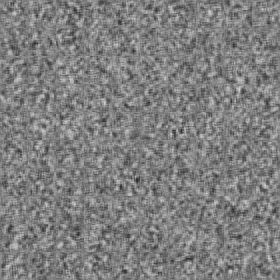

In [29]:
# вход (начальное состояние)
IPython.display.Image('result/00_0.png')

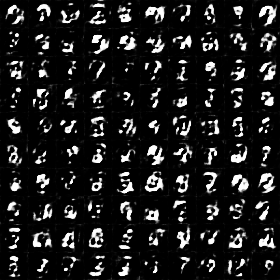

In [30]:
# после 1 эпохи обучения
IPython.display.Image('result/02_0.png')

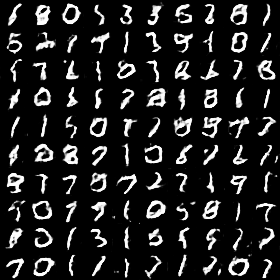

In [31]:
# после 9 эпохи обучения
IPython.display.Image('result/09_0.png')

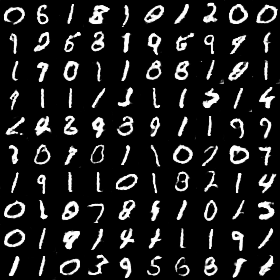

In [34]:
# конечный результат (50 эпох обучения)
IPython.display.Image('result/49_400.png')